# EMPLOYEE SALARY PREDICTION SYSTEM

The project will systematically tackle issues such as the entrenched gender pay gap, the nuanced influence of geographic location and cost of living, and the dynamic effects of macroeconomic factors like inflation and unemployment. By integrating diverse datasets—ranging from publicly available salary surveys to global cost of living and economic indicators —a robust foundation for analysis will be established. Sophisticated feature engineering will transform raw data into a rich tapestry of attributes, capturing the intricate interplay of demographic, experiential, job-specific, and contextual factors that shape remuneration.

#Data Acquisition

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Creating the .kaggle directory if it doesn't exist
# Using os.makedirs for portability across different operating systems
os.makedirs(os.path.expanduser('~/.kaggle/'), exist_ok=True)

# Copying the kaggle.json file from Google Drive to the .kaggle directory
# Using shutil.copy for portability
import shutil
try:
    shutil.copy('/content/drive/MyDrive/.kaggle/kaggle.json', os.path.expanduser('~/.kaggle/'))
    print("kaggle.json copied successfully.")
except FileNotFoundError:
    print("Error: kaggle.json not found in the specified Google Drive path.")
except Exception as e:
    print(f"An error occurred while copying kaggle.json: {e}")


# Setting permissions for the kaggle.json file
# Using os.chmod for portability
try:
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)
    print("Permissions set for kaggle.json.")
except FileNotFoundError:
    print("Error: kaggle.json not found in the .kaggle directory after copying.")
except Exception as e:
    print(f"An error occurred while setting permissions for kaggle.json: {e}")

kaggle.json copied successfully.
Permissions set for kaggle.json.


base datasets

In [ ]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('zedataweaver/global-salary-data', path='/content/drive/MyDrive/Datasets ', unzip=True)
kaggle.api.dataset_download_files('rkiattisak/salaly-prediction-for-beginer', path='/content/drive/MyDrive/Datasets ', unzip=True)
kaggle.api.dataset_download_files('thedevastator/uncovering-global-data-professional-salary-trend', path='/content/drive/MyDrive/Datasets ', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/zedataweaver/global-salary-data
Dataset URL: https://www.kaggle.com/datasets/rkiattisak/salaly-prediction-for-beginer
Dataset URL: https://www.kaggle.com/datasets/thedevastator/uncovering-global-data-professional-salary-trend


In [ ]:
import pandas as pd

In [ ]:
import pandas as pd

global_salary_data=pd.read_csv('/content/drive/MyDrive/Datasets /salary_data.csv')
salary_by_profession_and_country_over_time=pd.read_csv('/content/drive/MyDrive/Datasets /2019_Data_Professional_Salary_Survey_Responses.csv')
salary_by_profession_and_country_over_time_2021=pd.read_csv('/content/drive/MyDrive/Datasets /Data_Professional_Salary_Survey_Responses.csv')
salaly_prediction_dataset=pd.read_csv('/content/drive/MyDrive/Datasets /Salary Data.csv')

These public datasets offer a foundational layer for understanding salary determinants and testing initial model hypotheses. However, their limitations in scope, data quality, and representativeness necessitate integration with more comprehensive and reliable data sources.

Incorporating COLI dataset

In [ ]:
kaggle.api.dataset_download_files('mvieira101/global-cost-of-living', path='/content/drive/MyDrive/Datasets ', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/mvieira101/global-cost-of-living


In [ ]:
coli_dataset=pd.read_csv('/content/drive/MyDrive/Datasets /cost-of-living.csv')
coli_dataset_2=pd.read_csv('/content/drive/MyDrive/Datasets /cost-of-living_v2.csv')

Incorporating Economic Indicators Data

In [ ]:
!pip install wbgapi

Data from the World Bank API for all countries for the years 2017,2018, 2019 and 2021.

The World Bank's indicator codes for each series:
- GDP per capita (current US$): `NY.GDP.PCAP.CD`
- Inflation, consumer prices (annual %): `FP.CPI.TOTL.ZG`
- Unemployment rate (% of total labor force): `SL.UEM.TOTL.ZS`
- Population, total: `SP.POP.TOTL`

In [ ]:
import wbgapi as wb
import pandas as pd

# Defining the indicators and years
indicators = {
    'NY.GDP.PCAP.CD': 'GDP_per_capita',
    'FP.CPI.TOTL.ZG': 'Inflation_rate',
    'SL.UEM.TOTL.ZS': 'Unemployment_rate',
    'SP.POP.TOTL': 'Population'
}

# Including years 2017, 2018, 2019, and 2021
years = [2017, 2018, 2019, 2021]

# Fetching data for each indicator
data_frames = []
for indicator_code, indicator_name in indicators.items():
    try:
        # Fetching data for all countries ('all') for the specified years
        data = wb.data.DataFrame(indicator_code, economy='all', time=years)

        # The 'value' column is the data itself after fetching indicators
        # Rename the indicator column for clarity
        # data = data.rename(columns={'value': indicator_name}) # This rename was incorrect as 'value' is the data column

        # Adding indicator name as a column for easier merging later
        data['Indicator'] = indicator_name
        data['Indicator Code'] = indicator_code

        data_frames.append(data)
    except Exception as e:
        print(f"Could not fetch data for indicator {indicator_code}: {e}")

# Concatenate the dataframes
if data_frames:
    world_bank_data_long = pd.concat(data_frames)

    # Resetting index to turn 'economy' (country code) and 'time' (year) into columns
    world_bank_data_long = world_bank_data_long.reset_index()

    # Renaming columns for clarity
    world_bank_data_long = world_bank_data_long.rename(columns={'economy': 'Country_Code', 'time': 'Year'})

    # Fetching country names using country codes
    countries = wb.economy.DataFrame().reset_index()
    # Correcting 'value' to 'name' as per the actual column in countries DataFrame
    countries = countries[['id', 'name']].rename(columns={'id': 'Country_Code', 'name': 'Country_Name'})

    # Merging with country names
    world_bank_data_long = pd.merge(world_bank_data_long, countries, on='Country_Code', how='left')

    # The actual data column after fetching is named based on the year (e.g., 'YR2019', 'YR2021')
    # We need to melt this wide format back to long format before pivoting
    id_vars = ['Country_Code', 'Country_Name', 'Indicator', 'Indicator Code']
    year_cols = [col for col in world_bank_data_long.columns if col.startswith('YR')]

    world_bank_data_long = world_bank_data_long.melt(
        id_vars=id_vars,
        value_vars=year_cols,
        var_name='Year_Code',
        value_name='value'
    )

    # Extract year from Year_Code (e.g., 'YR2019' -> 2019)
    world_bank_data_long['Year'] = world_bank_data_long['Year_Code'].str.replace('YR', '').astype(int)

    # Drop the old Year and Year_Code columns
    world_bank_data_long = world_bank_data_long.drop(columns=['Year_Code'])


    # Pivot the data to have indicators as columns
    world_bank_data_wide = world_bank_data_long.pivot_table(
        index=['Country_Code', 'Country_Name', 'Year'],
        columns='Indicator',
        values='value'
    ).reset_index()

    display(world_bank_data_wide.head())
else:
    print("No data frames were created. Please check the indicators and years.")

Indicator Country_Code                 Country_Name  Year  GDP_per_capita  \
0                  ABW                        Aruba  2017    28440.051964   
1                  ABW                        Aruba  2018    30082.127645   
2                  ABW                        Aruba  2019    31096.205074   
3                  ABW                        Aruba  2021    27200.061079   
4                  AFE  Africa Eastern and Southern  2017     1520.212231   

Indicator  Inflation_rate   Population  Unemployment_rate  
0               -1.028282     108735.0                NaN  
1                3.626041     108908.0                NaN  
2                4.257462     109203.0                NaN  
3                     NaN     107700.0                NaN  
4                6.399343  640058741.0           7.346331

By incorporating economic indicators and COLI data, the model can move beyond simple nominal salary prediction to provide a more nuanced understanding of an employee's financial reality. This integration enables the project to analyze the impact of inflation on real wages, assess the influence of local and global labor market dynamics, and support employees in making informed decisions about relocation or remote work based on true economic value.

# EDA and Pre Processing

Global Salary Data

In [ ]:
#Examining the first few rows of global_salary_data and its information to identify potential preprocessing needs.
display(global_salary_data.head())
global_salary_data.info()

country_name continent_name wage_span  median_salary  average_salary  \
0     Afghanistan           Asia   Monthly         853.74         1001.15   
1   Aland Islands         Europe   Monthly        3319.24         3858.35   
2         Albania         Europe   Monthly         832.84          956.92   
3         Algeria         Africa   Monthly        1148.84         1308.81   
4  American Samoa        Oceania   Monthly        1390.00         1570.00   

   lowest_salary  highest_salary  
0         252.53         4460.97  
1         972.52        17124.74  
2         241.22         4258.49  
3         330.11         5824.18  
4         400.00         6980.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    221 non-null    object 
 1   continent_name  221 non-null    object 
 2   wage_span       221 non-null    object 
 3   median_salary   221 non-null    float64
 4   average_salary  221 non-null    float64
 5   lowest_salary   221 non-null    float64
 6   highest_salary  221 non-null    float64
dtypes: float64(4), object(3)
memory usage: 12.2+ KB


In [ ]:
#checking the unique values and their counts in the wage_span column of the global_salary_data DataFrame.
display(global_salary_data['wage_span'].value_counts())

wage_span
Monthly    221
Name: count, dtype: int64

In [ ]:
#basic statistics for the numerical salary benchmark features ('median_salary', 'average_salary', 'lowest_salary', 'highest_salary') in global_salary_data.
print("Basic statistics for numerical salary benchmarks:")
display(global_salary_data[['median_salary', 'average_salary', 'lowest_salary', 'highest_salary']].describe())

Basic statistics for numerical salary benchmarks:


median_salary  average_salary  lowest_salary  highest_salary
count     221.000000      221.000000     221.000000      221.000000
mean     1762.631906     1982.339812     502.783204     8802.165619
std      1634.708716     1835.429193     470.073328     8140.210641
min         0.261335        0.285524       0.072092        1.271103
25%       567.210000      651.000000     163.930000     2900.480000
50%      1227.460000     1344.230000     339.450000     5974.360000
75%      2389.010000     2740.000000     690.000000    12050.740000
max      9836.070000    11292.900000    2850.270000    50363.930000

In [ ]:
#examining the unique values and counts for the categorical features ('country_name', 'continent_name') in global_salary_data.
print("Unique values and counts for 'country_name':")
display(global_salary_data['country_name'].value_counts()[:50]) # Display top 50 for brevity

print("\nUnique values and counts for 'continent_name':")
display(global_salary_data['continent_name'].value_counts())

Unique values and counts for 'country_name':


country_name
Afghanistan                       1
Aland Islands                     1
Albania                           1
Algeria                           1
American Samoa                    1
Andorra                           1
Angola                            1
Antigua and Barbuda               1
Argentina                         1
Armenia                           1
Aruba                             1
Australia                         1
Austria                           1
Azerbaijan                        1
Bahamas                           1
Bahrain                           1
Bangladesh                        1
Barbados                          1
Belarus                           1
Belgium                           1
Belize                            1
Benin                             1
Bermuda                           1
Bhutan                            1
Bolivia                           1
Bosnia and Herzegovina            1
Botswana                          1
Brazil                            1
British Indian Ocean Territory    1
Brunei                            1
Bulgaria                          1
Burkina Faso                      1
Burundi                           1
Cambodia                          1
Cameroon                          1
Canada                            1
Cape Verde                        1
Cayman Islands                    1
Central African Republic          1
Chad                              1
Chile                             1
China                             1
Colombia                          1
Comoros                           1
Congo                             1
Congo Democratic Republic         1
Cook Islands                      1
Costa Rica                        1
Cote Divoire                      1
Croatia                           1
Name: count, dtype: int64


Unique values and counts for 'continent_name':


continent_name
Africa              57
Europe              49
Asia                48
Oceania             18
Caribbean           18
South America       13
Central America      8
North America        6
Northern America     4
Name: count, dtype: int64

In [ ]:
# Apply the country name mapping to the 'country_name' column in global_salary_data
# Using the country_name_mapping defined earlier
# If country_name_mapping is not defined, redefine it here
if 'country_name_mapping' not in globals():
    # Define a basic mapping, user can expand as needed
    country_name_mapping = {
        'United States': 'United States',
        'United Kingdom': 'United Kingdom',
        'Canada': 'Canada',
        'Germany': 'Germany',
        'India': 'India',
        'Australia': 'Australia',
        'France': 'France',
        'Brazil': 'Brazil',
        'Japan': 'Japan',
        'China': 'China',
        # Add more mappings here based on the unique values from relevant dataframes
        'Viet Nam': 'Vietnam',
        'South Korea': 'Korea, Rep.',
        'Taiwan': 'China', # Example, depends on how Taiwan is treated in World Bank data
        'Hong Kong': 'Hong Kong SAR, China',
        'Czech Republic': 'Czechia',
        'Slovak Republic': 'Slovakia',
        # Add all necessary mappings from previous attempts if needed
        'Russian Federation': 'Russian Federation', # Added from earlier in conversation
        'Iran, Islamic Rep.': 'Iran', # Added from earlier in conversation
        'Macao': 'Macao SAR, China', # Added from earlier in conversation
        'Bosnia and Herzegovina': 'Bosnia and Herzegovina', # Added from earlier in conversation
        'North Macedonia': 'North Macedonia', # Added from earlier in conversation
        'South Africa': 'South Africa', # Added from earlier in conversation
        'New Zealand': 'New Zealand', # Added from earlier in conversation
        'Singapore': 'Singapore', # Added from earlier in conversation
        'Malaysia': 'Malaysia', # Added from earlier in conversation
        'Philippines': 'Philippines', # Added from earlier in conversation
        'Indonesia': 'Indonesia', # Added from earlier in conversation
        'Thailand': 'Thailand', # Added from earlier in conversation
        'Mexico': 'Mexico', # Added from earlier in conversation
        'Colombia': 'Colombia', # Added from earlier in conversation
        'Argentina': 'Argentina', # Added from earlier in conversation
        'Chile': 'Chile', # Added from earlier in conversation
        'Peru': 'Peru', # Added from earlier in conversation
        'Venezuela': 'Venezuela, RB', # Added from earlier in conversation
        'Nigeria': 'Nigeria', # Added from earlier in conversation
        'Egypt': 'Egypt, Arab Rep.', # Added from earlier in conversation
        'Pakistan': 'Pakistan', # Added from earlier in conversation
        'Bangladesh': 'Bangladesh', # Added from earlier in conversation
        'Sri Lanka': 'Sri Lanka', # Added from earlier in conversation
        'Turkey': 'Turkey', # Added from earlier in conversation
        'Greece': 'Greece', # Added from earlier in conversation
        'Poland': 'Poland', # Added from earlier in conversation
        'Sweden': 'Sweden', # Added from earlier in conversation
        'Norway': 'Norway', # Added from earlier in conversation
        'Denmark': 'Denmark', # Added from earlier in conversation
        'Finland': 'Finland', # Added from earlier in conversation
        'Ireland': 'Ireland', # Added from earlier in conversation
        'Switzerland': 'Switzerland', # Added from earlier in conversation
        'Austria': 'Austria', # Added from earlier in conversation
        'Belgium': 'Belgium', # Added from earlier in conversation
        'Netherlands': 'Netherlands', # Added from earlier in conversation
        'Spain': 'Spain', # Added from earlier in conversation
        'Portugal': 'Portugal', # Added from earlier in conversation
        'Italy': 'Italy', # Added from earlier in conversation
        'Israel': 'Israel', # Added from earlier in conversation
        'Saudi Arabia': 'Saudi Arabia', # Added from earlier in conversation
        'United Arab Emirates': 'United Arab Emirates', # Added from earlier in conversation
        'Qatar': 'Qatar', # Added from earlier in conversation
        'Kuwait': 'Kuwait', # Added from earlier in conversation
        'Bahrain': 'Bahrain', # Added from earlier in conversation
        'Oman': 'Oman', # Added from earlier in conversation
        'Lebanon': 'Lebanon', # Added from earlier in conversation
        'Jordan': 'Jordan', # Added from earlier in conversation
        'Syrian Arab Republic': 'Syria', # Added from earlier in conversation
        'Iraq': 'Iraq', # Added from earlier in conversation
        'Afghanistan': 'Afghanistan', # Added from earlier in conversation
        'Nepal': 'Nepal', # Added from earlier in conversation
        'Myanmar': 'Myanmar', # Added from earlier in conversation
        'Cambodia': 'Cambodia', # Added from earlier in conversation
        'Lao PDR': 'Lao PDR', # Added from earlier in conversation
        'Mongolia': 'Mongolia', # Added from earlier in conversation
        'Uzbekistan': 'Uzbekistan', # Added from earlier in conversation
        'Kazakhstan': 'Kazakhstan', # Added from earlier in conversation
        'Ukraine': 'Ukraine', # Added from earlier in conversation
        'Belarus': 'Belarus', # Added from earlier in conversation
        'Lithuania': 'Lithuania', # Added from earlier in conversation
        'Latvia': 'Latvia', # Added from earlier in conversation
        'Estonia': 'Estonia', # Added from earlier in conversation
        'Hungary': 'Hungary', # Added from earlier in conversation
        'Romania': 'Romania', # Added from earlier in conversation
        'Bulgaria': 'Bulgaria', # Added from earlier in conversation
        'Serbia': 'Serbia', # Added from earlier in conversation
        'Croatia': 'Croatia', # Added from earlier in conversation
        'Slovenia': 'Slovenia', # Added from earlier in conversation
        'Albania': 'Albania', # Added from earlier in conversation
        'Malta': 'Malta', # Added from earlier in conversation
        'Cyprus': 'Cyprus', # Added from earlier in conversation
        'Georgia': 'Georgia', # Added from earlier in conversation
        'Armenia': 'Armenia', # Added from earlier in conversation
        'Azerbaijan': 'Azerbaijan', # Added from earlier in conversation
        'Kyrgyz Republic': 'Kyrgyz Republic', # Added from earlier in conversation
        'Tajikistan': 'Tajikistan', # Added from earlier in conversation
        'Turkmenistan': 'Turkmenistan', # Added from earlier in conversation
        'Moldova': 'Moldova', # Added from earlier in conversation
        'Andorra': 'Andorra', # Added from earlier in conversation
        'Monaco': 'Monaco', # Added from earlier in conversation
        'San Marino': 'San Marino', # Added from earlier in conversation
        'Holy See': 'Holy See (Vatican City State)', # Added from earlier in conversation
        'Greenland': 'Greenland', # Added from earlier in conversation
        'Puerto Rico': 'Puerto Rico', # Added from earlier in conversation
        'Guam': 'Guam', # Added from earlier in conversation
        'Virgin Islands (U.S.)': 'Virgin Islands (U.S.)', # Added from earlier in conversation
        'American Samoa': 'American Samoa', # Added from earlier in conversation
        'Northern Mariana Islands': 'Northern Mariana Islands', # Added from earlier in conversation
        'Palau': 'Palau', # Added from earlier in conversation
        'Micronesia, Fed. Sts.': 'Micronesia, Fed. Sts.', # Added from earlier in conversation
        'Marshall Islands': 'Marshall Islands', # Added from earlier in conversation
        'Fiji': 'Fiji', # Added from earlier in conversation
        'Samoa': 'Samoa', # Added from earlier in conversation
        'Tonga': 'Tonga', # Added from earlier in conversation
        'Vanuatu': 'Vanuatu', # Added from earlier in conversation
        'Solomon Islands': 'Solomon Islands', # Added from earlier in conversation
        'Papua New Guinea': 'Papua New Guinea', # Added from earlier in conversation
        'Timor-Leste': 'Timor-Leste', # Added from earlier in conversation
        'Brunei Darussalam': 'Brunei Darussalam', # Added from earlier in conversation
        'East Timor': 'Timor-Leste', # Added from earlier in conversation
        'Cuba': 'Cuba', # Added from earlier in conversation
        'Haiti': 'Haiti', # Added from earlier in conversation
        'Dominican Republic': 'Dominican Republic', # Added from earlier in conversation
        'Jamaica': 'Jamaica', # Added from earlier in conversation
        'Trinidad and Tobago': 'Trinidad and Tobago', # Added from earlier in conversation
        'Barbados': 'Barbados', # Added from earlier in conversation
        'Bahamas, The': 'Bahamas, The', # Added from earlier in conversation
        'Belize': 'Belize', # Added from earlier in conversation
        'Guatemala': 'Guatemala', # Added from earlier in conversation
        'Honduras': 'Honduras', # Added from earlier in conversation
        'El Salvador': 'El Salvador', # Added from earlier in conversation
        'Nicaragua': 'Nicaragua', # Added from earlier in conversation
        'Costa Rica': 'Costa Rica', # Added from earlier in conversation
        'Panama': 'Panama', # Added from earlier in conversation
        'Guyana': 'Guyana', # Added from earlier in conversation
        'Suriname': 'Suriname', # Added from earlier in conversation
        'French Guiana': 'French Guiana', # Added from earlier in conversation
        'Ecuador': 'Ecuador', # Added from earlier in conversation
        'Bolivia': 'Bolivia', # Added from earlier in conversation
        'Paraguay': 'Paraguay', # Added from earlier in conversation
        'Uruguay': 'Uruguay', # Added from earlier in conversation
        'Falkland Islands (Malvinas)': 'Falkland Islands (Malvinas)', # Added from earlier in conversation
        'Algeria': 'Algeria', # Added from earlier in conversation
        'Morocco': 'Morocco', # Added from earlier in conversation
        'Tunisia': 'Tunisia', # Added from earlier in conversation
        'Libya': 'Libya', # Added from earlier in conversation
        'Sudan': 'Sudan', # Added from earlier in conversation
        'South Sudan': 'South Sudan', # Added from earlier in conversation
        'Mauritania': 'Mauritania', # Added from earlier in conversation
        'Mali': 'Mali', # Added from earlier in conversation
        'Niger': 'Niger', # Added from earlier in conversation
        'Chad': 'Chad', # Added from earlier in conversation
        'Burkina Faso': 'Burkina Faso', # Added from earlier in conversation
        "Cote d'Ivoire": "Cote d'Ivoire", # Added from earlier in conversation
        'Ghana': 'Ghana', # Added from earlier in conversation
        'Togo': 'Togo', # Added from earlier in conversation
        'Benin': 'Benin', # Added from earlier in conversation
        'Sierra Leone': 'Sierra Leone', # Added from earlier in conversation
        'Liberia': 'Liberia', # Added from earlier in conversation
        'Guinea': 'Guinea', # Added from earlier in conversation
        'Guinea-Bissau': 'Guinea-Bissau', # Added from earlier in conversation
        'Gambia, The': 'Gambia, The', # Added from earlier in conversation
        'Senegal': 'Senegal', # Added from earlier in conversation
        'Cabo Verde': 'Cabo Verde', # Added from earlier in conversation
        'Sao Tome and Principe': 'Sao Tome and Principe', # Added from earlier in conversation
        'Equatorial Guinea': 'Equatorial Guinea', # Added from earlier in conversation
        'Gabon': 'Gabon', # Added from earlier in conversation
        'Congo, Rep.': 'Congo, Rep.', # Added from earlier in conversation
        'Congo, Dem. Rep.': 'Congo, Dem. Rep.', # Added from earlier in conversation
        'Central African Republic': 'Central African Republic', # Added from earlier in conversation
        'Cameroon': 'Cameroon', # Added from earlier in conversation
        'Angola': 'Angola', # Added from earlier in conversation
        'Namibia': 'Namibia', # Added from earlier in conversation
        'Botswana': 'Botswana', # Added from earlier in conversation
        'Zimbabwe': 'Zimbabwe', # Added from earlier in conversation
        'Zambia': 'Zambia', # Added from earlier in conversation
        'Malawi': 'Malawi', # Added from earlier in conversation
        'Mozambique': 'Mozambique', # Added from earlier in conversation
        'Eswatini': 'Eswatini', # Added from earlier in conversation
        'Lesotho': 'Lesotho', # Added from earlier in conversation
        'Madagascar': 'Madagascar', # Added from earlier in conversation
        'Comoros': 'Comoros', # Added from earlier in conversation
        'Mauritius': 'Mauritius', # Added from earlier in conversation
        'Seychelles': 'Seychelles', # Added from earlier in conversation
        'Djibouti': 'Djibouti', # Added from earlier in conversation
        'Eritrea': 'Eritrea', # Added from earlier in conversation
        'Ethiopia': 'Ethiopia', # Added from earlier in conversation
        'Somalia': 'Somalia', # Added from earlier in conversation
        'Kenya': 'Kenya', # Added from earlier in conversation
        'Uganda': 'Uganda', # Added from earlier in conversation
        'Rwanda': 'Rwanda', # Added from earlier in conversation
        'Burundi': 'Burundi', # Added from earlier in conversation
        'Tanzania': 'Tanzania', # Added from earlier in conversation
        'Maldives': 'Maldives', # Added from earlier in conversation
        'Cape Verde': 'Cabo Verde', # Added from earlier in conversation
        'Swaziland': 'Eswatini', # Added from earlier in conversation
        'Korea, South': 'Korea, Rep.', # Added from earlier in conversation
        # New mappings for countries unmapped from global_salary_data
        'Aland Islands': 'Aland Islands', # Keeping as is for now, may not have WB/COLI data
        'Antigua and Barbuda': 'Antigua and Barbuda',
        'Aruba': 'Aruba',
        'Bahamas': 'Bahamas, The',
        'Bermuda': 'Bermuda',
        'Bhutan': 'Bhutan',
        'British Indian Ocean Territory': 'British Indian Ocean Territory', # Keeping as is for now
        'Brunei': 'Brunei Darussalam',
        'Cayman Islands': 'Cayman Islands',
        'Congo': 'Congo, Rep.', # Assuming this refers to Republic of Congo based on common usage, clarify if needed
        'Congo Democratic Republic': 'Congo, Dem. Rep.',
        'Cook Islands': 'Cook Islands',
        'Cote Divoire': "Cote d'Ivoire",
        'Dominica': 'Dominica',
        'Faroe Islands': 'Faroe Islands', # Keeping as is for now
        'French Polynesia': 'French Polynesia', # Keeping as is for now
        'Gambia': 'Gambia, The',
        'Gibraltar': 'Gibraltar', # Keeping as is for now
        'Grenada': 'Grenada',
        'Guadeloupe': 'Guadeloupe', # Keeping as is for now
        'Guernsey': 'Guernsey', # Keeping as is for now
        'Iceland': 'Iceland',
        'Iran': 'Iran, Islamic Rep.',
        'Jersey': 'Jersey', # Keeping as is for now
        'Kiribati': 'Kiribati',
        'Korea (North)': 'Korea, Dem. People\'s Rep.',
        'Korea (South)': 'Korea, Rep.',
        'Kyrgyzstan': 'Kyrgyz Republic',
        'Laos': 'Lao PDR',
        'Liechtenstein': 'Liechtenstein',
        'Luxembourg': 'Luxembourg',
        'Macedonia': 'North Macedonia', # Using the updated name
        'Martinique': 'Martinique', # Keeping as is for now
        'Mayotte': 'Mayotte', # Keeping as is for now
        'Micronesia': 'Micronesia, Fed. Sts.',
        'Montenegro': 'Montenegro',
        'Montserrat': 'Montserrat', # Keeping as is for now
        'Netherlands Antilles': 'Curacao', # Netherlands Antilles dissolved, Curacao and Sint Maarten are common
        'New Caledonia': 'New Caledonia', # Keeping as is for now
        'Palestine': 'West Bank and Gaza',
        'Reunion': 'Reunion', # Keeping as is for now
        'Russia': 'Russian Federation',
        'Saint Kitts and Nevis': 'Saint Kitts and Nevis',
        'Saint Lucia': 'Saint Lucia',
        'Saint Martin': 'Sint Maarten (Dutch part)', # Assuming Dutch part, clarify if needed
        'Saint Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
        'Slovakia': 'Slovakia',
        'Syria': 'Syrian Arab Republic',
        'Turks and Caicos Islands': 'Turks and Caicos Islands',
        'Vietnam': 'Viet Nam',
        'Virgin Islands (British)': 'British Virgin Islands',
        'Virgin Islands (US)': 'Virgin Islands (U.S.)',
        'Western Sahara': 'Western Sahara', # Keeping as is for now, may not have WB/COLI data
        'Yemen': 'Yemen, Rep.'
    }
    print("Updated country_name_mapping.")


global_salary_data['country_Standardized'] = global_salary_data['country_name'].map(country_name_mapping)

# Checking for countries in global_salary_data that were not mapped
unmapped_global_countries = global_salary_data[global_salary_data['country_Standardized'].isna()]['country_name'].unique()

if len(unmapped_global_countries) > 0:
    print("Warning: The following countries from global_salary_data were not found in the mapping:")
    display(unmapped_global_countries)
    print("These countries will have missing COLI and World Bank data after merging.")
    print("Please add these to the 'country_name_mapping' dictionary if you want to include them in the analysis.")
else:
    print("All countries in global_salary_data have been mapped.")


print("\nStandardized country names in global_salary_data.")
display(global_salary_data.head())
global_salary_data.info()

Updated country_name_mapping.
All countries in global_salary_data have been mapped.

Standardized country names in global_salary_data.


country_name continent_name wage_span  median_salary  average_salary  \
0     Afghanistan           Asia   Monthly         853.74         1001.15   
1   Aland Islands         Europe   Monthly        3319.24         3858.35   
2         Albania         Europe   Monthly         832.84          956.92   
3         Algeria         Africa   Monthly        1148.84         1308.81   
4  American Samoa        Oceania   Monthly        1390.00         1570.00   

   lowest_salary  highest_salary country_Standardized  
0         252.53         4460.97          Afghanistan  
1         972.52        17124.74        Aland Islands  
2         241.22         4258.49              Albania  
3         330.11         5824.18              Algeria  
4         400.00         6980.00       American Samoa

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country_name          221 non-null    object 
 1   continent_name        221 non-null    object 
 2   wage_span             221 non-null    object 
 3   median_salary         221 non-null    float64
 4   average_salary        221 non-null    float64
 5   lowest_salary         221 non-null    float64
 6   highest_salary        221 non-null    float64
 7   country_Standardized  221 non-null    object 
dtypes: float64(4), object(4)
memory usage: 13.9+ KB


Salary by Profession and Country Over Time

In [ ]:
#Examining the first few rows of salary_by_profession_and_country_over_timeand its information to identify potential preprocessing needs.
display(salary_by_profession_and_country_over_time.head())
salary_by_profession_and_country_over_time.info()

index  \
0      0   
1      1   
2      2   
3      3   
4      4   

  This data is from the 2017/2018/2019 Data Professional Salary Survey. For more details and analysis, visit:  \
0                https://www.BrentOzar.com/go/salary                                                            
1                                                NaN                                                            
2                                        Survey Year                                                            
3                                               2017                                                            
4                                               2017                                                            

            Unnamed: 1 Unnamed: 2      Unnamed: 3  Unnamed: 4  \
0                  NaN        NaN             NaN         NaN   
1                  NaN        NaN             NaN         NaN   
2            Timestamp  SalaryUSD         Country  PostalCode   
3  01/05/2017 05:10:20     200000   United States   Not Asked   
4  01/05/2017 05:26:23      61515  United Kingdom   Not Asked   

             Unnamed: 5             Unnamed: 6          Unnamed: 7  \
0                   NaN                    NaN                 NaN   
1                   NaN                    NaN                 NaN   
2       PrimaryDatabase  YearsWithThisDatabase      OtherDatabases   
3  Microsoft SQL Server                     10       MySQL/MariaDB   
4  Microsoft SQL Server                     15  Oracle, PostgreSQL   

           Unnamed: 8  ...         Unnamed: 19             Unnamed: 20  \
0                 NaN  ...                 NaN                     NaN   
1                 NaN  ...                 NaN                     NaN   
2    EmploymentStatus  ...  HoursWorkedPerWeek  TelecommuteDaysPerWeek   
3  Full time employee  ...                  45                       1   
4  Full time employee  ...                  35                       2   

                            Unnamed: 21       Unnamed: 22  \
0                                   NaN               NaN   
1                                   NaN               NaN   
2  PopulationOfLargestCityWithin20Miles  EmploymentSector   
3                             Not Asked  Private business   
4                             Not Asked  Private business   

                              Unnamed: 23          Unnamed: 24 Unnamed: 25  \
0                                     NaN                  NaN         NaN   
1                                     NaN                  NaN         NaN   
2                    LookingForAnotherJob  CareerPlansThisYear      Gender   
3  Yes, but only passively (just curious)            Not Asked   Not Asked   
4                                      No            Not Asked   Not Asked   

      Unnamed: 26            Unnamed: 27 Unnamed: 28  
0             NaN                    NaN         NaN  
1             NaN                    NaN         NaN  
2  OtherJobDuties  KindsOfTasksPerformed     Counter  
3       Not Asked              Not Asked           1  
4       Not Asked              Not Asked           1  

[5 rows x 30 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6917 entries, 0 to 6916
Data columns (total 30 columns):
 #   Column                                                                                                       Non-Null Count  Dtype 
---  ------                                                                                                       --------------  ----- 
 0   index                                                                                                        6917 non-null   int64 
 1   This data is from the 2017/2018/2019 Data Professional Salary Survey. For more details and analysis, visit:  6916 non-null   object
 2   Unnamed: 1                                                                                                   6894 non-null   object
 3   Unnamed: 2                                                                                                   6894 non-null   object
 4   Unnamed: 3                                                        

In [ ]:
import pandas as pd

# Loading the dataset without a header
salary_by_profession_and_country_over_time_raw = pd.read_csv('/content/drive/MyDrive/Datasets /2019_Data_Professional_Salary_Survey_Responses.csv', header=None)

# Manually defining the correct column names, including a name for the first column
correct_column_names = [
    'Original Index','Survey Year', 'Timestamp', 'SalaryUSD', 'Country', 'PostalCode',
    'PrimaryDatabase', 'YearsWithThisDatabase', 'OtherDatabases',
    'EmploymentStatus', 'JobTitle', 'ManageStaff', 'YearsWithThisTypeOfJob',
    'HowManyCompanies', 'OtherPeopleOnYourTeam', 'CompanyEmployeesOverall',
    'DatabaseServers', 'Education', 'EducationIsComputerRelated', 'Certifications',
    'HoursWorkedPerWeek', 'TelecommuteDaysPerWeek', 'PopulationOfLargestCityWithin20Miles',
    'EmploymentSector', 'LookingForAnotherJob', 'CareerPlansThisYear', 'Gender',
    'OtherJobDuties', 'KindsOfTasksPerformed', 'Counter'
]

# Assigning these names to the DataFrame's columns
salary_by_profession_and_country_over_time_raw.columns = correct_column_names

# Dropping the first three rows (index 0, 1, and 2) as they are not data
# These rows contain metadata and the original header row
salary_by_profession_and_country_over_time_cleaned = salary_by_profession_and_country_over_time_raw.drop([0, 1, 2])

# Resetting the index of the cleaned DataFrame
salary_by_profession_and_country_over_time_cleaned = salary_by_profession_and_country_over_time_cleaned.reset_index(drop=True)

# Displaying the head and info of the final cleaned DataFrame
display(salary_by_profession_and_country_over_time_cleaned.head())
salary_by_profession_and_country_over_time_cleaned.info()

Original Index  Survey Year            Timestamp  SalaryUSD         Country  \
0              2  Survey Year            Timestamp  SalaryUSD         Country   
1              3         2017  01/05/2017 05:10:20     200000   United States   
2              4         2017  01/05/2017 05:26:23      61515  United Kingdom   
3              5         2017  01/05/2017 05:32:57      95000         Germany   
4              6         2017  01/05/2017 05:33:03      56000  United Kingdom   

   PostalCode       PrimaryDatabase  YearsWithThisDatabase  \
0  PostalCode       PrimaryDatabase  YearsWithThisDatabase   
1   Not Asked  Microsoft SQL Server                     10   
2   Not Asked  Microsoft SQL Server                     15   
3   Not Asked  Microsoft SQL Server                      5   
4   Not Asked  Microsoft SQL Server                      6   

                    OtherDatabases    EmploymentStatus  ...  \
0                   OtherDatabases    EmploymentStatus  ...   
1                    MySQL/MariaDB  Full time employee  ...   
2               Oracle, PostgreSQL  Full time employee  ...   
3  Oracle, MySQL/MariaDB, Informix  Full time employee  ...   
4                              NaN  Full time employee  ...   

   HoursWorkedPerWeek             TelecommuteDaysPerWeek  \
0  HoursWorkedPerWeek             TelecommuteDaysPerWeek   
1                  45                                  1   
2                  35                                  2   
3                  45  None, or less than 1 day per week   
4                  40                                  1   

   PopulationOfLargestCityWithin20Miles  EmploymentSector  \
0  PopulationOfLargestCityWithin20Miles  EmploymentSector   
1                             Not Asked  Private business   
2                             Not Asked  Private business   
3                             Not Asked  Private business   
4                             Not Asked  Private business   

                     LookingForAnotherJob  CareerPlansThisYear     Gender  \
0                    LookingForAnotherJob  CareerPlansThisYear     Gender   
1  Yes, but only passively (just curious)            Not Asked  Not Asked   
2                                      No            Not Asked  Not Asked   
3  Yes, but only passively (just curious)            Not Asked  Not Asked   
4  Yes, but only passively (just curious)            Not Asked  Not Asked   

   OtherJobDuties  KindsOfTasksPerformed  Counter  
0  OtherJobDuties  KindsOfTasksPerformed  Counter  
1       Not Asked              Not Asked        1  
2       Not Asked              Not Asked        1  
3       Not Asked              Not Asked        1  
4       Not Asked              Not Asked        1  

[5 rows x 30 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6915 entries, 0 to 6914
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Original Index                        6915 non-null   object
 1   Survey Year                           6915 non-null   object
 2   Timestamp                             6894 non-null   object
 3   SalaryUSD                             6894 non-null   object
 4   Country                               6894 non-null   object
 5   PostalCode                            5935 non-null   object
 6   PrimaryDatabase                       6894 non-null   object
 7   YearsWithThisDatabase                 6894 non-null   object
 8   OtherDatabases                        5521 non-null   object
 9   EmploymentStatus                      6894 non-null   object
 10  JobTitle                              6894 non-null   object
 11  ManageStaff                   

In [ ]:
# Removing the row at index 0
salary_by_profession_and_country_over_time_cleaned = salary_by_profession_and_country_over_time_cleaned.drop(index=0)

# Resetting the index after dropping the row
salary_by_profession_and_country_over_time_cleaned = salary_by_profession_and_country_over_time_cleaned.reset_index(drop=True)

# Displaying the head and info of the DataFrame after removing the row
display(salary_by_profession_and_country_over_time_cleaned.head())
salary_by_profession_and_country_over_time_cleaned.info()

Original Index Survey Year            Timestamp SalaryUSD         Country  \
0              3        2017  01/05/2017 05:10:20    200000   United States   
1              4        2017  01/05/2017 05:26:23     61515  United Kingdom   
2              5        2017  01/05/2017 05:32:57     95000         Germany   
3              6        2017  01/05/2017 05:33:03     56000  United Kingdom   
4              7        2017  01/05/2017 05:34:33     35000          France   

  PostalCode       PrimaryDatabase YearsWithThisDatabase  \
0  Not Asked  Microsoft SQL Server                    10   
1  Not Asked  Microsoft SQL Server                    15   
2  Not Asked  Microsoft SQL Server                     5   
3  Not Asked  Microsoft SQL Server                     6   
4  Not Asked  Microsoft SQL Server                    10   

                    OtherDatabases  \
0                    MySQL/MariaDB   
1               Oracle, PostgreSQL   
2  Oracle, MySQL/MariaDB, Informix   
3                              NaN   
4                           Oracle   

                                    EmploymentStatus  ... HoursWorkedPerWeek  \
0                                 Full time employee  ...                 45   
1                                 Full time employee  ...                 35   
2                                 Full time employee  ...                 45   
3                                 Full time employee  ...                 40   
4  Full time employee of a consulting/contracting...  ...                 40   

              TelecommuteDaysPerWeek PopulationOfLargestCityWithin20Miles  \
0                                  1                            Not Asked   
1                                  2                            Not Asked   
2  None, or less than 1 day per week                            Not Asked   
3                                  1                            Not Asked   
4  None, or less than 1 day per week                            Not Asked   

   EmploymentSector                    LookingForAnotherJob  \
0  Private business  Yes, but only passively (just curious)   
1  Private business                                      No   
2  Private business  Yes, but only passively (just curious)   
3  Private business  Yes, but only passively (just curious)   
4  Private business  Yes, but only passively (just curious)   

  CareerPlansThisYear     Gender OtherJobDuties KindsOfTasksPerformed Counter  
0           Not Asked  Not Asked      Not Asked             Not Asked       1  
1           Not Asked  Not Asked      Not Asked             Not Asked       1  
2           Not Asked  Not Asked      Not Asked             Not Asked       1  
3           Not Asked  Not Asked      Not Asked             Not Asked       1  
4           Not Asked  Not Asked      Not Asked             Not Asked       1  

[5 rows x 30 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Original Index                        6914 non-null   object
 1   Survey Year                           6914 non-null   object
 2   Timestamp                             6893 non-null   object
 3   SalaryUSD                             6893 non-null   object
 4   Country                               6893 non-null   object
 5   PostalCode                            5934 non-null   object
 6   PrimaryDatabase                       6893 non-null   object
 7   YearsWithThisDatabase                 6893 non-null   object
 8   OtherDatabases                        5520 non-null   object
 9   EmploymentStatus                      6893 non-null   object
 10  JobTitle                              6893 non-null   object
 11  ManageStaff                   

In [ ]:
# Converting 'Survey Year' to integer
# Use errors='coerce' to turn any values that cannot be converted into NaN
salary_by_profession_and_country_over_time_cleaned['Survey Year'] = pd.to_numeric(salary_by_profession_and_country_over_time_cleaned['Survey Year'], errors='coerce')

# Convert 'SalaryUSD' to numeric
salary_by_profession_and_country_over_time_cleaned['SalaryUSD'] = pd.to_numeric(salary_by_profession_and_country_over_time_cleaned['SalaryUSD'], errors='coerce')

# Displaying the info and head to see the results of type conversion
display(salary_by_profession_and_country_over_time_cleaned.head())
salary_by_profession_and_country_over_time_cleaned.info()

Original Index  Survey Year            Timestamp  SalaryUSD         Country  \
0              3       2017.0  01/05/2017 05:10:20   200000.0   United States   
1              4       2017.0  01/05/2017 05:26:23    61515.0  United Kingdom   
2              5       2017.0  01/05/2017 05:32:57    95000.0         Germany   
3              6       2017.0  01/05/2017 05:33:03    56000.0  United Kingdom   
4              7       2017.0  01/05/2017 05:34:33    35000.0          France   

  PostalCode       PrimaryDatabase YearsWithThisDatabase  \
0  Not Asked  Microsoft SQL Server                    10   
1  Not Asked  Microsoft SQL Server                    15   
2  Not Asked  Microsoft SQL Server                     5   
3  Not Asked  Microsoft SQL Server                     6   
4  Not Asked  Microsoft SQL Server                    10   

                    OtherDatabases  \
0                    MySQL/MariaDB   
1               Oracle, PostgreSQL   
2  Oracle, MySQL/MariaDB, Informix   
3                              NaN   
4                           Oracle   

                                    EmploymentStatus  ... HoursWorkedPerWeek  \
0                                 Full time employee  ...                 45   
1                                 Full time employee  ...                 35   
2                                 Full time employee  ...                 45   
3                                 Full time employee  ...                 40   
4  Full time employee of a consulting/contracting...  ...                 40   

              TelecommuteDaysPerWeek PopulationOfLargestCityWithin20Miles  \
0                                  1                            Not Asked   
1                                  2                            Not Asked   
2  None, or less than 1 day per week                            Not Asked   
3                                  1                            Not Asked   
4  None, or less than 1 day per week                            Not Asked   

   EmploymentSector                    LookingForAnotherJob  \
0  Private business  Yes, but only passively (just curious)   
1  Private business                                      No   
2  Private business  Yes, but only passively (just curious)   
3  Private business  Yes, but only passively (just curious)   
4  Private business  Yes, but only passively (just curious)   

  CareerPlansThisYear     Gender OtherJobDuties KindsOfTasksPerformed Counter  
0           Not Asked  Not Asked      Not Asked             Not Asked       1  
1           Not Asked  Not Asked      Not Asked             Not Asked       1  
2           Not Asked  Not Asked      Not Asked             Not Asked       1  
3           Not Asked  Not Asked      Not Asked             Not Asked       1  
4           Not Asked  Not Asked      Not Asked             Not Asked       1  

[5 rows x 30 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6914 entries, 0 to 6913
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Original Index                        6914 non-null   object 
 1   Survey Year                           6893 non-null   float64
 2   Timestamp                             6893 non-null   object 
 3   SalaryUSD                             6890 non-null   float64
 4   Country                               6893 non-null   object 
 5   PostalCode                            5934 non-null   object 
 6   PrimaryDatabase                       6893 non-null   object 
 7   YearsWithThisDatabase                 6893 non-null   object 
 8   OtherDatabases                        5520 non-null   object 
 9   EmploymentStatus                      6893 non-null   object 
 10  JobTitle                              6893 non-null   object 
 11  ManageStaff      

In [ ]:
#Examining the first few rows of salary_by_profession_and_country_over_time_2021 and its information to identify potential preprocessing needs.
display(salary_by_profession_and_country_over_time_2021.head())
salary_by_profession_and_country_over_time_2021.info()

index  \
0      0   
1      1   
2      2   
3      3   
4      4   

  This data is from the 2021 Data Professional Salary Survey. For more details and analysis, visit:  \
0                https://www.BrentOzar.com/go/salary                                                  
1                                                NaN                                                  
2                                        Survey Year                                                  
3                                               2021                                                  
4                                               2021                                                  

            Unnamed: 1 Unnamed: 2     Unnamed: 3  Unnamed: 4  \
0                  NaN        NaN            NaN         NaN   
1                  NaN        NaN            NaN         NaN   
2            Timestamp  SalaryUSD        Country  PostalCode   
3  12/10/2020 08:22:42      65000         Sweden         NaN   
4  12/10/2020 08:23:22     145000  United States       76063   

             Unnamed: 5             Unnamed: 6                 Unnamed: 7  \
0                   NaN                    NaN                        NaN   
1                   NaN                    NaN                        NaN   
2       PrimaryDatabase  YearsWithThisDatabase             OtherDatabases   
3  Microsoft SQL Server                      4       Microsoft SQL Server   
4  Microsoft SQL Server                     15  Azure SQL DB (any flavor)   

           Unnamed: 8  ...                Unnamed: 21  \
0                 NaN  ...                        NaN   
1                 NaN  ...                        NaN   
2    EmploymentStatus  ...  NewestVersionInProduction   
3  Full time employee  ...            SQL Server 2016   
4  Full time employee  ...            SQL Server 2019   

                 Unnamed: 22                           Unnamed: 23  \
0                        NaN                                   NaN   
1                        NaN                                   NaN   
2  OldestVersionInProduction  PopulationOfLargestCityWithin20Miles   
3            SQL Server 2016                      <= 20,000 (town)   
4            SQL Server 2014                      1M+ (metropolis)   

        Unnamed: 24           Unnamed: 25  \
0               NaN                   NaN   
1               NaN                   NaN   
2  EmploymentSector  LookingForAnotherJob   
3  Private business             Not Asked   
4  Private business             Not Asked   

                              Unnamed: 26 Unnamed: 27     Unnamed: 28  \
0                                     NaN         NaN             NaN   
1                                     NaN         NaN             NaN   
2                     CareerPlansThisYear      Gender  OtherJobDuties   
3  Stay with the same employer, same role        Male       Not Asked   
4  Stay with the same employer, same role        Male       Not Asked   

             Unnamed: 29 Unnamed: 30  
0                    NaN         NaN  
1                    NaN         NaN  
2  KindsOfTasksPerformed     Counter  
3              Not Asked           1  
4              Not Asked           1  

[5 rows x 32 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10365 entries, 0 to 10364
Data columns (total 32 columns):
 #   Column                                                                                             Non-Null Count  Dtype 
---  ------                                                                                             --------------  ----- 
 0   index                                                                                              10365 non-null  int64 
 1   This data is from the 2021 Data Professional Salary Survey. For more details and analysis, visit:  10364 non-null  object
 2   Unnamed: 1                                                                                         10342 non-null  object
 3   Unnamed: 2                                                                                         10342 non-null  object
 4   Unnamed: 3                                                                                         10342 non-null  object
 5

In [ ]:
import pandas as pd

# Loading the dataset without a header
salary_by_profession_and_country_over_time_raw_2021 = pd.read_csv('/content/drive/MyDrive/Datasets /Data_Professional_Salary_Survey_Responses.csv', header=None)

# Manually defining the correct column names for the 2021 data (32 columns)
# Based on the 2017-2019 names and adding two for the extra columns in their correct positions.
correct_column_names_2021 = [
    'Original Index', # Column 0
    'Survey Year', # Column 1
    'Timestamp', # Column 2
    'SalaryUSD', # Column 3
    'Country', # Column 4
    'PostalCode', # Column 5
    'PrimaryDatabase', # Column 6
    'YearsWithThisDatabase', # Column 7
    'OtherDatabases', # Column 8
    'EmploymentStatus', # Column 9
    # Column 10 and 11 are not present in 2017-2019 dataset
    'NewestVersionInProduction', # Column 10
    'OldestVersionInProduction', # Column 11
    'JobTitle', # Column 12
    'ManageStaff', # Column 13
    'YearsWithThisTypeOfJob', # Column 14
    'HowManyCompanies', # Column 15
    'OtherPeopleOnYourTeam', # Column 16
    'CompanyEmployeesOverall', # Column 17
    'DatabaseServers', # Column 18
    'Education', # Column 19
    'EducationIsComputerRelated', # Column 20
    'Certifications', # Column 21
    'HoursWorkedPerWeek', # Column 22
    'TelecommuteDaysPerWeek', # Column 23
    'PopulationOfLargestCityWithin20Miles', # Column 24
    'EmploymentSector', # Column 25
    'LookingForAnotherJob', # Column 26
    'CareerPlansThisYear', # Column 27
    'Gender', # Column 28
    'OtherJobDuties', # Column 29
    'KindsOfTasksPerformed', # Column 30
    'Counter'  # Column 31
]


# Assigning these names to the DataFrame's columns
salary_by_profession_and_country_over_time_raw_2021.columns = correct_column_names_2021

# Dropping the first three rows (index 0, 1, and 2) as they are not data
# These rows contain metadata and the original header row
salary_by_profession_and_country_over_time_cleaned_2021 = salary_by_profession_and_country_over_time_raw_2021.drop([0, 1, 2])

# Resetting the index of the cleaned DataFrame
salary_by_profession_and_country_over_time_cleaned_2021 = salary_by_profession_and_country_over_time_cleaned_2021.reset_index(drop=True)

# --- Additional cleaning steps (same as 2017-2019 cleaning) ---

# Removing the row at index 0, as it appears to be a leftover header/descriptive row
# This row contains the original header values as data
salary_by_profession_and_country_over_time_cleaned_2021 = salary_by_profession_and_country_over_time_cleaned_2021.drop(index=0)

# Resetting the index again after dropping the row
salary_by_profession_and_country_over_time_cleaned_2021 = salary_by_profession_and_country_over_time_cleaned_2021.reset_index(drop=True)

# Converting 'Survey Year' to integer
# Use errors='coerce' to turn any values that cannot be converted into NaN
salary_by_profession_and_country_over_time_cleaned_2021['Survey Year'] = pd.to_numeric(salary_by_profession_and_country_over_time_cleaned_2021['Survey Year'], errors='coerce')

# Converting 'SalaryUSD' to numeric
salary_by_profession_and_country_over_time_cleaned_2021['SalaryUSD'] = pd.to_numeric(salary_by_profession_and_country_over_time_cleaned_2021['SalaryUSD'], errors='coerce')

# --- End of additional cleaning steps ---


# Displaying the head and info of the final cleaned DataFrame
display(salary_by_profession_and_country_over_time_cleaned_2021.head())
display(salary_by_profession_and_country_over_time_cleaned_2021.tail())
salary_by_profession_and_country_over_time_cleaned_2021.info()

Original Index  Survey Year            Timestamp  SalaryUSD         Country  \
0              3       2021.0  12/10/2020 08:22:42    65000.0          Sweden   
1              4       2021.0  12/10/2020 08:23:22   145000.0   United States   
2              5       2021.0  12/10/2020 08:23:37   105000.0   United States   
3              6       2021.0  12/10/2020 08:23:48    46482.0  United Kingdom   
4              7       2021.0  12/10/2020 08:24:03    98800.0   United States   

  PostalCode       PrimaryDatabase YearsWithThisDatabase  \
0        NaN  Microsoft SQL Server                     4   
1      76063  Microsoft SQL Server                    15   
2      43240  Microsoft SQL Server                    12   
3        NaN  Microsoft SQL Server                    10   
4        468  Microsoft SQL Server                     5   

                          OtherDatabases    EmploymentStatus  ...  \
0                   Microsoft SQL Server  Full time employee  ...   
1              Azure SQL DB (any flavor)  Full time employee  ...   
2  PostgreSQL, Azure SQL DB (any flavor)  Full time employee  ...   
3              Azure SQL DB (any flavor)  Full time employee  ...   
4                                    DB2  Full time employee  ...   

  HoursWorkedPerWeek TelecommuteDaysPerWeek  \
0    SQL Server 2016        SQL Server 2016   
1    SQL Server 2019        SQL Server 2014   
2    SQL Server 2017      SQL Server 2008R2   
3    SQL Server 2019        SQL Server 2012   
4    SQL Server 2019        SQL Server 2012   

  PopulationOfLargestCityWithin20Miles                       EmploymentSector  \
0                     <= 20,000 (town)                       Private business   
1                     1M+ (metropolis)                       Private business   
2                 300K-1M (large city)                       Private business   
3                 300K-1M (large city)  Education (K-12, college, university)   
4                     100K-299K (city)                       Private business   

  LookingForAnotherJob                     CareerPlansThisYear Gender  \
0            Not Asked  Stay with the same employer, same role   Male   
1            Not Asked  Stay with the same employer, same role   Male   
2            Not Asked  Stay with the same employer, same role   Male   
3            Not Asked  Stay with the same employer, same role   Male   
4            Not Asked  Stay with the same employer, same role   Male   

  OtherJobDuties KindsOfTasksPerformed Counter  
0      Not Asked             Not Asked       1  
1      Not Asked             Not Asked       1  
2      Not Asked             Not Asked       1  
3      Not Asked             Not Asked       1  
4      Not Asked             Not Asked       1  

[5 rows x 32 columns]

Original Index  Survey Year Timestamp  SalaryUSD Country PostalCode  \
10357          10360          NaN       NaN        NaN     NaN        NaN   
10358          10361          NaN       NaN        NaN     NaN        NaN   
10359          10362          NaN       NaN        NaN     NaN        NaN   
10360          10363          NaN       NaN        NaN     NaN        NaN   
10361          10364          NaN       NaN        NaN     NaN        NaN   

      PrimaryDatabase YearsWithThisDatabase OtherDatabases EmploymentStatus  \
10357             NaN                   NaN            NaN              NaN   
10358             NaN                   NaN            NaN              NaN   
10359             NaN                   NaN            NaN              NaN   
10360             NaN                   NaN            NaN              NaN   
10361             NaN                   NaN            NaN              NaN   

       ... HoursWorkedPerWeek TelecommuteDaysPerWeek  \
10357  ...                NaN                    NaN   
10358  ...                NaN                    NaN   
10359  ...                NaN                    NaN   
10360  ...                NaN                    NaN   
10361  ...                NaN                    NaN   

      PopulationOfLargestCityWithin20Miles EmploymentSector  \
10357                                  NaN              NaN   
10358                                  NaN              NaN   
10359                                  NaN              NaN   
10360                                  NaN              NaN   
10361                                  NaN              NaN   

      LookingForAnotherJob CareerPlansThisYear Gender OtherJobDuties  \
10357                  NaN                 NaN    NaN            NaN   
10358                  NaN                 NaN    NaN            NaN   
10359                  NaN                 NaN    NaN            NaN   
10360                  NaN                 NaN    NaN            NaN   
10361                  NaN                 NaN    NaN            NaN   

      KindsOfTasksPerformed Counter  
10357                   NaN     NaN  
10358                   NaN     NaN  
10359                   NaN     NaN  
10360                   NaN     NaN  
10361                   NaN     NaN  

[5 rows x 32 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10362 entries, 0 to 10361
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Original Index                        10362 non-null  object 
 1   Survey Year                           10341 non-null  float64
 2   Timestamp                             10341 non-null  object 
 3   SalaryUSD                             10341 non-null  float64
 4   Country                               10341 non-null  object 
 5   PostalCode                            8538 non-null   object 
 6   PrimaryDatabase                       10341 non-null  object 
 7   YearsWithThisDatabase                 10341 non-null  object 
 8   OtherDatabases                        8396 non-null   object 
 9   EmploymentStatus                      10341 non-null  object 
 10  NewestVersionInProduction             10341 non-null  object 
 11  OldestVersionIn

In [ ]:
# Combining the two cleaned salary DataFrames
combined_salary_by_profession_and_country_over_time = pd.concat([salary_by_profession_and_country_over_time_cleaned, salary_by_profession_and_country_over_time_cleaned_2021], ignore_index=True)

# Displaying the head and info of the combined DataFrame
display(combined_salary_by_profession_and_country_over_time.head())
display(combined_salary_by_profession_and_country_over_time.tail())
display(combined_salary_by_profession_and_country_over_time.info())

Original Index  Survey Year            Timestamp  SalaryUSD         Country  \
0              3       2017.0  01/05/2017 05:10:20   200000.0   United States   
1              4       2017.0  01/05/2017 05:26:23    61515.0  United Kingdom   
2              5       2017.0  01/05/2017 05:32:57    95000.0         Germany   
3              6       2017.0  01/05/2017 05:33:03    56000.0  United Kingdom   
4              7       2017.0  01/05/2017 05:34:33    35000.0          France   

  PostalCode       PrimaryDatabase YearsWithThisDatabase  \
0  Not Asked  Microsoft SQL Server                    10   
1  Not Asked  Microsoft SQL Server                    15   
2  Not Asked  Microsoft SQL Server                     5   
3  Not Asked  Microsoft SQL Server                     6   
4  Not Asked  Microsoft SQL Server                    10   

                    OtherDatabases  \
0                    MySQL/MariaDB   
1               Oracle, PostgreSQL   
2  Oracle, MySQL/MariaDB, Informix   
3                              NaN   
4                           Oracle   

                                    EmploymentStatus  ...  \
0                                 Full time employee  ...   
1                                 Full time employee  ...   
2                                 Full time employee  ...   
3                                 Full time employee  ...   
4  Full time employee of a consulting/contracting...  ...   

  PopulationOfLargestCityWithin20Miles  EmploymentSector  \
0                            Not Asked  Private business   
1                            Not Asked  Private business   
2                            Not Asked  Private business   
3                            Not Asked  Private business   
4                            Not Asked  Private business   

                     LookingForAnotherJob CareerPlansThisYear     Gender  \
0  Yes, but only passively (just curious)           Not Asked  Not Asked   
1                                      No           Not Asked  Not Asked   
2  Yes, but only passively (just curious)           Not Asked  Not Asked   
3  Yes, but only passively (just curious)           Not Asked  Not Asked   
4  Yes, but only passively (just curious)           Not Asked  Not Asked   

  OtherJobDuties KindsOfTasksPerformed Counter NewestVersionInProduction  \
0      Not Asked             Not Asked       1                       NaN   
1      Not Asked             Not Asked       1                       NaN   
2      Not Asked             Not Asked       1                       NaN   
3      Not Asked             Not Asked       1                       NaN   
4      Not Asked             Not Asked       1                       NaN   

  OldestVersionInProduction  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 32 columns]

Original Index  Survey Year Timestamp  SalaryUSD Country PostalCode  \
17271          10360          NaN       NaN        NaN     NaN        NaN   
17272          10361          NaN       NaN        NaN     NaN        NaN   
17273          10362          NaN       NaN        NaN     NaN        NaN   
17274          10363          NaN       NaN        NaN     NaN        NaN   
17275          10364          NaN       NaN        NaN     NaN        NaN   

      PrimaryDatabase YearsWithThisDatabase OtherDatabases EmploymentStatus  \
17271             NaN                   NaN            NaN              NaN   
17272             NaN                   NaN            NaN              NaN   
17273             NaN                   NaN            NaN              NaN   
17274             NaN                   NaN            NaN              NaN   
17275             NaN                   NaN            NaN              NaN   

       ... PopulationOfLargestCityWithin20Miles EmploymentSector  \
17271  ...                                  NaN              NaN   
17272  ...                                  NaN              NaN   
17273  ...                                  NaN              NaN   
17274  ...                                  NaN              NaN   
17275  ...                                  NaN              NaN   

      LookingForAnotherJob CareerPlansThisYear Gender OtherJobDuties  \
17271                  NaN                 NaN    NaN            NaN   
17272                  NaN                 NaN    NaN            NaN   
17273                  NaN                 NaN    NaN            NaN   
17274                  NaN                 NaN    NaN            NaN   
17275                  NaN                 NaN    NaN            NaN   

      KindsOfTasksPerformed Counter NewestVersionInProduction  \
17271                   NaN     NaN                       NaN   
17272                   NaN     NaN                       NaN   
17273                   NaN     NaN                       NaN   
17274                   NaN     NaN                       NaN   
17275                   NaN     NaN                       NaN   

      OldestVersionInProduction  
17271                       NaN  
17272                       NaN  
17273                       NaN  
17274                       NaN  
17275                       NaN  

[5 rows x 32 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17276 entries, 0 to 17275
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Original Index                        17276 non-null  object 
 1   Survey Year                           17234 non-null  float64
 2   Timestamp                             17234 non-null  object 
 3   SalaryUSD                             17231 non-null  float64
 4   Country                               17234 non-null  object 
 5   PostalCode                            14472 non-null  object 
 6   PrimaryDatabase                       17234 non-null  object 
 7   YearsWithThisDatabase                 17234 non-null  object 
 8   OtherDatabases                        13916 non-null  object 
 9   EmploymentStatus                      17234 non-null  object 
 10  JobTitle                              17234 non-null  object 
 11  ManageStaff    

None

In [ ]:
print("Starting cleaning of combined_salary_by_profession_and_country_over_time...")

# --- Adding Country Standardization ---
# Applying the country name mapping to create the 'Country_Standardized' column
if 'country_name_mapping' not in globals():
    # Defining a basic mapping if not already defined - ensure it contains all necessary mappings
    country_name_mapping = {
        'United States': 'United States', 'United Kingdom': 'United Kingdom', 'Canada': 'Canada', 'Germany': 'Germany',
        'India': 'India', 'Australia': 'Australia', 'France': 'France', 'Brazil': 'Brazil',
        'Russian Federation': 'Russian Federation', 'Iran, Islamic Rep.': 'Iran',
        'Viet Nam': 'Vietnam', 'South Korea': 'Korea, Rep.', 'Taiwan': 'China', 'Hong Kong': 'Hong Kong SAR, China',
        'Czech Republic': 'Czechia', 'Slovak Republic': 'Slovakia',
        'Bosnia and Herzegovina': 'Bosnia and Herzegovina', 'North Macedonia': 'North Macedonia',
        'South Africa': 'South Africa', 'New Zealand': 'New Zealand', 'Singapore': 'Singapore',
        'Malaysia': 'Malaysia', 'Philippines': 'Philippines', 'Indonesia': 'Indonesia', 'Thailand': 'Thailand',
        'Japan': 'Japan', 'China': 'China', 'Mexico': 'Mexico', 'Colombia': 'Colombia', 'Argentina': 'Argentina',
        'Chile': 'Chile', 'Peru': 'Peru', 'Venezuela': 'Venezuela, RB', 'Nigeria': 'Nigeria',
        'Egypt': 'Egypt, Arab Rep.', 'Pakistan': 'Pakistan', 'Bangladesh': 'Bangladesh', 'Sri Lanka': 'Sri Lanka',
        'Turkey': 'Turkey', 'Greece': 'Greece', 'Poland': 'Poland', 'Sweden': 'Sweden', 'Norway': 'Norway',
        'Denmark': 'Denmark', 'Finland': 'Finland', 'Ireland': 'Ireland', 'Switzerland': 'Switzerland',
        'Austria': 'Austria', 'Belgium': 'Belgium', 'Netherlands': 'Netherlands', 'Spain': 'Spain',
        'Portugal': 'Portugal', 'Italy': 'Italy', 'Israel': 'Israel', 'Saudi Arabia': 'Saudi Arabia',
        'United Arab Emirates': 'United Arab Emirates', 'Qatar': 'Qatar', 'Kuwait': 'Kuwait', 'Bahrain': 'Bahrain',
        'Oman': 'Oman', 'Lebanon': 'Lebanon', 'Jordan': 'Jordan', 'Syrian Arab Republic': 'Syria',
        'Iraq': 'Iraq', 'Afghanistan': 'Afghanistan', 'Nepal': 'Nepal', 'Myanmar': 'Myanmar',
        'Cambodia': 'Cambodia', 'Lao PDR': 'Lao PDR', 'Mongolia': 'Mongolia', 'Uzbekistan': 'Uzbekistan',
        'Kazakhstan': 'Kazakhstan', 'Ukraine': 'Ukraine', 'Belarus': 'Belarus', 'Lithuania': 'Lithuania',
        'Latvia': 'Latvia', 'Estonia': 'Estonia', 'Hungary': 'Hungary', 'Romania': 'Romania',
        'Bulgaria': 'Bulgaria', 'Serbia': 'Serbia', 'Croatia': 'Croatia', 'Slovenia': 'Slovenia',
        'Albania': 'Albania', 'North Macedonia': 'North Macedonia', 'Malta': 'Malta', 'Cyprus': 'Cyprus',
        'Georgia': 'Georgia', 'Armenia': 'Armenia', 'Azerbaijan': 'Azerbaijan', 'Kyrgyz Republic': 'Kyrgyz Republic',
        'Tajikistan': 'Tajikistan', 'Turkmenistan': 'Turkmenistan', 'Moldova': 'Moldova', 'Andorra': 'Andorra',
        'Monaco': 'Monaco', 'San Marino': 'San Marino', 'Holy See': 'Holy See (Vatican City State)',
        'Greenland': 'Greenland', 'Puerto Rico': 'Puerto Rico', 'Guam': 'Guam', 'Virgin Islands (U.S.)': 'Virgin Islands (U.S.)',
        'American Samoa': 'American Samoa', 'Northern Mariana Islands': 'Northern Mariana Islands', 'Palau': 'Palau',
        'Micronesia, Fed. Sts.': 'Micronesia, Fed. Sts.', 'Marshall Islands': 'Marshall Islands', 'Fiji': 'Fiji',
        'Samoa': 'Samoa', 'Tonga': 'Tonga', 'Vanuatu': 'Vanuatu', 'Solomon Islands': 'Solomon Islands',
        'Papua New Guinea': 'Papua New Guinea', 'Timor-Leste': 'Timor-Leste', 'Brunei Darussalam': 'Brunei Darussalam',
        'East Timor': 'Timor-Leste', 'Cuba': 'Cuba', 'Haiti': 'Haiti', 'Dominican Republic': 'Dominican Republic',
        'Jamaica': 'Jamaica', 'Trinidad and Tobago': 'Trinidad and Tobago', 'Barbados': 'Barbados',
        'Bahamas, The': 'Bahamas, The', 'Belize': 'Belize', 'Guatemala': 'Guatemala', 'Honduras': 'Honduras',
        'El Salvador': 'El Salvador', 'Nicaragua': 'Nicaragua', 'Costa Rica': 'Costa Rica', 'Panama': 'Panama',
        'Guyana': 'Guyana', 'Suriname': 'Suriname', 'French Guiana': 'French Guiana', 'Ecuador': 'Ecuador',
        'Bolivia': 'Bolivia', 'Paraguay': 'Paraguay', 'Uruguay': 'Uruguay',
        'Falkland Islands (Malvinas)': 'Falkland Islands (Malvinas)', 'Algeria': 'Algeria', 'Morocco': 'Morocco',
        'Tunisia': 'Tunisia', 'Libya': 'Libya', 'Sudan': 'Sudan', 'South Sudan': 'South Sudan', 'Mauritania': 'Mauritania',
        'Mali': 'Mali', 'Niger': 'Niger', 'Chad': 'Chad', 'Burkina Faso': 'Burkina Faso',
        'Cote d\'Ivoire': 'Cote d\'Ivoire', 'Ghana': 'Ghana', 'Togo': 'Togo', 'Benin': 'Benin',
        'Sierra Leone': 'Sierra Leone', 'Liberia': 'Liberia', 'Guinea': 'Guinea', 'Guinea-Bissau': 'Guinea-Bissau',
        'Gambia, The': 'Gambia, The', 'Senegal': 'Senegal', 'Cabo Verde': 'Cabo Verde', 'Sao Tome and Principe': 'Sao Tome and Principe',
        'Equatorial Guinea': 'Equatorial Guinea', 'Gabon': 'Gabon', 'Congo, Rep.': 'Congo, Rep.', 'Congo, Dem. Rep.': 'Congo, Dem. Rep.',
        'Central African Republic': 'Central African Republic', 'Cameroon': 'Cameroon', 'Angola': 'Angola', 'Namibia': 'Namibia',
        'Botswana': 'Botswana', 'Zimbabwe': 'Zimbabwe', 'Zambia': 'Zambia', 'Malawi': 'Malawi', 'Mozambique': 'Mozambique',
        'Eswatini': 'Eswatini', 'Lesotho': 'Lesotho', 'Madagascar': 'Madagascar', 'Comoros': 'Comoros',
        'Mauritius': 'Mauritius', 'Seychelles': 'Seychelles', 'Djibouti': 'Djibouti', 'Eritrea': 'Eritrea',
        'Ethiopia': 'Ethiopia', 'Somalia': 'Somalia', 'Kenya': 'Kenya', 'Uganda': 'Uganda', 'Rwanda': 'Rwanda',
        'Burundi': 'Burundi', 'Tanzania': 'Tanzania', 'Maldives': 'Maldives', 'Cape Verde': 'Cabo Verde',
        'Swaziland': 'Eswatini', 'Korea, South': 'Korea, Rep.'
    }

print("Applying country name standardization...")
combined_salary_by_profession_and_country_over_time['Country_Standardized'] = combined_salary_by_profession_and_country_over_time['Country'].map(country_name_mapping)
print("Applied country name standardization.")

# Checking for unmapped countries AFTER creating the column
unmapped_countries = combined_salary_by_profession_and_country_over_time[combined_salary_by_profession_and_country_over_time['Country_Standardized'].isna()]['Country'].unique()
if len(unmapped_countries) > 0:
    print("Warning: The following countries from the salary data were not found in the mapping (after standardization):")
    display(unmapped_countries)
    print("Please add these to the 'country_name_mapping' dictionary.")

Starting cleaning of combined_salary_by_profession_and_country_over_time...
Applying country name standardization...
Applied country name standardization.


array(['Serbia and Montenegro', nan], dtype=object)

Please add these to the 'country_name_mapping' dictionary.


In [ ]:
#dropping the 'Original Index', 'Timestamp', and 'PostalCode' columns from the `combined_salary_by_profession_and_country_over_time` DataFrame.
columns_to_drop = ['Original Index', 'Timestamp', 'PostalCode']

# Dropping the columns if they exist in the DataFrame
combined_salary_by_profession_and_country_over_time_cleaned = combined_salary_by_profession_and_country_over_time.drop(columns=columns_to_drop, errors='ignore')

# Displaying the head and info to confirm the columns are dropped
display(combined_salary_by_profession_and_country_over_time_cleaned.head())
combined_salary_by_profession_and_country_over_time_cleaned.info()

Survey Year  SalaryUSD         Country       PrimaryDatabase  \
0       2017.0   200000.0   United States  Microsoft SQL Server   
1       2017.0    61515.0  United Kingdom  Microsoft SQL Server   
2       2017.0    95000.0         Germany  Microsoft SQL Server   
3       2017.0    56000.0  United Kingdom  Microsoft SQL Server   
4       2017.0    35000.0          France  Microsoft SQL Server   

  YearsWithThisDatabase                   OtherDatabases  \
0                    10                    MySQL/MariaDB   
1                    15               Oracle, PostgreSQL   
2                     5  Oracle, MySQL/MariaDB, Informix   
3                     6                              NaN   
4                    10                           Oracle   

                                    EmploymentStatus JobTitle ManageStaff  \
0                                 Full time employee      DBA          No   
1                                 Full time employee      DBA          No   
2                                 Full time employee    Other         Yes   
3                                 Full time employee      DBA          No   
4  Full time employee of a consulting/contracting...      DBA          No   

  YearsWithThisTypeOfJob  ...  EmploymentSector  \
0                      5  ...  Private business   
1                      3  ...  Private business   
2                     25  ...  Private business   
3                      2  ...  Private business   
4                     10  ...  Private business   

                     LookingForAnotherJob CareerPlansThisYear     Gender  \
0  Yes, but only passively (just curious)           Not Asked  Not Asked   
1                                      No           Not Asked  Not Asked   
2  Yes, but only passively (just curious)           Not Asked  Not Asked   
3  Yes, but only passively (just curious)           Not Asked  Not Asked   
4  Yes, but only passively (just curious)           Not Asked  Not Asked   

  OtherJobDuties KindsOfTasksPerformed Counter NewestVersionInProduction  \
0      Not Asked             Not Asked       1                       NaN   
1      Not Asked             Not Asked       1                       NaN   
2      Not Asked             Not Asked       1                       NaN   
3      Not Asked             Not Asked       1                       NaN   
4      Not Asked             Not Asked       1                       NaN   

  OldestVersionInProduction Country_Standardized  
0                       NaN        United States  
1                       NaN       United Kingdom  
2                       NaN              Germany  
3                       NaN       United Kingdom  
4                       NaN               France  

[5 rows x 30 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17276 entries, 0 to 17275
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Survey Year                           17234 non-null  float64
 1   SalaryUSD                             17231 non-null  float64
 2   Country                               17234 non-null  object 
 3   PrimaryDatabase                       17234 non-null  object 
 4   YearsWithThisDatabase                 17234 non-null  object 
 5   OtherDatabases                        13916 non-null  object 
 6   EmploymentStatus                      17234 non-null  object 
 7   JobTitle                              17234 non-null  object 
 8   ManageStaff                           17234 non-null  object 
 9   YearsWithThisTypeOfJob                13310 non-null  object 
 10  HowManyCompanies                      17234 non-null  object 
 11  OtherPeopleOnYo

In [ ]:
#calculating the percentage of missing values for each row in the combined_salary_by_profession_and_country_over_time_cleaned DataFrame.
# Calculating the number of missing values in each row
missing_values_per_row = combined_salary_by_profession_and_country_over_time_cleaned.isnull().sum(axis=1)

# Calculating the percentage of missing values in each row
percentage_missing_per_row = (missing_values_per_row / combined_salary_by_profession_and_country_over_time_cleaned.shape[1]) * 100

# Displaying a summary of the percentage of missing values per row
print("Summary of percentage of missing values per row:")
display(percentage_missing_per_row.describe())

# Displaying rows with a high percentage of missing values (e.g., > 50%) to inspect them
print("\nExamples of rows with more than 50% missing values:")
display(combined_salary_by_profession_and_country_over_time_cleaned[percentage_missing_per_row > 50].head())

Summary of percentage of missing values per row:


count    17276.000000
mean         5.619742
std          6.378924
min          0.000000
25%          0.000000
50%          3.333333
75%         10.000000
max        100.000000
dtype: float64


Examples of rows with more than 50% missing values:


Survey Year  SalaryUSD Country PrimaryDatabase YearsWithThisDatabase  \
6893          NaN        NaN     NaN             NaN                   NaN   
6894          NaN        NaN     NaN             NaN                   NaN   
6895          NaN        NaN     NaN             NaN                   NaN   
6896          NaN        NaN     NaN             NaN                   NaN   
6897          NaN        NaN     NaN             NaN                   NaN   

     OtherDatabases EmploymentStatus JobTitle ManageStaff  \
6893            NaN              NaN      NaN         NaN   
6894            NaN              NaN      NaN         NaN   
6895            NaN              NaN      NaN         NaN   
6896            NaN              NaN      NaN         NaN   
6897            NaN              NaN      NaN         NaN   

     YearsWithThisTypeOfJob  ... EmploymentSector LookingForAnotherJob  \
6893                    NaN  ...              NaN                  NaN   
6894                    NaN  ...              NaN                  NaN   
6895                    NaN  ...              NaN                  NaN   
6896                    NaN  ...              NaN                  NaN   
6897                    NaN  ...              NaN                  NaN   

     CareerPlansThisYear Gender OtherJobDuties KindsOfTasksPerformed Counter  \
6893                 NaN    NaN            NaN                   NaN     NaN   
6894                 NaN    NaN            NaN                   NaN     NaN   
6895                 NaN    NaN            NaN                   NaN     NaN   
6896                 NaN    NaN            NaN                   NaN     NaN   
6897                 NaN    NaN            NaN                   NaN     NaN   

     NewestVersionInProduction OldestVersionInProduction Country_Standardized  
6893                       NaN                       NaN                  NaN  
6894                       NaN                       NaN                  NaN  
6895                       NaN                       NaN                  NaN  
6896                       NaN                       NaN                  NaN  
6897                       NaN                       NaN                  NaN  

[5 rows x 30 columns]

In [ ]:
#dropping rows from combined_salary_by_profession_and_country_over_time_cleaned where more than 50% of the values are missing.
# Calculating the percentage of missing values in each row (recalculate in case the DataFrame was modified)
percentage_missing_per_row = (combined_salary_by_profession_and_country_over_time_cleaned.isnull().sum(axis=1) / combined_salary_by_profession_and_country_over_time_cleaned.shape[1]) * 100

# Identifying the indices of rows to drop
rows_to_drop = percentage_missing_per_row[percentage_missing_per_row > 50].index

# Dropping the identified rows
combined_salary_by_profession_and_country_over_time_cleaned = combined_salary_by_profession_and_country_over_time_cleaned.drop(index=rows_to_drop)

# Resetting the index after dropping rows
combined_salary_by_profession_and_country_over_time_cleaned = combined_salary_by_profession_and_country_over_time_cleaned.reset_index(drop=True)

# Displaying the head and info to see the result
print(f"Number of rows before dropping: {percentage_missing_per_row.shape[0]}")
print(f"Number of rows after dropping: {combined_salary_by_profession_and_country_over_time_cleaned.shape[0]}")
display(combined_salary_by_profession_and_country_over_time_cleaned.head())
combined_salary_by_profession_and_country_over_time_cleaned.info()

Number of rows before dropping: 17276
Number of rows after dropping: 17234


Survey Year  SalaryUSD         Country       PrimaryDatabase  \
0       2017.0   200000.0   United States  Microsoft SQL Server   
1       2017.0    61515.0  United Kingdom  Microsoft SQL Server   
2       2017.0    95000.0         Germany  Microsoft SQL Server   
3       2017.0    56000.0  United Kingdom  Microsoft SQL Server   
4       2017.0    35000.0          France  Microsoft SQL Server   

  YearsWithThisDatabase                   OtherDatabases  \
0                    10                    MySQL/MariaDB   
1                    15               Oracle, PostgreSQL   
2                     5  Oracle, MySQL/MariaDB, Informix   
3                     6                              NaN   
4                    10                           Oracle   

                                    EmploymentStatus JobTitle ManageStaff  \
0                                 Full time employee      DBA          No   
1                                 Full time employee      DBA          No   
2                                 Full time employee    Other         Yes   
3                                 Full time employee      DBA          No   
4  Full time employee of a consulting/contracting...      DBA          No   

  YearsWithThisTypeOfJob  ...  EmploymentSector  \
0                      5  ...  Private business   
1                      3  ...  Private business   
2                     25  ...  Private business   
3                      2  ...  Private business   
4                     10  ...  Private business   

                     LookingForAnotherJob CareerPlansThisYear     Gender  \
0  Yes, but only passively (just curious)           Not Asked  Not Asked   
1                                      No           Not Asked  Not Asked   
2  Yes, but only passively (just curious)           Not Asked  Not Asked   
3  Yes, but only passively (just curious)           Not Asked  Not Asked   
4  Yes, but only passively (just curious)           Not Asked  Not Asked   

  OtherJobDuties KindsOfTasksPerformed Counter NewestVersionInProduction  \
0      Not Asked             Not Asked       1                       NaN   
1      Not Asked             Not Asked       1                       NaN   
2      Not Asked             Not Asked       1                       NaN   
3      Not Asked             Not Asked       1                       NaN   
4      Not Asked             Not Asked       1                       NaN   

  OldestVersionInProduction Country_Standardized  
0                       NaN        United States  
1                       NaN       United Kingdom  
2                       NaN              Germany  
3                       NaN       United Kingdom  
4                       NaN               France  

[5 rows x 30 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17234 entries, 0 to 17233
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Survey Year                           17234 non-null  float64
 1   SalaryUSD                             17231 non-null  float64
 2   Country                               17234 non-null  object 
 3   PrimaryDatabase                       17234 non-null  object 
 4   YearsWithThisDatabase                 17234 non-null  object 
 5   OtherDatabases                        13916 non-null  object 
 6   EmploymentStatus                      17234 non-null  object 
 7   JobTitle                              17234 non-null  object 
 8   ManageStaff                           17234 non-null  object 
 9   YearsWithThisTypeOfJob                13310 non-null  object 
 10  HowManyCompanies                      17234 non-null  object 
 11  OtherPeopleOnYo

Global Cost of Living Dataset

In [ ]:
#examining the first few rows and information of the coli_dataset DataFrame to understand its structure and identify preprocessing needs.
display(coli_dataset.head())
coli_dataset.info()

Unnamed: 0      city      country    x1     x2    x3    x4    x5    x6  \
0           0     Delhi        India  4.90  22.04  4.28  1.84  3.67  1.78   
1           1  Shanghai        China  5.59  40.51  5.59  1.12  4.19  3.96   
2           2   Jakarta    Indonesia  2.54  22.25  3.50  2.02  3.18  2.19   
3           3    Manila  Philippines  3.54  27.40  3.54  1.24  1.90  2.91   
4           4     Seoul  South Korea  7.16  52.77  6.03  3.02  4.52  3.86   

     x7  ...     x47      x48     x49      x50      x51       x52       x53  \
0  0.48  ...   36.26   223.87  133.38   596.16   325.82   2619.46   1068.90   
1  0.52  ...  121.19  1080.07  564.30  2972.57  1532.23  17333.09   9174.88   
2  0.59  ...   80.32   482.85  270.15  1117.69   584.37   2694.05   1269.44   
3  0.93  ...   61.82   559.52  281.78  1754.40   684.81   3536.04   2596.44   
4  1.46  ...  108.30   809.83  583.60  2621.05  1683.74  21847.94  10832.90   

       x54   x55  data_quality  
0   586.35  7.96             1  
1  1382.83  5.01             1  
2   483.19  9.15             1  
3   419.02  7.80             1  
4  2672.23  3.47             1  

[5 rows x 59 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4874 entries, 0 to 4873
Data columns (total 59 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4874 non-null   int64  
 1   city          4874 non-null   object 
 2   country       4874 non-null   object 
 3   x1            4449 non-null   float64
 4   x2            4432 non-null   float64
 5   x3            4552 non-null   float64
 6   x4            4385 non-null   float64
 7   x5            4445 non-null   float64
 8   x6            4540 non-null   float64
 9   x7            4438 non-null   float64
 10  x8            4571 non-null   float64
 11  x9            4494 non-null   float64
 12  x10           4457 non-null   float64
 13  x11           4538 non-null   float64
 14  x12           4369 non-null   float64
 15  x13           4393 non-null   float64
 16  x14           4318 non-null   float64
 17  x15           4312 non-null   float64
 18  x16           4509 non-null 

In [ ]:
# Dropping the 'Unnamed: 0' column
if 'Unnamed: 0' in coli_dataset.columns:
    coli_dataset_cleaned = coli_dataset.drop(columns=['Unnamed: 0'])
else:
    coli_dataset_cleaned = coli_dataset.copy() # Create a copy if the column is already dropped or not present

display(coli_dataset_cleaned.head())
coli_dataset_cleaned.info()

city      country    x1     x2    x3    x4    x5    x6    x7    x8  \
0     Delhi        India  4.90  22.04  4.28  1.84  3.67  1.78  0.48  0.19   
1  Shanghai        China  5.59  40.51  5.59  1.12  4.19  3.96  0.52  0.32   
2   Jakarta    Indonesia  2.54  22.25  3.50  2.02  3.18  2.19  0.59  0.27   
3    Manila  Philippines  3.54  27.40  3.54  1.24  1.90  2.91  0.93  0.51   
4     Seoul  South Korea  7.16  52.77  6.03  3.02  4.52  3.86  1.46  0.78   

   ...     x47      x48     x49      x50      x51       x52       x53  \
0  ...   36.26   223.87  133.38   596.16   325.82   2619.46   1068.90   
1  ...  121.19  1080.07  564.30  2972.57  1532.23  17333.09   9174.88   
2  ...   80.32   482.85  270.15  1117.69   584.37   2694.05   1269.44   
3  ...   61.82   559.52  281.78  1754.40   684.81   3536.04   2596.44   
4  ...  108.30   809.83  583.60  2621.05  1683.74  21847.94  10832.90   

       x54   x55  data_quality  
0   586.35  7.96             1  
1  1382.83  5.01             1  
2   483.19  9.15             1  
3   419.02  7.80             1  
4  2672.23  3.47             1  

[5 rows x 58 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4874 entries, 0 to 4873
Data columns (total 58 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          4874 non-null   object 
 1   country       4874 non-null   object 
 2   x1            4449 non-null   float64
 3   x2            4432 non-null   float64
 4   x3            4552 non-null   float64
 5   x4            4385 non-null   float64
 6   x5            4445 non-null   float64
 7   x6            4540 non-null   float64
 8   x7            4438 non-null   float64
 9   x8            4571 non-null   float64
 10  x9            4494 non-null   float64
 11  x10           4457 non-null   float64
 12  x11           4538 non-null   float64
 13  x12           4369 non-null   float64
 14  x13           4393 non-null   float64
 15  x14           4318 non-null   float64
 16  x15           4312 non-null   float64
 17  x16           4509 non-null   float64
 18  x17           4499 non-null 

In [ ]:
# Defining the mapping from 'x' column names to descriptive names
x_column_names = {
    'x1': 'Meal, Inexpensive Restaurant (USD)',
    'x2': 'Meal for 2 People, Mid-range Restaurant, Three-course (USD)',
    'x3': 'McMeal at McDonalds (or Equivalent Combo Meal) (USD)',
    'x4': 'Domestic Beer (0.5 liter draught, in restaurants) (USD)',
    'x5': 'Imported Beer (0.33 liter bottle, in restaurants) (USD)',
    'x6': 'Cappuccino (regular, in restaurants) (USD)',
    'x7': 'Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)',
    'x8': 'Water (0.33 liter bottle, in restaurants) (USD)',
    'x9': 'Milk (regular), (1 liter) (USD)',
    'x10': 'Loaf of Fresh White Bread (500g) (USD)',
    'x11': 'Rice (white), (1kg) (USD)',
    'x12': 'Eggs (regular) (12) (USD)',
    'x13': 'Local Cheese (1kg) (USD)',
    'x14': 'Chicken Fillets (1kg) (USD)',
    'x15': 'Beef Round (1kg) (or Equivalent Back Leg Red Meat) (USD)',
    'x16': 'Apples (1kg) (USD)',
    'x17': 'Banana (1kg) (USD)',
    'x18': 'Oranges (1kg) (USD)',
    'x19': 'Tomato (1kg) (USD)',
    'x20': 'Potato (1kg) (USD)',
    'x21': 'Onion (1kg) (USD)',
    'x22': 'Lettuce (1 head) (USD)',
    'x23': 'Water (1.5 liter bottle, at the market) (USD)',
    'x24': 'Bottle of Wine (Mid-Range, at the market) (USD)',
    'x25': 'Domestic Beer (0.5 liter bottle, at the market) (USD)',
    'x26': 'Imported Beer (0.33 liter bottle, at the market) (USD)',
    'x27': 'Cigarettes 20 Pack (Marlboro) (USD)',
    'x28': 'One-way Ticket (Local Transport) (USD)',
    'x29': 'Monthly Pass (Regular Price) (USD)',
    'x30': 'Taxi Start (Normal Tariff) (USD)',
    'x31': 'Taxi 1km (Normal Tariff) (USD)',
    'x32': 'Taxi 1hour Waiting (Normal Tariff) (USD)',
    'x33': 'Gasoline (1 liter) (USD)',
    'x34': 'Volkswagen Golf 1.4 90 KW Trendline (Or Equivalent New Car) (USD)',
    'x35': 'Toyota Corolla Sedan 1.6l 97kW Comfort (Or Equivalent New Car) (USD)',
    'x36': 'Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment (USD)',
    'x37': '1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans) (USD)',
    'x38': 'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL) (USD)',
    'x39': 'Fitness Club, Monthly Fee for 1 Adult (USD)',
    'x40': 'Tennis Court Rent (1 Hour on Weekend) (USD)',
    'x41': 'Cinema, International Release, 1 Seat (USD)',
    'x42': 'Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child (USD)',
    'x43': 'International Primary School, Yearly for 1 Child (USD)',
    'x44': '1 Pair of Jeans (Levis 501 Or Similar) (USD)',
    'x45': '1 Summer Dress in a Chain Store (Zara, H&M, …) (USD)',
    'x46': '1 Pair of Nike Running Shoes (Mid-Range) (USD)',
    'x47': '1 Pair of Men Leather Business Shoes (USD)',
    'x48': 'Apartment (1 bedroom) in City Centre (USD)',
    'x49': 'Apartment (1 bedroom) Outside of Centre (USD)',
    'x50': 'Apartment (3 bedrooms) in City Centre (USD)',
    'x51': 'Apartment (3 bedrooms) Outside of Centre (USD)',
    'x52': 'Price per Square Meter to Buy Apartment in City Centre (USD)',
    'x53': 'Price per Square Meter to Buy Apartment Outside of Centre (USD)',
    'x54': 'Average Monthly Net Salary (After Tax) (USD)',
    'x55': 'Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate'
}

# Renaming the columns
coli_dataset_cleaned = coli_dataset_cleaned.rename(columns=x_column_names)

# Displaying the head and info to see the new column names
display(coli_dataset_cleaned.head())
display(coli_dataset_cleaned.tail())
coli_dataset_cleaned.info()

city      country  Meal, Inexpensive Restaurant (USD)  \
0     Delhi        India                                4.90   
1  Shanghai        China                                5.59   
2   Jakarta    Indonesia                                2.54   
3    Manila  Philippines                                3.54   
4     Seoul  South Korea                                7.16   

   Meal for 2 People, Mid-range Restaurant, Three-course (USD)  \
0                                              22.04             
1                                              40.51             
2                                              22.25             
3                                              27.40             
4                                              52.77             

   McMeal at McDonalds (or Equivalent Combo Meal) (USD)  \
0                                               4.28      
1                                               5.59      
2                                               3.50      
3                                               3.54      
4                                               6.03      

   Domestic Beer (0.5 liter draught, in restaurants) (USD)  \
0                                               1.84         
1                                               1.12         
2                                               2.02         
3                                               1.24         
4                                               3.02         

   Imported Beer (0.33 liter bottle, in restaurants) (USD)  \
0                                               3.67         
1                                               4.19         
2                                               3.18         
3                                               1.90         
4                                               4.52         

   Cappuccino (regular, in restaurants) (USD)  \
0                                        1.78   
1                                        3.96   
2                                        2.19   
3                                        2.91   
4                                        3.86   

   Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)  \
0                                               0.48      
1                                               0.52      
2                                               0.59      
3                                               0.93      
4                                               1.46      

   Water (0.33 liter bottle, in restaurants) (USD)  ...  \
0                                             0.19  ...   
1                                             0.32  ...   
2                                             0.27  ...   
3                                             0.51  ...   
4                                             0.78  ...   

   1 Pair of Men Leather Business Shoes (USD)  \
0                                       36.26   
1                                      121.19   
2                                       80.32   
3                                       61.82   
4                                      108.30   

   Apartment (1 bedroom) in City Centre (USD)  \
0                                      223.87   
1                                     1080.07   
2                                      482.85   
3                                      559.52   
4                                      809.83   

   Apartment (1 bedroom) Outside of Centre (USD)  \
0                                         133.38   
1                                         564.30   
2                                         270.15   
3                                         281.78   
4                                         583.60   

   Apartment (3 bedrooms) in City Centre (USD)  \
0                                       596.16   
1                                      2972.57   
2                                      1117.69   
3               

city    country  Meal, Inexpensive Restaurant (USD)  \
4869        Peterborough  Australia                                 NaN   
4870          Georgetown  Australia                                 NaN   
4871  Ixtapa Zihuatanejo     Mexico                                5.19   
4872             Iqaluit     Canada                               29.78   
4873              Neiafu      Tonga                                 NaN   

      Meal for 2 People, Mid-range Restaurant, Three-course (USD)  \
4869                                                NaN             
4870                                                NaN             
4871                                              31.13             
4872                                              74.61             
4873                                              29.53             

      McMeal at McDonalds (or Equivalent Combo Meal) (USD)  \
4869                                                NaN      
4870                                                NaN      
4871                                              12.97      
4872                                              13.77      
4873                                              10.55      

      Domestic Beer (0.5 liter draught, in restaurants) (USD)  \
4869                                                NaN         
4870                                                NaN         
4871                                               0.99         
4872                                               6.70         
4873                                              10.55         

      Imported Beer (0.33 liter bottle, in restaurants) (USD)  \
4869                                                NaN         
4870                                                NaN         
4871                                                NaN         
4872                                               8.93         
4873                                                NaN         

      Cappuccino (regular, in restaurants) (USD)  \
4869                                         NaN   
4870                                         NaN   
4871                                        1.82   
4872                                        3.72   
4873                                         NaN   

      Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)  \
4869                                                NaN      
4870                                                NaN      
4871                                               0.62      
4872                                               3.54      
4873                                               2.11      

      Water (0.33 liter bottle, in restaurants) (USD)  ...  \
4869                                              NaN  ...   
4870                                              NaN  ...   
4871                                             0.42  ...   
4872                                             4.10  ...   
4873                                             2.11  ...   

      1 Pair of Men Leather Business Shoes (USD)  \
4869                                         NaN   
4870                                         NaN   
4871                                      103.78   
4872                                         NaN   
4873                                         NaN   

      Apartment (1 bedroom) in City Centre (USD)  \
4869                                         NaN   
4870                                         NaN   
4871                                      415.11   
4872                                         NaN   
4873                                         NaN   

      Apartment (1 bedroom) Outside of Centre (USD)  \
4869                                            NaN   
4870                                            NaN   
4871                                         259.44   
4872                                            NaN   
4873                                   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4874 entries, 0 to 4873
Data columns (total 58 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   city                                                                            4874 non-null   object 
 1   country                                                                         4874 non-null   object 
 2   Meal, Inexpensive Restaurant (USD)                                              4449 non-null   float64
 3   Meal for 2 People, Mid-range Restaurant, Three-course (USD)                     4432 non-null   float64
 4   McMeal at McDonalds (or Equivalent Combo Meal) (USD)                            4552 non-null   float64
 5   Domestic Beer (0.5 liter draught, in restaurants) (USD)                         4385 non-null   float64
 6   Imported Beer (0

In [ ]:
#examining the first few rows and information of the `coli_dataset_2` DataFrame to understand its structure and identify preprocessing needs.
display(coli_dataset_2.head())
coli_dataset_2.info()

city      country    x1     x2    x3    x4    x5    x6    x7    x8  \
0      Seoul  South Korea  7.68  53.78  6.15  3.07  4.99  3.93  1.48  0.79   
1   Shanghai        China  5.69  39.86  5.69  1.14  4.27  3.98  0.53  0.33   
2  Guangzhou        China  4.13  28.47  4.98  0.85  1.71  3.54  0.44  0.33   
3     Mumbai        India  3.68  18.42  3.68  2.46  4.30  2.48  0.48  0.19   
4      Delhi        India  4.91  22.11  4.30  1.84  3.68  1.77  0.49  0.19   

   ...     x47      x48     x49      x50      x51       x52       x53  \
0  ...  110.36   742.54  557.52  2669.12  1731.08  22067.70  10971.90   
1  ...  123.51  1091.93  569.88  2952.70  1561.59  17746.11   9416.35   
2  ...   43.89   533.28  317.45  1242.24   688.05  12892.82   5427.45   
3  ...   41.17   522.40  294.05  1411.12   699.80   6092.45   2777.51   
4  ...   36.50   229.84  135.31   601.02   329.15   2506.73   1036.74   

       x54   x55  data_quality  
0  2689.62  3.47             1  
1  1419.87  5.03             1  
2  1211.68  5.19             1  
3   640.81  7.96             1  
4   586.46  8.06             1  

[5 rows x 58 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4956 entries, 0 to 4955
Data columns (total 58 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          4956 non-null   object 
 1   country       4956 non-null   object 
 2   x1            4528 non-null   float64
 3   x2            4505 non-null   float64
 4   x3            4622 non-null   float64
 5   x4            4460 non-null   float64
 6   x5            4516 non-null   float64
 7   x6            4612 non-null   float64
 8   x7            4511 non-null   float64
 9   x8            4640 non-null   float64
 10  x9            4578 non-null   float64
 11  x10           4543 non-null   float64
 12  x11           4613 non-null   float64
 13  x12           4449 non-null   float64
 14  x13           4478 non-null   float64
 15  x14           4398 non-null   float64
 16  x15           4390 non-null   float64
 17  x16           4584 non-null   float64
 18  x17           4575 non-null 

In [ ]:
# Dropping the 'Unnamed: 0' column from coli_dataset_2
if 'Unnamed: 0' in coli_dataset_2.columns:
    coli_dataset_cleaned_2 = coli_dataset_2.drop(columns=['Unnamed: 0'])
else:
    coli_dataset_cleaned_2 = coli_dataset_2.copy() # Create a copy if the column is already dropped or not present


# Defining the mapping from 'x' column names to descriptive names (same as before)
x_column_names = {
    'x1': 'Meal, Inexpensive Restaurant (USD)',
    'x2': 'Meal for 2 People, Mid-range Restaurant, Three-course (USD)',
    'x3': 'McMeal at McDonalds (or Equivalent Combo Meal) (USD)',
    'x4': 'Domestic Beer (0.5 liter draught, in restaurants) (USD)',
    'x5': 'Imported Beer (0.33 liter bottle, in restaurants) (USD)',
    'x6': 'Cappuccino (regular, in restaurants) (USD)',
    'x7': 'Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)',
    'x8': 'Water (0.33 liter bottle, in restaurants) (USD)',
    'x9': 'Milk (regular), (1 liter) (USD)',
    'x10': 'Loaf of Fresh White Bread (500g) (USD)',
    'x11': 'Rice (white), (1kg) (USD)',
    'x12': 'Eggs (regular) (12) (USD)',
    'x13': 'Local Cheese (1kg) (USD)',
    'x14': 'Chicken Fillets (1kg) (USD)',
    'x15': 'Beef Round (1kg) (or Equivalent Back Leg Red Meat) (USD)',
    'x16': 'Apples (1kg) (USD)',
    'x17': 'Banana (1kg) (USD)',
    'x18': 'Oranges (1kg) (USD)',
    'x19': 'Tomato (1kg) (USD)',
    'x20': 'Potato (1kg) (USD)',
    'x21': 'Onion (1kg) (USD)',
    'x22': 'Lettuce (1 head) (USD)',
    'x23': 'Water (1.5 liter bottle, at the market) (USD)',
    'x24': 'Bottle of Wine (Mid-Range, at the market) (USD)',
    'x25': 'Domestic Beer (0.5 liter bottle, at the market) (USD)',
    'x26': 'Imported Beer (0.33 liter bottle, at the market) (USD)',
    'x27': 'Cigarettes 20 Pack (Marlboro) (USD)',
    'x28': 'One-way Ticket (Local Transport) (USD)',
    'x29': 'Monthly Pass (Regular Price) (USD)',
    'x30': 'Taxi Start (Normal Tariff) (USD)',
    'x31': 'Taxi 1km (Normal Tariff) (USD)',
    'x32': 'Taxi 1hour Waiting (Normal Tariff) (USD)',
    'x33': 'Gasoline (1 liter) (USD)',
    'x34': 'Volkswagen Golf 1.4 90 KW Trendline (Or Equivalent New Car) (USD)',
    'x35': 'Toyota Corolla Sedan 1.6l 97kW Comfort (Or Equivalent New Car) (USD)',
    'x36': 'Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment (USD)',
    'x37': '1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans) (USD)',
    'x38': 'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL) (USD)',
    'x39': 'Fitness Club, Monthly Fee for 1 Adult (USD)',
    'x40': 'Tennis Court Rent (1 Hour on Weekend) (USD)',
    'x41': 'Cinema, International Release, 1 Seat (USD)',
    'x42': 'Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child (USD)',
    'x43': 'International Primary School, Yearly for 1 Child (USD)',
    'x44': '1 Pair of Jeans (Levis 501 Or Similar) (USD)',
    'x45': '1 Summer Dress in a Chain Store (Zara, H&M, …) (USD)',
    'x46': '1 Pair of Nike Running Shoes (Mid-Range) (USD)',
    'x47': '1 Pair of Men Leather Business Shoes (USD)',
    'x48': 'Apartment (1 bedroom) in City Centre (USD)',
    'x49': 'Apartment (1 bedroom) Outside of Centre (USD)',
    'x50': 'Apartment (3 bedrooms) in City Centre (USD)',
    'x51': 'Apartment (3 bedrooms) Outside of Centre (USD)',
    'x52': 'Price per Square Meter to Buy Apartment in City Centre (USD)',
    'x53': 'Price per Square Meter to Buy Apartment Outside of Centre (USD)',
    'x54': 'Average Monthly Net Salary (After Tax) (USD)',
    'x55': 'Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate'
}


# Renaming the columns
coli_dataset_cleaned_2 = coli_dataset_cleaned_2.rename(columns=x_column_names)


# Displaying the head and info to see the new column names
display(coli_dataset_cleaned_2.head())
coli_dataset_cleaned_2.info()

city      country  Meal, Inexpensive Restaurant (USD)  \
0      Seoul  South Korea                                7.68   
1   Shanghai        China                                5.69   
2  Guangzhou        China                                4.13   
3     Mumbai        India                                3.68   
4      Delhi        India                                4.91   

   Meal for 2 People, Mid-range Restaurant, Three-course (USD)  \
0                                              53.78             
1                                              39.86             
2                                              28.47             
3                                              18.42             
4                                              22.11             

   McMeal at McDonalds (or Equivalent Combo Meal) (USD)  \
0                                               6.15      
1                                               5.69      
2                                               4.98      
3                                               3.68      
4                                               4.30      

   Domestic Beer (0.5 liter draught, in restaurants) (USD)  \
0                                               3.07         
1                                               1.14         
2                                               0.85         
3                                               2.46         
4                                               1.84         

   Imported Beer (0.33 liter bottle, in restaurants) (USD)  \
0                                               4.99         
1                                               4.27         
2                                               1.71         
3                                               4.30         
4                                               3.68         

   Cappuccino (regular, in restaurants) (USD)  \
0                                        3.93   
1                                        3.98   
2                                        3.54   
3                                        2.48   
4                                        1.77   

   Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)  \
0                                               1.48      
1                                               0.53      
2                                               0.44      
3                                               0.48      
4                                               0.49      

   Water (0.33 liter bottle, in restaurants) (USD)  ...  \
0                                             0.79  ...   
1                                             0.33  ...   
2                                             0.33  ...   
3                                             0.19  ...   
4                                             0.19  ...   

   1 Pair of Men Leather Business Shoes (USD)  \
0                                      110.36   
1                                      123.51   
2                                       43.89   
3                                       41.17   
4                                       36.50   

   Apartment (1 bedroom) in City Centre (USD)  \
0                                      742.54   
1                                     1091.93   
2                                      533.28   
3                                      522.40   
4                                      229.84   

   Apartment (1 bedroom) Outside of Centre (USD)  \
0                                         557.52   
1                                         569.88   
2                                         317.45   
3                                         294.05   
4                                         135.31   

   Apartment (3 bedrooms) in City Centre (USD)  \
0                                      2669.12   
1                                      2952.70   
2                                      1242.24   
3          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4956 entries, 0 to 4955
Data columns (total 58 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   city                                                                            4956 non-null   object 
 1   country                                                                         4956 non-null   object 
 2   Meal, Inexpensive Restaurant (USD)                                              4528 non-null   float64
 3   Meal for 2 People, Mid-range Restaurant, Three-course (USD)                     4505 non-null   float64
 4   McMeal at McDonalds (or Equivalent Combo Meal) (USD)                            4622 non-null   float64
 5   Domestic Beer (0.5 liter draught, in restaurants) (USD)                         4460 non-null   float64
 6   Imported Beer (0

In [ ]:
# Combining the two cleaned COLI DataFrames
combined_coli_data = pd.concat([coli_dataset_cleaned, coli_dataset_cleaned_2], ignore_index=True)

# Displaying the head and info of the combined DataFrame
display(combined_coli_data.head())
display(combined_coli_data.tail())
display(combined_coli_data.info())

city      country  Meal, Inexpensive Restaurant (USD)  \
0     Delhi        India                                4.90   
1  Shanghai        China                                5.59   
2   Jakarta    Indonesia                                2.54   
3    Manila  Philippines                                3.54   
4     Seoul  South Korea                                7.16   

   Meal for 2 People, Mid-range Restaurant, Three-course (USD)  \
0                                              22.04             
1                                              40.51             
2                                              22.25             
3                                              27.40             
4                                              52.77             

   McMeal at McDonalds (or Equivalent Combo Meal) (USD)  \
0                                               4.28      
1                                               5.59      
2                                               3.50      
3                                               3.54      
4                                               6.03      

   Domestic Beer (0.5 liter draught, in restaurants) (USD)  \
0                                               1.84         
1                                               1.12         
2                                               2.02         
3                                               1.24         
4                                               3.02         

   Imported Beer (0.33 liter bottle, in restaurants) (USD)  \
0                                               3.67         
1                                               4.19         
2                                               3.18         
3                                               1.90         
4                                               4.52         

   Cappuccino (regular, in restaurants) (USD)  \
0                                        1.78   
1                                        3.96   
2                                        2.19   
3                                        2.91   
4                                        3.86   

   Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)  \
0                                               0.48      
1                                               0.52      
2                                               0.59      
3                                               0.93      
4                                               1.46      

   Water (0.33 liter bottle, in restaurants) (USD)  ...  \
0                                             0.19  ...   
1                                             0.32  ...   
2                                             0.27  ...   
3                                             0.51  ...   
4                                             0.78  ...   

   1 Pair of Men Leather Business Shoes (USD)  \
0                                       36.26   
1                                      121.19   
2                                       80.32   
3                                       61.82   
4                                      108.30   

   Apartment (1 bedroom) in City Centre (USD)  \
0                                      223.87   
1                                     1080.07   
2                                      482.85   
3                                      559.52   
4                                      809.83   

   Apartment (1 bedroom) Outside of Centre (USD)  \
0                                         133.38   
1                                         564.30   
2                                         270.15   
3                                         281.78   
4                                         583.60   

   Apartment (3 bedrooms) in City Centre (USD)  \
0                                       596.16   
1                                      2972.57   
2                                      1117.69   
3               

city    country  Meal, Inexpensive Restaurant (USD)  \
9825        Peterborough  Australia                                 NaN   
9826          Georgetown  Australia                                 NaN   
9827  Ixtapa Zihuatanejo     Mexico                                5.16   
9828             Iqaluit     Canada                               29.65   
9829              Neiafu      Tonga                                 NaN   

      Meal for 2 People, Mid-range Restaurant, Three-course (USD)  \
9825                                                NaN             
9826                                                NaN             
9827                                              30.94             
9828                                              74.27             
9829                                              29.79             

      McMeal at McDonalds (or Equivalent Combo Meal) (USD)  \
9825                                                NaN      
9826                                                NaN      
9827                                              12.89      
9828                                              13.71      
9829                                              10.64      

      Domestic Beer (0.5 liter draught, in restaurants) (USD)  \
9825                                                NaN         
9826                                                NaN         
9827                                               0.98         
9828                                               6.67         
9829                                              10.64         

      Imported Beer (0.33 liter bottle, in restaurants) (USD)  \
9825                                                NaN         
9826                                                NaN         
9827                                                NaN         
9828                                               8.89         
9829                                                NaN         

      Cappuccino (regular, in restaurants) (USD)  \
9825                                         NaN   
9826                                         NaN   
9827                                        1.80   
9828                                        3.71   
9829                                         NaN   

      Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)  \
9825                                                NaN      
9826                                                NaN      
9827                                               0.62      
9828                                               3.52      
9829                                               2.13      

      Water (0.33 liter bottle, in restaurants) (USD)  ...  \
9825                                              NaN  ...   
9826                                              NaN  ...   
9827                                             0.41  ...   
9828                                             4.08  ...   
9829                                             2.13  ...   

      1 Pair of Men Leather Business Shoes (USD)  \
9825                                         NaN   
9826                                         NaN   
9827                                      103.14   
9828                                         NaN   
9829                                         NaN   

      Apartment (1 bedroom) in City Centre (USD)  \
9825                                         NaN   
9826                                         NaN   
9827                                      412.55   
9828                                         NaN   
9829                                         NaN   

      Apartment (1 bedroom) Outside of Centre (USD)  \
9825                                            NaN   
9826                                            NaN   
9827                                         257.84   
9828                                            NaN   
9829                                   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9830 entries, 0 to 9829
Data columns (total 58 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   city                                                                            9830 non-null   object 
 1   country                                                                         9830 non-null   object 
 2   Meal, Inexpensive Restaurant (USD)                                              8977 non-null   float64
 3   Meal for 2 People, Mid-range Restaurant, Three-course (USD)                     8937 non-null   float64
 4   McMeal at McDonalds (or Equivalent Combo Meal) (USD)                            9174 non-null   float64
 5   Domestic Beer (0.5 liter draught, in restaurants) (USD)                         8845 non-null   float64
 6   Imported Beer (0

None

In [ ]:
# Dropping the 'data_quality' column before aggregation
if 'data_quality' in combined_coli_data.columns:
    combined_coli_data_for_agg = combined_coli_data.drop(columns=['data_quality'])
else:
    combined_coli_data_for_agg = combined_coli_data.copy()

# Identifying the numerical columns (excluding 'city' and 'country')
numerical_coli_cols = combined_coli_data_for_agg.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Ensuring 'city' and 'country' are not in the list of columns to aggregate
if 'city' in numerical_coli_cols:
    numerical_coli_cols.remove('city')
if 'country' in numerical_coli_cols:
    numerical_coli_cols.remove('country')


# Grouping by 'country' and calculate the mean for the numerical cost of living indicators
country_coli_features = combined_coli_data_for_agg.groupby('country')[numerical_coli_cols].mean().reset_index()

print("Recreated country_coli_features DataFrame (aggregated COLI data).")
display(country_coli_features.head())
country_coli_features.info()

# --- Standardize country names in country_coli_features ---
print("\nStandardizing country names in country_coli_features...")

# If country_name_mapping is not defined, hence redefining
if 'country_name_mapping' not in globals():
    # Defining a basic mapping, user can expand as needed
    country_name_mapping = {
        'United States': 'United States',
        'United Kingdom': 'United Kingdom',
        'Canada': 'Canada',
        'Germany': 'Germany',
        'India': 'India',
        'Australia': 'Australia',
        'France': 'France',
        'Brazil': 'Brazil',
        'Japan': 'Japan',
        'China': 'China',
        # Add more mappings here based on the unique values from relevant dataframes
        'Viet Nam': 'Vietnam',
        'South Korea': 'Korea, Rep.',
        'Taiwan': 'China', # Example, depends on how Taiwan is treated in World Bank data
        'Hong Kong': 'Hong Kong SAR, China',
        'Czech Republic': 'Czechia',
        'Slovak Republic': 'Slovakia',
        # Add all necessary mappings from previous attempts if needed
    }
    print("Redefined basic country_name_mapping. Ensure it contains all necessary mappings.")


# Applying the same country name mapping to the 'country' column in the country_coli_features DataFrame
country_coli_features['country_Standardized'] = country_coli_features['country'].map(country_name_mapping)

# Checking for countries in country_coli_features that were not mapped
unmapped_coli_countries_agg = country_coli_features[country_coli_features['country_Standardized'].isna()]['country'].unique()

if len(unmapped_coli_countries_agg) > 0:
    print("Warning: The following countries from the aggregated COLI data were not found in the mapping:")
    display(unmapped_coli_countries_agg)
    print("Please add these to the 'country_name_mapping' dictionary.")

print("Standardized country names in country_coli_features.")
display(country_coli_features.head())

Recreated country_coli_features DataFrame (aggregated COLI data).


country  Meal, Inexpensive Restaurant (USD)  \
0     Afghanistan                            1.680000   
1         Albania                            4.409000   
2         Algeria                            1.974603   
3  American Samoa                           23.650000   
4         Andorra                           13.078333   

   Meal for 2 People, Mid-range Restaurant, Three-course (USD)  \
0                                           6.826250             
1                                          25.245333             
2                                          13.734127             
3                                           6.615000             
4                                          40.626667             

   McMeal at McDonalds (or Equivalent Combo Meal) (USD)  \
0                                           2.958750      
1                                           4.184000      
2                                           2.793333      
3                                          21.970000      
4                                           6.958333      

   Domestic Beer (0.5 liter draught, in restaurants) (USD)  \
0                                           2.240000         
1                                           1.365333         
2                                           1.417115         
3                                           1.895000         
4                                           2.058333         

   Imported Beer (0.33 liter bottle, in restaurants) (USD)  \
0                                                NaN         
1                                           1.822667         
2                                           1.626296         
3                                           1.895000         
4                                           2.583333         

   Cappuccino (regular, in restaurants) (USD)  \
0                                    0.593750   
1                                    1.179000   
2                                    0.503729   
3                                    0.995000   
4                                    1.370000   

   Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)  \
0                                           0.325000      
1                                           1.134000      
2                                           0.486462      
3                                           1.180000      
4                                           1.700000      

   Water (0.33 liter bottle, in restaurants) (USD)  \
0                                         0.137500   
1                                         0.594333   
2                                         0.198923   
3                                         2.095000   
4                                         1.360000   

   Milk (regular), (1 liter) (USD)  ...  \
0                         0.507000  ...   
1                         1.111667  ...   
2                         0.670769  ...   
3                         1.045000  ...   
4                         0.915000  ...   

   1 Pair of Nike Running Shoes (Mid-Range) (USD)  \
0                                       26.335000   
1                                       65.642500   
2                                       52.684262   
3                                             NaN   
4                                      109.271667   

   1 Pair of Men Leather Business Shoes (USD)  \
0                                   27.735000   
1                                   76.376429   
2                                   63.705738   
3                                         NaN   
4                                  123.803333   

   Apartment (1 bedroom) in City Centre (USD)  \
0                                   81.636250   
1                                  200.628636   
2                                  145.042069   
3                                   88.820000   
4                                  817.610000   

   Apartment (1 bedroom) O

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 56 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   country                                                                         215 non-null    object 
 1   Meal, Inexpensive Restaurant (USD)                                              212 non-null    float64
 2   Meal for 2 People, Mid-range Restaurant, Three-course (USD)                     213 non-null    float64
 3   McMeal at McDonalds (or Equivalent Combo Meal) (USD)                            212 non-null    float64
 4   Domestic Beer (0.5 liter draught, in restaurants) (USD)                         211 non-null    float64
 5   Imported Beer (0.33 liter bottle, in restaurants) (USD)                         210 non-null    float64
 6   Cappuccino (regula

array(['Anguilla', 'Antigua And Barbuda', 'Bosnia And Herzegovina',
       'British Virgin Islands', 'Curacao', 'Falkland Islands',
       'Isle Of Man', 'Ivory Coast', 'Kosovo (Disputed Territory)',
       'Nauru', 'North Korea', 'Saint Helena', 'Saint Kitts And Nevis',
       'Saint Vincent And The Grenadines', 'Sao Tome And Principe',
       'Sint Maarten', 'Trinidad And Tobago', 'Turks And Caicos Islands',
       'Tuvalu', 'Vatican City'], dtype=object)

Please add these to the 'country_name_mapping' dictionary.
Standardized country names in country_coli_features.


country  Meal, Inexpensive Restaurant (USD)  \
0     Afghanistan                            1.680000   
1         Albania                            4.409000   
2         Algeria                            1.974603   
3  American Samoa                           23.650000   
4         Andorra                           13.078333   

   Meal for 2 People, Mid-range Restaurant, Three-course (USD)  \
0                                           6.826250             
1                                          25.245333             
2                                          13.734127             
3                                           6.615000             
4                                          40.626667             

   McMeal at McDonalds (or Equivalent Combo Meal) (USD)  \
0                                           2.958750      
1                                           4.184000      
2                                           2.793333      
3                                          21.970000      
4                                           6.958333      

   Domestic Beer (0.5 liter draught, in restaurants) (USD)  \
0                                           2.240000         
1                                           1.365333         
2                                           1.417115         
3                                           1.895000         
4                                           2.058333         

   Imported Beer (0.33 liter bottle, in restaurants) (USD)  \
0                                                NaN         
1                                           1.822667         
2                                           1.626296         
3                                           1.895000         
4                                           2.583333         

   Cappuccino (regular, in restaurants) (USD)  \
0                                    0.593750   
1                                    1.179000   
2                                    0.503729   
3                                    0.995000   
4                                    1.370000   

   Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)  \
0                                           0.325000      
1                                           1.134000      
2                                           0.486462      
3                                           1.180000      
4                                           1.700000      

   Water (0.33 liter bottle, in restaurants) (USD)  \
0                                         0.137500   
1                                         0.594333   
2                                         0.198923   
3                                         2.095000   
4                                         1.360000   

   Milk (regular), (1 liter) (USD)  ...  \
0                         0.507000  ...   
1                         1.111667  ...   
2                         0.670769  ...   
3                         1.045000  ...   
4                         0.915000  ...   

   1 Pair of Men Leather Business Shoes (USD)  \
0                                   27.735000   
1                                   76.376429   
2                                   63.705738   
3                                         NaN   
4                                  123.803333   

   Apartment (1 bedroom) in City Centre (USD)  \
0                                   81.636250   
1                                  200.628636   
2                                  145.042069   
3                                   88.820000   
4                                  817.610000   

   Apartment (1 bedroom) Outside of Centre (USD)  \
0                                      45.758333   
1                                     124.668182   
2                                      96.337778   
3                                            NaN   
4                                     659.990000   

   Apartment (3 bedrooms) in Cit

In [ ]:
#calculating the country-level mean for the cost of living indicators in combined_coli_data. We will group by 'country' and compute the mean for all numerical columns.
# Dropping the 'data_quality' column before aggregation
if 'data_quality' in combined_coli_data.columns:
    combined_coli_data_for_agg = combined_coli_data.drop(columns=['data_quality'])
else:
    combined_coli_data_for_agg = combined_coli_data.copy()

# Identifying the numerical columns (excluding 'city' and 'country')
numerical_coli_cols = combined_coli_data_for_agg.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Ensuring 'city' and 'country' are not in the list of columns to aggregate
if 'city' in numerical_coli_cols:
    numerical_coli_cols.remove('city')
if 'country' in numerical_coli_cols:
    numerical_coli_cols.remove('country')


# Grouping by 'country' and calculating the mean for the numerical cost of living indicators
country_coli_features = combined_coli_data_for_agg.groupby('country')[numerical_coli_cols].mean().reset_index()

# Displaying the head and info of the resulting country-level COLI features DataFrame
display(country_coli_features.head())
country_coli_features.info()

country  Meal, Inexpensive Restaurant (USD)  \
0     Afghanistan                            1.680000   
1         Albania                            4.409000   
2         Algeria                            1.974603   
3  American Samoa                           23.650000   
4         Andorra                           13.078333   

   Meal for 2 People, Mid-range Restaurant, Three-course (USD)  \
0                                           6.826250             
1                                          25.245333             
2                                          13.734127             
3                                           6.615000             
4                                          40.626667             

   McMeal at McDonalds (or Equivalent Combo Meal) (USD)  \
0                                           2.958750      
1                                           4.184000      
2                                           2.793333      
3                                          21.970000      
4                                           6.958333      

   Domestic Beer (0.5 liter draught, in restaurants) (USD)  \
0                                           2.240000         
1                                           1.365333         
2                                           1.417115         
3                                           1.895000         
4                                           2.058333         

   Imported Beer (0.33 liter bottle, in restaurants) (USD)  \
0                                                NaN         
1                                           1.822667         
2                                           1.626296         
3                                           1.895000         
4                                           2.583333         

   Cappuccino (regular, in restaurants) (USD)  \
0                                    0.593750   
1                                    1.179000   
2                                    0.503729   
3                                    0.995000   
4                                    1.370000   

   Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)  \
0                                           0.325000      
1                                           1.134000      
2                                           0.486462      
3                                           1.180000      
4                                           1.700000      

   Water (0.33 liter bottle, in restaurants) (USD)  \
0                                         0.137500   
1                                         0.594333   
2                                         0.198923   
3                                         2.095000   
4                                         1.360000   

   Milk (regular), (1 liter) (USD)  ...  \
0                         0.507000  ...   
1                         1.111667  ...   
2                         0.670769  ...   
3                         1.045000  ...   
4                         0.915000  ...   

   1 Pair of Nike Running Shoes (Mid-Range) (USD)  \
0                                       26.335000   
1                                       65.642500   
2                                       52.684262   
3                                             NaN   
4                                      109.271667   

   1 Pair of Men Leather Business Shoes (USD)  \
0                                   27.735000   
1                                   76.376429   
2                                   63.705738   
3                                         NaN   
4                                  123.803333   

   Apartment (1 bedroom) in City Centre (USD)  \
0                                   81.636250   
1                                  200.628636   
2                                  145.042069   
3                                   88.820000   
4                                  817.610000   

   Apartment (1 bedroom) O

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 56 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   country                                                                         215 non-null    object 
 1   Meal, Inexpensive Restaurant (USD)                                              212 non-null    float64
 2   Meal for 2 People, Mid-range Restaurant, Three-course (USD)                     213 non-null    float64
 3   McMeal at McDonalds (or Equivalent Combo Meal) (USD)                            212 non-null    float64
 4   Domestic Beer (0.5 liter draught, in restaurants) (USD)                         211 non-null    float64
 5   Imported Beer (0.33 liter bottle, in restaurants) (USD)                         210 non-null    float64
 6   Cappuccino (regula

In [ ]:
# Applying the same country name mapping to the 'country' column in the country_coli_features DataFrame
# Using the country_name_mapping defined earlier
# If country_name_mapping is not defined, redefine it here
if 'country_name_mapping' not in globals():
    # Define a basic mapping, user can expand as needed
    country_name_mapping = {
        'United States': 'United States',
        'United Kingdom': 'United Kingdom',
        'Canada': 'Canada',
        'Germany': 'Germany',
        'India': 'India',
        'Australia': 'Australia',
        'France': 'France',
        'Brazil': 'Brazil',
        'Japan': 'Japan',
        'China': 'China',
        # Add more mappings here based on the unique values from relevant dataframes
        'Viet Nam': 'Vietnam',
        'South Korea': 'Korea, Rep.',
        'Taiwan': 'China', # Example, depends on how Taiwan is treated in World Bank data
        'Hong Kong': 'Hong Kong SAR, China',
        'Czech Republic': 'Czechia',
        'Slovak Republic': 'Slovakia',
        # Add all necessary mappings from previous attempts if needed
    }
    print("Redefined basic country_name_mapping. Ensure it contains all necessary mappings.")


country_coli_features['country_Standardized'] = country_coli_features['country'].map(country_name_mapping)

# Checking for countries in country_coli_features that were not mapped
unmapped_coli_countries_agg = country_coli_features[country_coli_features['country_Standardized'].isna()]['country'].unique()

if len(unmapped_coli_countries_agg) > 0:
    print("Warning: The following countries from the aggregated COLI data were not found in the mapping:")
    display(unmapped_coli_countries_agg)
    print("Please add these to the 'country_name_mapping' dictionary.")

display(country_coli_features.head())

array(['Anguilla', 'Antigua And Barbuda', 'Bosnia And Herzegovina',
       'British Virgin Islands', 'Curacao', 'Falkland Islands',
       'Isle Of Man', 'Ivory Coast', 'Kosovo (Disputed Territory)',
       'Nauru', 'North Korea', 'Saint Helena', 'Saint Kitts And Nevis',
       'Saint Vincent And The Grenadines', 'Sao Tome And Principe',
       'Sint Maarten', 'Trinidad And Tobago', 'Turks And Caicos Islands',
       'Tuvalu', 'Vatican City'], dtype=object)

Please add these to the 'country_name_mapping' dictionary.


country  Meal, Inexpensive Restaurant (USD)  \
0     Afghanistan                            1.680000   
1         Albania                            4.409000   
2         Algeria                            1.974603   
3  American Samoa                           23.650000   
4         Andorra                           13.078333   

   Meal for 2 People, Mid-range Restaurant, Three-course (USD)  \
0                                           6.826250             
1                                          25.245333             
2                                          13.734127             
3                                           6.615000             
4                                          40.626667             

   McMeal at McDonalds (or Equivalent Combo Meal) (USD)  \
0                                           2.958750      
1                                           4.184000      
2                                           2.793333      
3                                          21.970000      
4                                           6.958333      

   Domestic Beer (0.5 liter draught, in restaurants) (USD)  \
0                                           2.240000         
1                                           1.365333         
2                                           1.417115         
3                                           1.895000         
4                                           2.058333         

   Imported Beer (0.33 liter bottle, in restaurants) (USD)  \
0                                                NaN         
1                                           1.822667         
2                                           1.626296         
3                                           1.895000         
4                                           2.583333         

   Cappuccino (regular, in restaurants) (USD)  \
0                                    0.593750   
1                                    1.179000   
2                                    0.503729   
3                                    0.995000   
4                                    1.370000   

   Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)  \
0                                           0.325000      
1                                           1.134000      
2                                           0.486462      
3                                           1.180000      
4                                           1.700000      

   Water (0.33 liter bottle, in restaurants) (USD)  \
0                                         0.137500   
1                                         0.594333   
2                                         0.198923   
3                                         2.095000   
4                                         1.360000   

   Milk (regular), (1 liter) (USD)  ...  \
0                         0.507000  ...   
1                         1.111667  ...   
2                         0.670769  ...   
3                         1.045000  ...   
4                         0.915000  ...   

   1 Pair of Men Leather Business Shoes (USD)  \
0                                   27.735000   
1                                   76.376429   
2                                   63.705738   
3                                         NaN   
4                                  123.803333   

   Apartment (1 bedroom) in City Centre (USD)  \
0                                   81.636250   
1                                  200.628636   
2                                  145.042069   
3                                   88.820000   
4                                  817.610000   

   Apartment (1 bedroom) Outside of Centre (USD)  \
0                                      45.758333   
1                                     124.668182   
2                                      96.337778   
3                                            NaN   
4                                     659.990000   

   Apartment (3 bedrooms) in Cit

Salary Prediction dataset

This will be used seperately during training to gain other insights.

In [ ]:
#examining the 1st few rows and information of the salaly_prediction_dataset DataFrame to understand its structure and identify preprocessing needs.
display(salaly_prediction_dataset.head())
salaly_prediction_dataset.info()

Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB


In [ ]:
#examining the unique values and counts for the categorical features ('Gender', 'Education Level', 'Job Title') in salaly_prediction_dataset.
print("Unique values and counts for 'Gender':")
display(salaly_prediction_dataset['Gender'].value_counts())

print("\nUnique values and counts for 'Education Level':")
display(salaly_prediction_dataset['Education Level'].value_counts())

print("\nUnique values and counts for 'Job Title':")
display(salaly_prediction_dataset['Job Title'].value_counts())

Unique values and counts for 'Gender':


Gender
Male      194
Female    179
Name: count, dtype: int64


Unique values and counts for 'Education Level':


Education Level
Bachelor's    224
Master's       98
PhD            51
Name: count, dtype: int64


Unique values and counts for 'Job Title':


Job Title
Director of Marketing             12
Director of Operations            11
Senior Business Analyst           10
Senior Marketing Manager           9
Senior Marketing Analyst           9
                                  ..
Junior Social Media Specialist     1
Junior Operations Coordinator      1
Senior HR Specialist               1
Director of HR                     1
Junior Financial Advisor           1
Name: count, Length: 174, dtype: int64

In [ ]:
#basic statistics for the numerical features ('Age', 'Years of Experience', 'Salary') in salaly_prediction_dataset.
print("Basic statistics for 'Age':")
display(salaly_prediction_dataset['Age'].describe())

print("\nBasic statistics for 'Years of Experience':")
display(salaly_prediction_dataset['Years of Experience'].describe())

print("\nBasic statistics for 'Salary':")
display(salaly_prediction_dataset['Salary'].describe())

Basic statistics for 'Age':


count    373.000000
mean      37.431635
std        7.069073
min       23.000000
25%       31.000000
50%       36.000000
75%       44.000000
max       53.000000
Name: Age, dtype: float64


Basic statistics for 'Years of Experience':


count    373.000000
mean      10.030831
std        6.557007
min        0.000000
25%        4.000000
50%        9.000000
75%       15.000000
max       25.000000
Name: Years of Experience, dtype: float64


Basic statistics for 'Salary':


count       373.000000
mean     100577.345845
std       48240.013482
min         350.000000
25%       55000.000000
50%       95000.000000
75%      140000.000000
max      250000.000000
Name: Salary, dtype: float64

In [ ]:
# Dropping rows with missing values in key columns of salaly_prediction_dataset
salaly_prediction_dataset_cleaned = salaly_prediction_dataset.dropna(subset=['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience', 'Salary'])

print("Rows with missing values in key columns dropped from salaly_prediction_dataset.")
display(salaly_prediction_dataset_cleaned.info())

Rows with missing values in key columns dropped from salaly_prediction_dataset.
<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 20.4+ KB


None

In [ ]:
# Displaying unique values and counts for 'Job Title' in the cleaned dataset
print("Unique values and counts for 'Job Title' in cleaned salaly_prediction_dataset:")
display(salaly_prediction_dataset_cleaned['Job Title'].value_counts())

print(f"\nNumber of unique job titles: {salaly_prediction_dataset_cleaned['Job Title'].nunique()}")

Unique values and counts for 'Job Title' in cleaned salaly_prediction_dataset:


Job Title
Director of Marketing             12
Director of Operations            11
Senior Business Analyst           10
Senior Marketing Manager           9
Senior Marketing Analyst           9
                                  ..
Junior Social Media Specialist     1
Junior Operations Coordinator      1
Senior HR Specialist               1
Director of HR                     1
Junior Financial Advisor           1
Name: count, Length: 174, dtype: int64


Number of unique job titles: 174


In [ ]:
# Performing basic text cleaning on 'Job Title'
salaly_prediction_dataset_cleaned.loc[:, 'Job Title Cleaned'] = salaly_prediction_dataset_cleaned['Job Title'].str.lower().str.strip().str.replace('[^\w\s]', '', regex=True)

# Displaying unique values and counts for the cleaned 'Job Title'
print("Unique values and counts for 'Job Title Cleaned' after basic cleaning:")
display(salaly_prediction_dataset_cleaned['Job Title Cleaned'].value_counts())

print(f"\nNumber of unique job titles after basic cleaning: {salaly_prediction_dataset_cleaned['Job Title Cleaned'].nunique()}")

Unique values and counts for 'Job Title Cleaned' after basic cleaning:


/tmp/ipython-input-41-3176705275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salaly_prediction_dataset_cleaned.loc[:, 'Job Title Cleaned'] = salaly_prediction_dataset_cleaned['Job Title'].str.lower().str.strip().str.replace('[^\w\s]', '', regex=True)


Job Title Cleaned
director of marketing             12
director of operations            11
senior business analyst           10
senior marketing manager           9
senior marketing analyst           9
                                  ..
junior social media specialist     1
junior operations coordinator      1
senior hr specialist               1
director of hr                     1
junior financial advisor           1
Name: count, Length: 174, dtype: int64


Number of unique job titles after basic cleaning: 174


In [ ]:
# Defining a dictionary of keywords and their corresponding job groups
job_keyword_mapping = {
    'engineer': 'Engineer',
    'developer': 'Developer',
    'analyst': 'Analyst',
    'manager': 'Manager',
    'director': 'Director',
    'scientist': 'Scientist',
    'consultant': 'Consultant',
    'administrator': 'Administration', # Refined from 'Administrator'
    'architect': 'Architect',
    'sales': 'Sales',
    'marketing': 'Marketing',
    'customer service': 'Customer Service/Support',
    'customer support': 'Customer Service/Support',
    'hr': 'Human Resources',
    'human resources': 'Human Resources',
    'recruiter': 'Human Resources',
    'designer': 'Design',
    'graphic designer': 'Design',
    'web designer': 'Design',
    'ux designer': 'Design',
    'product designer': 'Design',
    'it support': 'IT Support',
    'technical support': 'IT Support',
    'accountant': 'Finance/Accounting',
    'financial advisor': 'Finance/Accounting',
    'project manager': 'Project Management',
    'project coordinator': 'Project Management',
    'administrative assistant': 'Administration',
    'copywriter': 'Writing/Content',
    'technical writer': 'Writing/Content',
    'event coordinator': 'Event Management',
    'ceo': 'Executive/Leadership',
    'vp': 'Executive/Leadership',
    'chief': 'Executive/Leadership',
    'operations coordinator': 'Operations',
    'operations': 'Operations',
    'researcher': 'Research',
    'business development': 'Business Development',
    'advertising': 'Marketing',
    'data entry': 'Administration', # Adding data entry to Administration
    'social media': 'Marketing', # Adding social media to Marketing
    'customer success': 'Customer Service/Support', # Adding customer success
    'training': 'Human Resources', # Adding training to Human Resources
    'digital content': 'Writing/Content', # Adding digital content
    'account executive': 'Sales' # Adding account executive to Sales
}

# Function to assign a job group based on keywords
def assign_job_group(job_title):
    if pd.isna(job_title):
        return 'Unknown'
    # Iterate through the keywords in reverse order of length to prioritize longer, more specific keywords
    for keyword, group in sorted(job_keyword_mapping.items(), key=lambda item: len(item[0]), reverse=True):
        if keyword in job_title:
            return group
    return 'Other' # Group for titles that don't match any keyword

# Applying the function to create the 'Job Group' column
salaly_prediction_dataset_cleaned['Job Group'] = salaly_prediction_dataset_cleaned['Job Title Cleaned'].apply(assign_job_group)

# Displaying the unique values and counts for the new 'Job Group' column
print("Unique values and counts for 'Job Group' after updated keyword-based grouping:")
display(salaly_prediction_dataset_cleaned['Job Group'].value_counts())

print(f"\nNumber of unique job groups after updated keyword-based grouping: {salaly_prediction_dataset_cleaned['Job Group'].nunique()}")

# Displaying unique job titles still in the 'Other' group to see if the mapping is comprehensive
other_job_titles_after_update = salaly_prediction_dataset_cleaned[salaly_prediction_dataset_cleaned['Job Group'] == 'Other']['Job Title Cleaned'].unique()

print("\nUnique job titles still in the 'Other' group after updated mapping:")
display(other_job_titles_after_update)

Unique values and counts for 'Job Group' after updated keyword-based grouping:


/tmp/ipython-input-42-2045243944.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salaly_prediction_dataset_cleaned['Job Group'] = salaly_prediction_dataset_cleaned['Job Title Cleaned'].apply(assign_job_group)


Job Group
Marketing                   72
Analyst                     45
Manager                     40
Operations                  39
Project Management          21
Human Resources             21
Engineer                    19
Scientist                   16
Design                      15
Business Development        13
Sales                       11
Finance/Accounting          11
Director                    10
Developer                    9
Customer Service/Support     7
Writing/Content              4
Consultant                   4
IT Support                   4
Executive/Leadership         4
Administration               3
Event Management             2
Research                     2
Architect                    1
Name: count, dtype: int64


Number of unique job groups after updated keyword-based grouping: 23

Unique job titles still in the 'Other' group after updated mapping:


array([], dtype=object)

In [ ]:
# Displaying unique job titles currently in the 'Other' group
other_job_titles = salaly_prediction_dataset_cleaned[salaly_prediction_dataset_cleaned['Job Group'] == 'Other']['Job Title Cleaned'].unique()

print("Unique job titles in the 'Other' group:")
display(other_job_titles)

Unique job titles in the 'Other' group:


array([], dtype=object)

In [ ]:
# Displaying unique job titles currently in the 'Other' group
other_job_titles = salaly_prediction_dataset_cleaned[salaly_prediction_dataset_cleaned['Job Group'] == 'Other']['Job Title Cleaned'].unique()

print("Unique job titles in the 'Other' group:")
display(other_job_titles)

Unique job titles in the 'Other' group:


array([], dtype=object)

In [ ]:
salaly_prediction_dataset_cleaned.to_csv('/content/drive/MyDrive/Datasets /salaly_prediction_dataset_cleaned.csv', index=False)

World Bank Data

In [ ]:
#unique country names in world_bank_data_wide.
print("Unique countries in world_bank_data_wide (first 50):")
display(world_bank_data_wide['Country_Name'].unique()[:50])

print(f"\nNumber of unique countries in world_bank_data_wide: {world_bank_data_wide['Country_Name'].nunique()}")

Unique countries in world_bank_data_wide (first 50):


array(['Aruba', 'Africa Eastern and Southern', 'Afghanistan',
       'Africa Western and Central', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'American Samoa', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas, The',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Channel Islands',
       'Chile', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states'], dtype=object)


Number of unique countries in world_bank_data_wide: 265


In [ ]:
# world_bank_data_wide is available already

# Defining the list of economic indicator columns
economic_indicator_columns = [
    'GDP_per_capita',
    'Inflation_rate',
    'Unemployment_rate',
    'Population'
]

# Selecting the identifier columns and the economic indicator columns to create world_bank_features
world_bank_features = world_bank_data_wide[['Country_Name', 'Year'] + economic_indicator_columns].copy()

print("Recreated world_bank_features DataFrame.")
display(world_bank_features.head())
world_bank_features.info()

print("\nBasic statistics for World Bank economic features:")
display(world_bank_features[['GDP_per_capita', 'Inflation_rate', 'Unemployment_rate', 'Population']].describe())

Recreated world_bank_features DataFrame.


Indicator                 Country_Name  Year  GDP_per_capita  Inflation_rate  \
0                                Aruba  2017    28440.051964       -1.028282   
1                                Aruba  2018    30082.127645        3.626041   
2                                Aruba  2019    31096.205074        4.257462   
3                                Aruba  2021    27200.061079             NaN   
4          Africa Eastern and Southern  2017     1520.212231        6.399343   

Indicator  Unemployment_rate   Population  
0                        NaN     108735.0  
1                        NaN     108908.0  
2                        NaN     109203.0  
3                        NaN     107700.0  
4                   7.346331  640058741.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country_Name       1060 non-null   object 
 1   Year               1060 non-null   int64  
 2   GDP_per_capita     1033 non-null   float64
 3   Inflation_rate     913 non-null    float64
 4   Unemployment_rate  940 non-null    float64
 5   Population         1060 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 49.8+ KB

Basic statistics for World Bank economic features:


Indicator  GDP_per_capita  Inflation_rate  Unemployment_rate    Population
count         1033.000000      913.000000         940.000000  1.060000e+03
mean         17617.562901        5.240705           7.383319  3.141745e+08
std          26228.537750       17.925861           5.271742  9.723188e+08
min            210.236495       -3.233389           0.100000  1.019400e+04
25%           2222.048295        1.585588           3.940250  1.788188e+06
50%           6713.989254        2.675720           5.825238  1.038882e+07
75%          21925.616044        4.374489           9.181527  6.183456e+07
max         223823.363960      359.093041          34.153000  7.920862e+09

In [ ]:
#calculate the percentage of missing values for each row in the world_bank_features DataFrame.
# Calculating the number of missing values in each row
missing_values_per_row_wb = world_bank_features.isnull().sum(axis=1)

# Calculating the percentage of missing values in each row
percentage_missing_per_row_wb = (missing_values_per_row_wb / world_bank_features.shape[1]) * 100

# Displaying a summary of the percentage of missing values per row
print("Summary of percentage of missing values per row in world_bank_features:")
display(percentage_missing_per_row_wb.describe())

# Displaying examples of rows with more than 0% missing values to inspect them
print("\nExamples of rows with more than 0% missing values in world_bank_features:")
display(world_bank_features[percentage_missing_per_row_wb > 0].head())

Summary of percentage of missing values per row in world_bank_features:


count    1060.000000
mean        4.622642
std        10.551578
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        50.000000
dtype: float64


Examples of rows with more than 0% missing values in world_bank_features:


Indicator Country_Name  Year  GDP_per_capita  Inflation_rate  \
0                Aruba  2017    28440.051964       -1.028282   
1                Aruba  2018    30082.127645        3.626041   
2                Aruba  2019    31096.205074        4.257462   
3                Aruba  2021    27200.061079             NaN   
24             Andorra  2017    40672.994335             NaN   

Indicator  Unemployment_rate  Population  
0                        NaN    108735.0  
1                        NaN    108908.0  
2                        NaN    109203.0  
3                        NaN    107700.0  
24                       NaN     73763.0

Integrating the prepared World Bank and COLI features into the `combined_salary_by_profession_and_country_over_time_cleaned` DataFrame by merging.

merging the `combined_salary_by_profession_and_country_over_time_cleaned` DataFrame with the `world_bank_features` DataFrame. Merged on the standardized country name and 'Survey Year' from the salary data with 'Country_Name' and 'Year' from the World Bank features. Performed a left merge to keep all entries from the salary data.

In [ ]:
# Merging the cleaned combined salary data with the World Bank features
# Merge keys: 'Country_Standardized' from salary data and 'Country_Name' from World Bank features
# and 'Survey Year' from salary data and 'Year' from World Bank features

# Ensure 'Country_Standardized' and 'Survey Year' columns exist in combined_salary_by_profession_and_country_over_time_cleaned
if 'Country_Standardized' not in combined_salary_by_profession_and_country_over_time_cleaned.columns:
    print("Error: 'Country_Standardized' column not found in combined_salary_by_profession_and_country_over_time_cleaned.")
    # You might want to add code here to create the column or handle the error appropriately
elif 'Survey Year' not in combined_salary_by_profession_and_country_over_time_cleaned.columns:
    print("Error: 'Survey Year' column not found in combined_salary_by_profession_and_country_over_time_cleaned.")
    # You might want to add code here to convert the column or handle the error appropriately
else:
    merged_salary_worldbank_features = pd.merge(
        combined_salary_by_profession_and_country_over_time_cleaned,
        world_bank_data_wide,
        left_on=['Country_Standardized', 'Survey Year'],
        right_on=['Country_Name', 'Year'],
        how='left'
    )

    # Dropping the redundant 'Country_Name' and 'Year' columns from the merged result
    # We will keep 'Country_Standardized' for merging with COLI data later
    merged_salary_worldbank_features = merged_salary_worldbank_features.drop(columns=['Country_Code', 'Country_Name', 'Year'])

    print("Finished merge with World Bank features.")
    display(merged_salary_worldbank_features.head())
    merged_salary_worldbank_features.info()

Finished merge with World Bank features.


Survey Year  SalaryUSD         Country       PrimaryDatabase  \
0       2017.0   200000.0   United States  Microsoft SQL Server   
1       2017.0    61515.0  United Kingdom  Microsoft SQL Server   
2       2017.0    95000.0         Germany  Microsoft SQL Server   
3       2017.0    56000.0  United Kingdom  Microsoft SQL Server   
4       2017.0    35000.0          France  Microsoft SQL Server   

  YearsWithThisDatabase                   OtherDatabases  \
0                    10                    MySQL/MariaDB   
1                    15               Oracle, PostgreSQL   
2                     5  Oracle, MySQL/MariaDB, Informix   
3                     6                              NaN   
4                    10                           Oracle   

                                    EmploymentStatus JobTitle ManageStaff  \
0                                 Full time employee      DBA          No   
1                                 Full time employee      DBA          No   
2                                 Full time employee    Other         Yes   
3                                 Full time employee      DBA          No   
4  Full time employee of a consulting/contracting...      DBA          No   

  YearsWithThisTypeOfJob  ... OtherJobDuties KindsOfTasksPerformed Counter  \
0                      5  ...      Not Asked             Not Asked       1   
1                      3  ...      Not Asked             Not Asked       1   
2                     25  ...      Not Asked             Not Asked       1   
3                      2  ...      Not Asked             Not Asked       1   
4                     10  ...      Not Asked             Not Asked       1   

  NewestVersionInProduction OldestVersionInProduction Country_Standardized  \
0                       NaN                       NaN        United States   
1                       NaN                       NaN       United Kingdom   
2                       NaN                       NaN              Germany   
3                       NaN                       NaN       United Kingdom   
4                       NaN                       NaN               France   

  GDP_per_capita Inflation_rate   Population Unemployment_rate  
0   60047.719073       2.130110  326608609.0             4.355  
1   40629.234035       2.557756   65966000.0             4.452  
2   45526.599958       1.509495   82657002.0             3.781  
3   40629.234035       2.557756   65966000.0             4.452  
4   38687.162641       1.032283   66918020.0             9.409  

[5 rows x 34 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17234 entries, 0 to 17233
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Survey Year                           17234 non-null  float64
 1   SalaryUSD                             17231 non-null  float64
 2   Country                               17234 non-null  object 
 3   PrimaryDatabase                       17234 non-null  object 
 4   YearsWithThisDatabase                 17234 non-null  object 
 5   OtherDatabases                        13916 non-null  object 
 6   EmploymentStatus                      17234 non-null  object 
 7   JobTitle                              17234 non-null  object 
 8   ManageStaff                           17234 non-null  object 
 9   YearsWithThisTypeOfJob                13310 non-null  object 
 10  HowManyCompanies                      17234 non-null  object 
 11  OtherPeopleOnYo

In [ ]:
print(f"Rows in original salary data: {combined_salary_by_profession_and_country_over_time_cleaned.shape[0]}")
print(f"Rows in merged data: {merged_salary_worldbank_features.shape[0]}")

Rows in original salary data: 17234
Rows in merged data: 17234


In [ ]:
# Merge keys: 'Country_Standardized' from merged_salary_worldbank_features
# and 'country_Standardized' from country_coli_features
merged_all_features_final = pd.merge(
    merged_salary_worldbank_features,
    country_coli_features,
    left_on='Country_Standardized',
    right_on='country_Standardized',
    how='left'
)

# Dropping the redundant 'country' and 'country_Standardized' columns from the merged result
# Keeping the original 'Country' column from the salary data for reference if needed, otherwise drop it.
# keeping the original 'Country' and drop 'country_Standardized' from the right dataframe as it's now redundant after merging COLI.
merged_all_features_final = merged_all_features_final.drop(columns=['country', 'country_Standardized'])

print("Finished merge with COLI features.")
display(merged_all_features_final.head())
merged_all_features_final.info()

print("\nFeature integration complete. merged_all_features_final DataFrame created.")

Finished merge with COLI features.


Survey Year  SalaryUSD         Country       PrimaryDatabase  \
0       2017.0   200000.0   United States  Microsoft SQL Server   
1       2017.0    61515.0  United Kingdom  Microsoft SQL Server   
2       2017.0    95000.0         Germany  Microsoft SQL Server   
3       2017.0    56000.0  United Kingdom  Microsoft SQL Server   
4       2017.0    35000.0          France  Microsoft SQL Server   

  YearsWithThisDatabase                   OtherDatabases  \
0                    10                    MySQL/MariaDB   
1                    15               Oracle, PostgreSQL   
2                     5  Oracle, MySQL/MariaDB, Informix   
3                     6                              NaN   
4                    10                           Oracle   

                                    EmploymentStatus JobTitle ManageStaff  \
0                                 Full time employee      DBA          No   
1                                 Full time employee      DBA          No   
2                                 Full time employee    Other         Yes   
3                                 Full time employee      DBA          No   
4  Full time employee of a consulting/contracting...      DBA          No   

  YearsWithThisTypeOfJob  ... 1 Pair of Nike Running Shoes (Mid-Range) (USD)  \
0                      5  ...                                      77.902378   
1                      3  ...                                      76.435180   
2                     25  ...                                      84.011702   
3                      2  ...                                      76.435180   
4                     10  ...                                      85.757989   

  1 Pair of Men Leather Business Shoes (USD)  \
0                                 100.278972   
1                                  77.631683   
2                                 107.486295   
3                                  77.631683   
4                                 112.759032   

  Apartment (1 bedroom) in City Centre (USD)  \
0                                1445.131410   
1                                1017.344320   
2                                 707.168879   
3                                1017.344320   
4                                 722.404841   

  Apartment (1 bedroom) Outside of Centre (USD)  \
0                                   1228.866452   
1                                    770.078557   
2                                    548.434675   
3                                    770.078557   
4                                    592.789931   

  Apartment (3 bedrooms) in City Centre (USD)  \
0                                 2485.483254   
1                                 1686.915248   
2                                 1357.320603   
3                                 1686.915248   
4                                 1354.343134   

  Apartment (3 bedrooms) Outside of Centre (USD)  \
0                                    2069.254485   
1                                    1379.967531   
2                                    1037.849153   
3                                    1379.967531   
4                                    1053.142958   

  Price per Square Meter to Buy Apartment in City Centre (USD)  \
0                                        3677.429528             
1                                        4581.286053             
2                                        5127.746235             
3                                        4581.286053             
4                                        4938.775000             

  Price per Square Meter to Buy Apartment Outside of Centre (USD)  \
0                                        2813.268379                
1                                        3543.998548                
2                                        3797.239494                
3                                        3543.998548                
4                                        3941.566400        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17717 entries, 0 to 17716
Data columns (total 89 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   Survey Year                                                                     17717 non-null  float64
 1   SalaryUSD                                                                       17714 non-null  float64
 2   Country                                                                         17717 non-null  object 
 3   PrimaryDatabase                                                                 17717 non-null  object 
 4   YearsWithThisDatabase                                                           17717 non-null  object 
 5   OtherDatabases                                                                  14341 non-null  object 
 6   EmploymentStat

In [ ]:
merged_salary_worldbank_features.info() # Look at the non-null counts for the new columns
merged_all_features_final.info() # After the next merge

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17234 entries, 0 to 17233
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Survey Year                           17234 non-null  float64
 1   SalaryUSD                             17231 non-null  float64
 2   Country                               17234 non-null  object 
 3   PrimaryDatabase                       17234 non-null  object 
 4   YearsWithThisDatabase                 17234 non-null  object 
 5   OtherDatabases                        13916 non-null  object 
 6   EmploymentStatus                      17234 non-null  object 
 7   JobTitle                              17234 non-null  object 
 8   ManageStaff                           17234 non-null  object 
 9   YearsWithThisTypeOfJob                13310 non-null  object 
 10  HowManyCompanies                      17234 non-null  object 
 11  OtherPeopleOnYo

merging the `merged_salary_worldbank_features` DataFrame with the `country_coli_features` DataFrame based on the standardized country name. Since the COLI data is aggregated by country and doesn't have a year, hence only country is merged. Performed a left merge to keep all entries from the salary/World Bank data.

In [ ]:
# Identify columns from the COLI data (excluding the merge key)
coli_cols_after_merge = country_coli_features.columns.drop(['country', 'country_Standardized']).tolist()

# Check for rows where all COLI columns are missing
rows_with_missing_coli = merged_all_features_final[merged_all_features_final[coli_cols_after_merge].isnull().all(axis=1)]

print(f"Number of rows in the merged dataset with missing COLI data: {rows_with_missing_coli.shape[0]}")
print("First 5 rows with missing COLI data:")
display(rows_with_missing_coli.head())

Number of rows in the merged dataset with missing COLI data: 15
First 5 rows with missing COLI data:


Survey Year  SalaryUSD         Country       PrimaryDatabase  \
1608       2017.0    61475.0        Guernsey  Microsoft SQL Server   
3608       2018.0   100588.0  Cayman Islands  Microsoft SQL Server   
3647       2018.0    61000.0        Guernsey  Microsoft SQL Server   
4197       2018.0    74000.0        Guernsey  Microsoft SQL Server   
6675       2019.0    64000.0        Guernsey  Microsoft SQL Server   

     YearsWithThisDatabase                       OtherDatabases  \
1608                     9                        MySQL/MariaDB   
3608                     5                                  NaN   
3647                    12                                  NaN   
4197                     9                                  NaN   
6675                    10  Microsoft SQL Server, MySQL/MariaDB   

        EmploymentStatus                                           JobTitle  \
1608  Full time employee                                                DBA   
3608  Full time employee                                   Developer: T-SQL   
3647  Full time employee  DBA (Production Focus - build & troubleshoot s...   
4197  Full time employee  DBA (General - splits time evenly between writ...   
6675  Full time employee  DBA (General - splits time evenly between writ...   

     ManageStaff YearsWithThisTypeOfJob  ...  \
1608          No                      9  ...   
3608         Yes                      6  ...   
3647          No                     12  ...   
4197          No                      5  ...   
6675          No                      1  ...   

     1 Pair of Nike Running Shoes (Mid-Range) (USD)  \
1608                                            NaN   
3608                                            NaN   
3647                                            NaN   
4197                                            NaN   
6675                                            NaN   

     1 Pair of Men Leather Business Shoes (USD)  \
1608                                        NaN   
3608                                        NaN   
3647                                        NaN   
4197                                        NaN   
6675                                        NaN   

     Apartment (1 bedroom) in City Centre (USD)  \
1608                                        NaN   
3608                                        NaN   
3647                                        NaN   
4197                                        NaN   
6675                                        NaN   

     Apartment (1 bedroom) Outside of Centre (USD)  \
1608                                           NaN   
3608                                           NaN   
3647                                           NaN   
4197                                           NaN   
6675                                           NaN   

     Apartment (3 bedrooms) in City Centre (USD)  \
1608                                         NaN   
3608                                         NaN   
3647                                         NaN   
4197                                         NaN   
6675                                         NaN   

     Apartment (3 bedrooms) Outside of Centre (USD)  \
1608                                            NaN   
3608                                            NaN   
3647                                            NaN   
4197                                            NaN   
6675                                            NaN   

     Price per Square Meter to Buy Apartment in City Centre (USD)  \
1608                                                NaN             
3608                                                NaN             
3647                                                NaN             
4197                                                NaN             
6675                                                NaN             

     Price per Square Meter to Buy Apartment Outside of Centre (USD)  \
1608             

In [ ]:
print("Columns in the final merged dataframe:")
display(merged_all_features_final.columns.tolist())

Columns in the final merged dataframe:


['Survey Year',
 'SalaryUSD',
 'Country',
 'PrimaryDatabase',
 'YearsWithThisDatabase',
 'OtherDatabases',
 'EmploymentStatus',
 'JobTitle',
 'ManageStaff',
 'YearsWithThisTypeOfJob',
 'HowManyCompanies',
 'OtherPeopleOnYourTeam',
 'CompanyEmployeesOverall',
 'DatabaseServers',
 'Education',
 'EducationIsComputerRelated',
 'Certifications',
 'HoursWorkedPerWeek',
 'TelecommuteDaysPerWeek',
 'PopulationOfLargestCityWithin20Miles',
 'EmploymentSector',
 'LookingForAnotherJob',
 'CareerPlansThisYear',
 'Gender',
 'OtherJobDuties',
 'KindsOfTasksPerformed',
 'Counter',
 'NewestVersionInProduction',
 'OldestVersionInProduction',
 'Country_Standardized',
 'GDP_per_capita',
 'Inflation_rate',
 'Population',
 'Unemployment_rate',
 'Meal, Inexpensive Restaurant (USD)',
 'Meal for 2 People, Mid-range Restaurant, Three-course (USD)',
 'McMeal at McDonalds (or Equivalent Combo Meal) (USD)',
 'Domestic Beer (0.5 liter draught, in restaurants) (USD)',
 'Imported Beer (0.33 liter bottle, in restauran

In [ ]:
print("Current country_name_mapping dictionary:")
display(country_name_mapping)

Current country_name_mapping dictionary:


{'United States': 'United States',
 'United Kingdom': 'United Kingdom',
 'Canada': 'Canada',
 'Germany': 'Germany',
 'India': 'India',
 'Australia': 'Australia',
 'France': 'France',
 'Brazil': 'Brazil',
 'Japan': 'Japan',
 'China': 'China',
 'Viet Nam': 'Vietnam',
 'South Korea': 'Korea, Rep.',
 'Taiwan': 'China',
 'Hong Kong': 'Hong Kong SAR, China',
 'Czech Republic': 'Czechia',
 'Slovak Republic': 'Slovakia',
 'Russian Federation': 'Russian Federation',
 'Iran, Islamic Rep.': 'Iran',
 'Macao': 'Macao SAR, China',
 'Bosnia and Herzegovina': 'Bosnia and Herzegovina',
 'North Macedonia': 'North Macedonia',
 'South Africa': 'South Africa',
 'New Zealand': 'New Zealand',
 'Singapore': 'Singapore',
 'Malaysia': 'Malaysia',
 'Philippines': 'Philippines',
 'Indonesia': 'Indonesia',
 'Thailand': 'Thailand',
 'Mexico': 'Mexico',
 'Colombia': 'Colombia',
 'Argentina': 'Argentina',
 'Chile': 'Chile',
 'Peru': 'Peru',
 'Venezuela': 'Venezuela, RB',
 'Nigeria': 'Nigeria',
 'Egypt': 'Egypt, Arab 

In [ ]:
# Merge merged_all_features_final with global_salary_data based on standardized country name
# Using a left merge to keep all entries from merged_all_features_final

merged_all_features_final = pd.merge(
    merged_all_features_final,
    global_salary_data[['country_Standardized', 'median_salary', 'average_salary', 'lowest_salary', 'highest_salary', 'continent_name', 'wage_span']],
    left_on='Country_Standardized',
    right_on='country_Standardized',
    how='left'
)

# Drop the redundant 'country_Standardized' column from the merged result
merged_all_features_final = merged_all_features_final.drop(columns='country_Standardized')

# Filter the 'Gender' column to keep only specified values
allowed_genders = ['Male', 'Female', 'Non-binary/third gender', 'Prefer not to say']
merged_all_features_final = merged_all_features_final[merged_all_features_final['Gender'].isin(allowed_genders)]


print("Finished merge with global_salary_data and filtered Gender column.")
display(merged_all_features_final.head())
merged_all_features_final.info()

Finished merge with global_salary_data and filtered Gender column.


Survey Year  SalaryUSD        Country       PrimaryDatabase  \
2980       2018.0   115000.0  United States  Microsoft SQL Server   
2981       2018.0    95000.0      Australia  Microsoft SQL Server   
2982       2018.0    60000.0          Spain  Microsoft SQL Server   
2983       2018.0    49000.0  United States  Microsoft SQL Server   
2984       2018.0   156000.0  United States  Microsoft SQL Server   

     YearsWithThisDatabase                                     OtherDatabases  \
2980                    15                       MySQL/MariaDB, Elasticsearch   
2981                    10  Microsoft SQL Server, Microsoft Access, Azure ...   
2982                    10  Microsoft SQL Server, Oracle, MySQL/MariaDB, P...   
2983                     5      MySQL/MariaDB, MongoDB, DB2, Microsoft Access   
2984                    20             Microsoft Access, Azure SQL DB, Hadoop   

                                       EmploymentStatus  \
2980                                 Full time employee   
2981  Full time employee of a consulting/contracting...   
2982  Full time employee of a consulting/contracting...   
2983                                 Full time employee   
2984                                 Full time employee   

                                               JobTitle ManageStaff  \
2980  DBA (General - splits time evenly between writ...          No   
2981  DBA (General - splits time evenly between writ...          No   
2982  DBA (General - splits time evenly between writ...          No   
2983  DBA (General - splits time evenly between writ...          No   
2984                                          Architect          No   

     YearsWithThisTypeOfJob  ...  \
2980                      1  ...   
2981                      1  ...   
2982                     12  ...   
2983                      3  ...   
2984                      5  ...   

     Price per Square Meter to Buy Apartment in City Centre (USD)  \
2980                                        3677.429528             
2981                                        4920.784783             
2982                                        2793.279917             
2983                                        3677.429528             
2984                                        3677.429528             

     Price per Square Meter to Buy Apartment Outside of Centre (USD)  \
2980                                        2813.268379                
2981                                        3597.923409                
2982                                        1915.839921                
2983                                        2813.268379                
2984                                        2813.268379                

     Average Monthly Net Salary (After Tax) (USD)  \
2980                                  3990.017292   
2981                                  3507.808750   
2982                                  1631.180867   
2983                                  3990.017292   
2984                                  3990.017292   

     Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate  \
2980                                           5.142285                           
2981                                           3.429359                           
2982                                           2.305280                           
2983                                           5.142285                           
2984                                           5.142285                           

     median_salary average_salary lowest_salary highest_salary  \
2980       6966.00        7925.00       2000.00       35250.00   
2981       4306.45        4903.23       1236.13       21774.19   
2982       2579.28        2875.26        877.38       12050.74   
2983       6966.00        7925.00       2000.00       35250.00   
2984       6966.00        7925.00       2000.00       35250.00   

        continent_name wage_span  
2980  N

<class 'pandas.core.frame.DataFrame'>
Index: 11752 entries, 2980 to 14752
Data columns (total 95 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   Survey Year                                                                     11752 non-null  float64
 1   SalaryUSD                                                                       11749 non-null  float64
 2   Country                                                                         11752 non-null  object 
 3   PrimaryDatabase                                                                 11752 non-null  object 
 4   YearsWithThisDatabase                                                           11752 non-null  object 
 5   OtherDatabases                                                                  9647 non-null   object 
 6   EmploymentStatus

In [ ]:
#dropping unnecessary columns

columns_to_drop = [
    'Counter',
    'PrimaryDatabase',
    'YearsWithThisDatabase',
    'OtherDatabases',
    'NewestVersionInProduction',
    'OldestVersionInProduction'
]

merged_all_features_final = merged_all_features_final.drop(columns=columns_to_drop)

print('Columns dropped successfully.')
print('New columns in DataFrame:')
print(merged_all_features_final.columns.tolist())

Columns dropped successfully.
New columns in DataFrame:
['Survey Year', 'SalaryUSD', 'Country', 'EmploymentStatus', 'JobTitle', 'ManageStaff', 'YearsWithThisTypeOfJob', 'HowManyCompanies', 'OtherPeopleOnYourTeam', 'CompanyEmployeesOverall', 'DatabaseServers', 'Education', 'EducationIsComputerRelated', 'Certifications', 'HoursWorkedPerWeek', 'TelecommuteDaysPerWeek', 'PopulationOfLargestCityWithin20Miles', 'EmploymentSector', 'LookingForAnotherJob', 'CareerPlansThisYear', 'Gender', 'OtherJobDuties', 'KindsOfTasksPerformed', 'Country_Standardized', 'GDP_per_capita', 'Inflation_rate', 'Population', 'Unemployment_rate', 'Meal, Inexpensive Restaurant (USD)', 'Meal for 2 People, Mid-range Restaurant, Three-course (USD)', 'McMeal at McDonalds (or Equivalent Combo Meal) (USD)', 'Domestic Beer (0.5 liter draught, in restaurants) (USD)', 'Imported Beer (0.33 liter bottle, in restaurants) (USD)', 'Cappuccino (regular, in restaurants) (USD)', 'Coke/Pepsi (0.33 liter bottle, in restaurants) (USD)',

In [ ]:
merged_all_features_final.to_csv('/content/drive/MyDrive/Datasets /merged_all_features_final.csv', index=False)

Visualizing distributions of numerical features (excluding SalaryUSD and Survey Year):


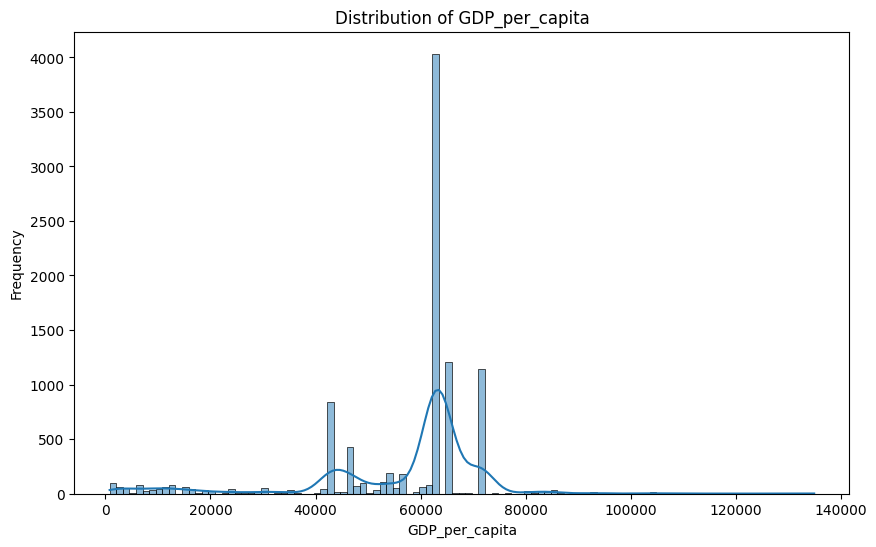

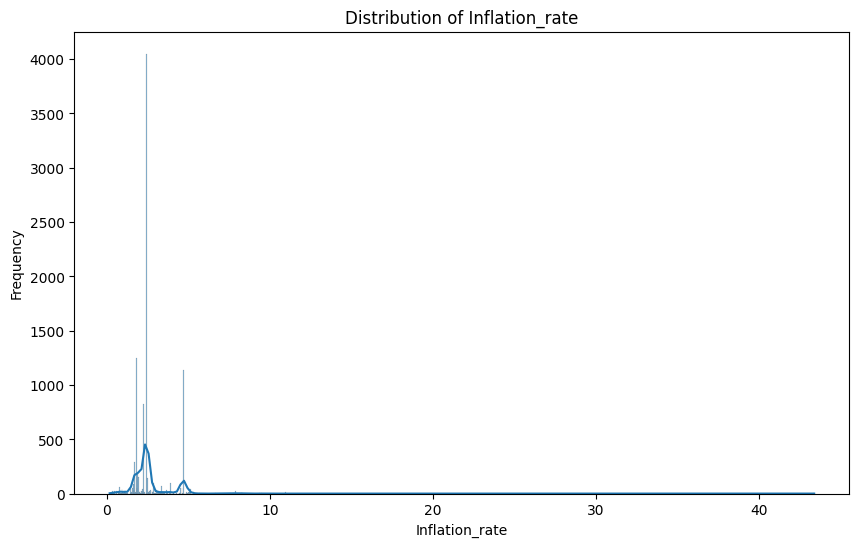

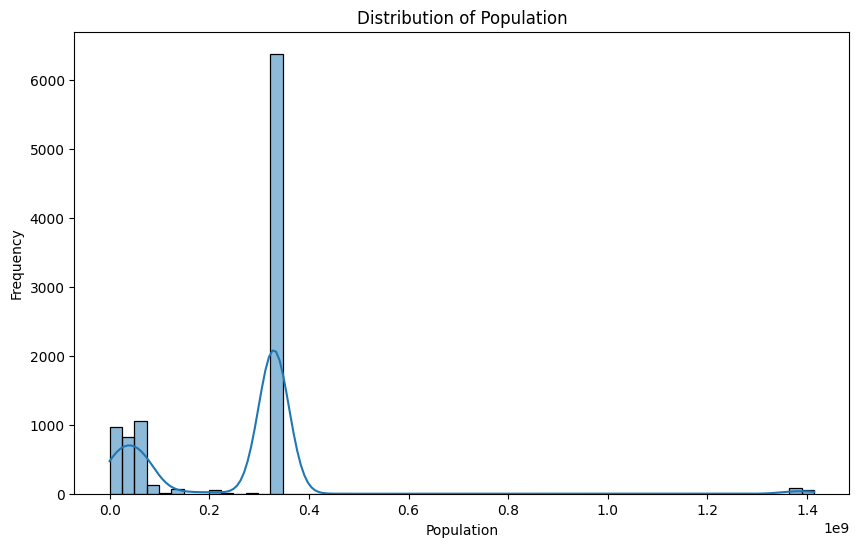

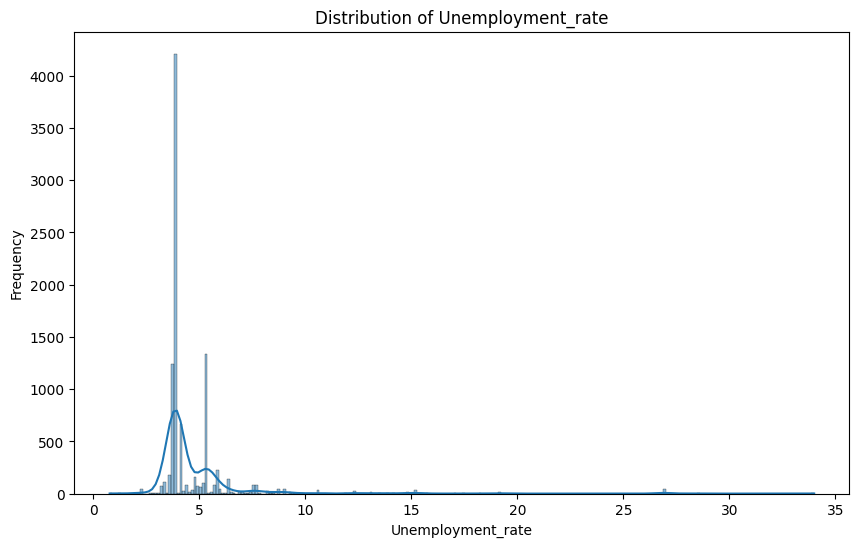

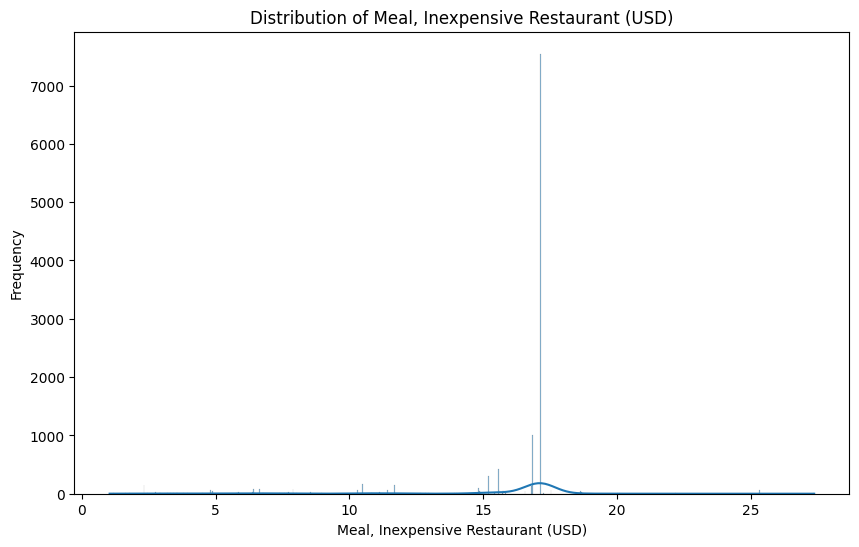

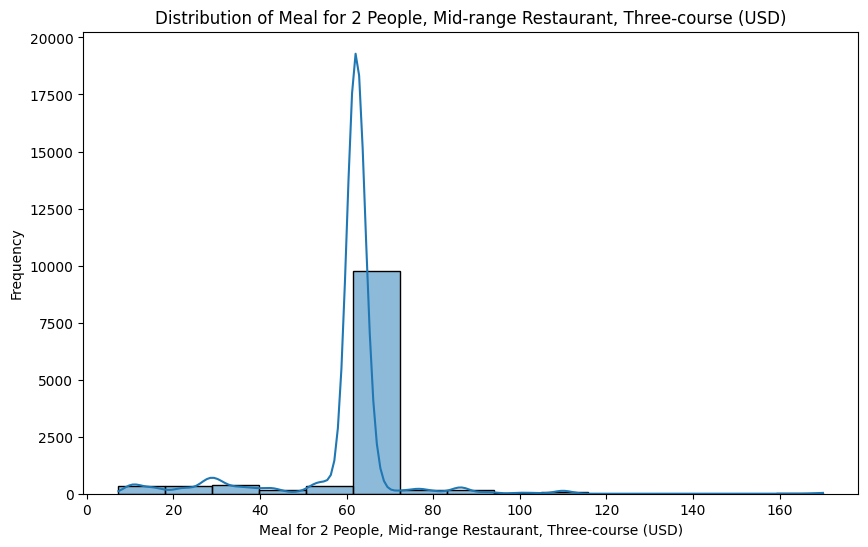

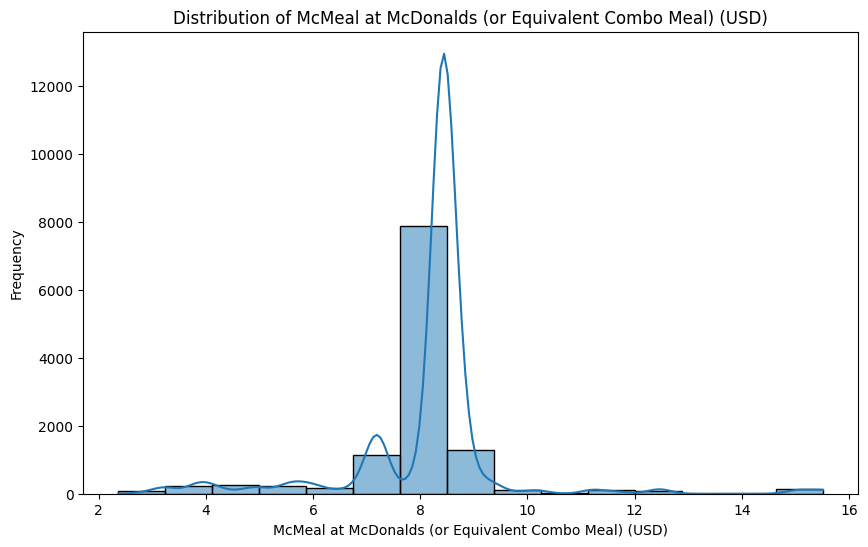

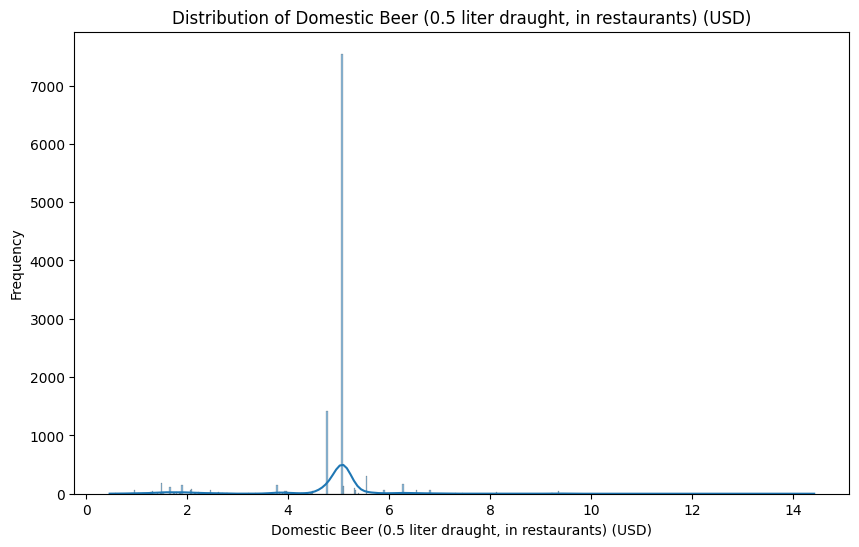

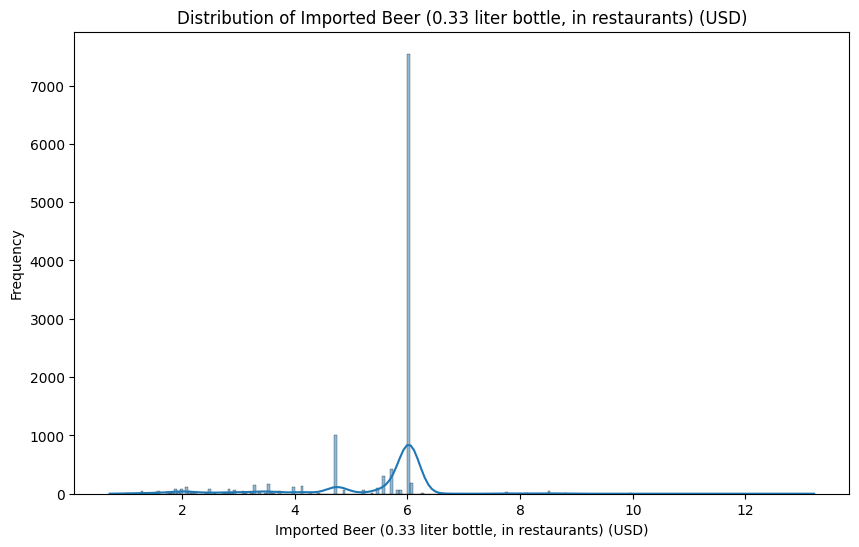

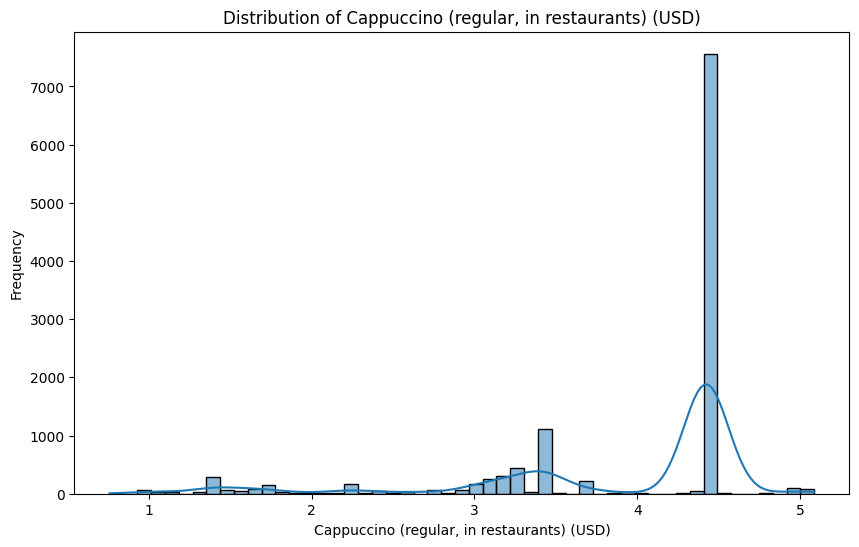

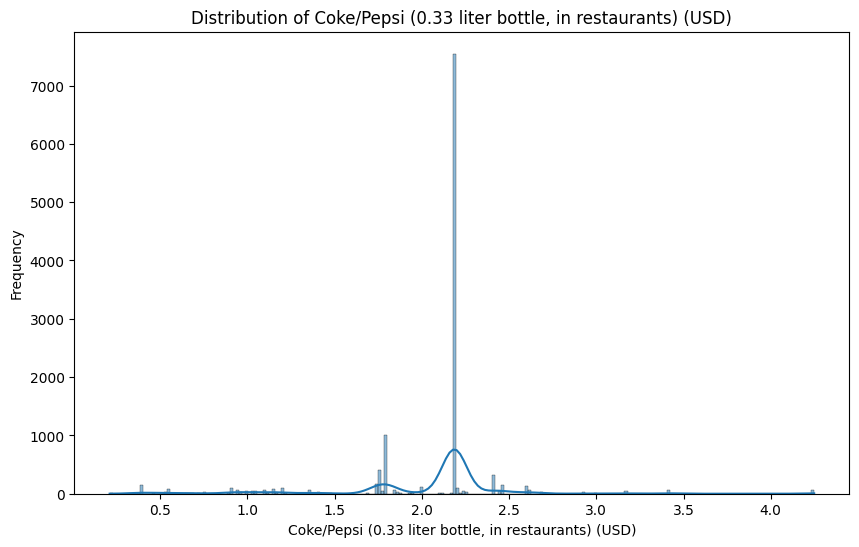

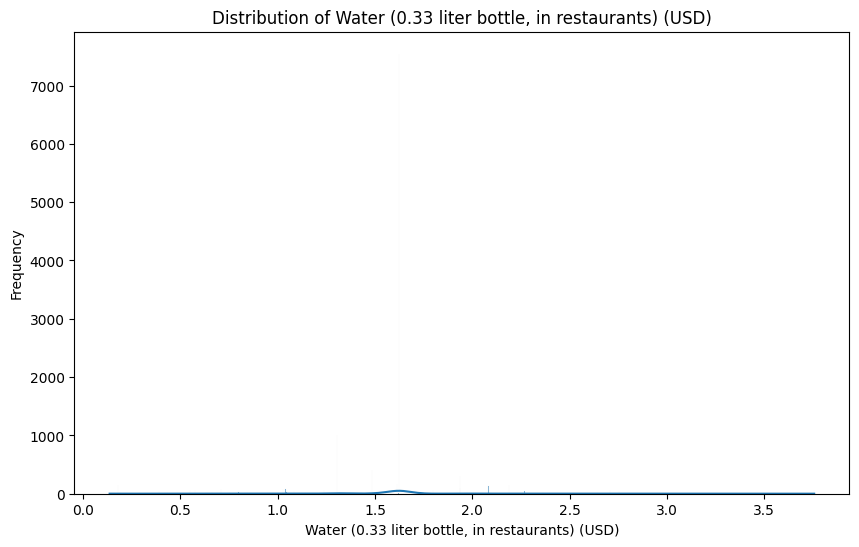

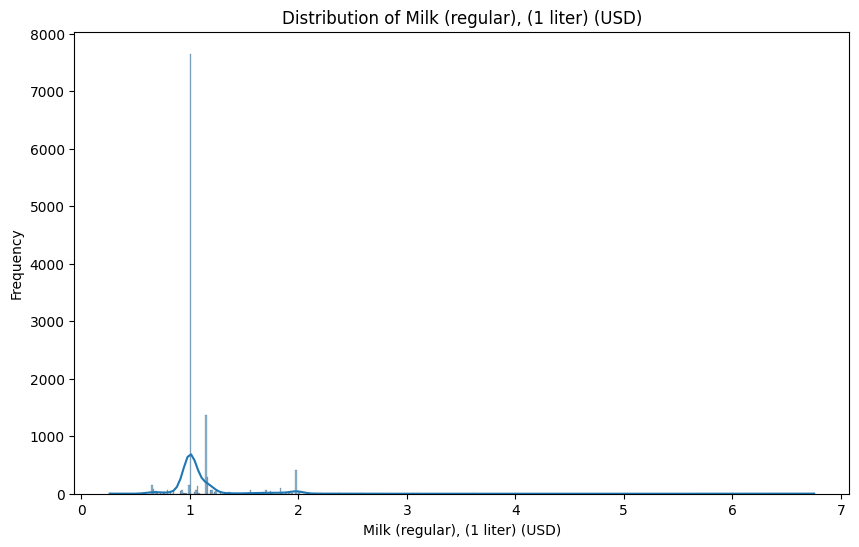

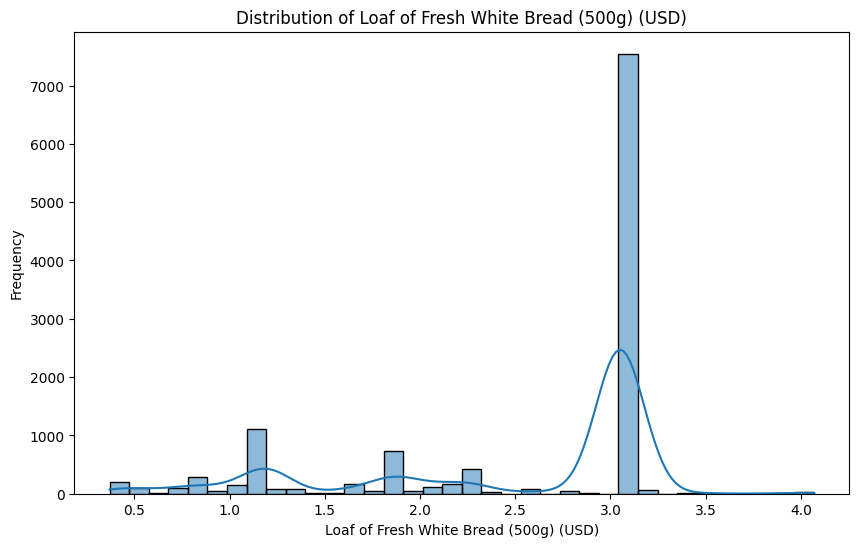

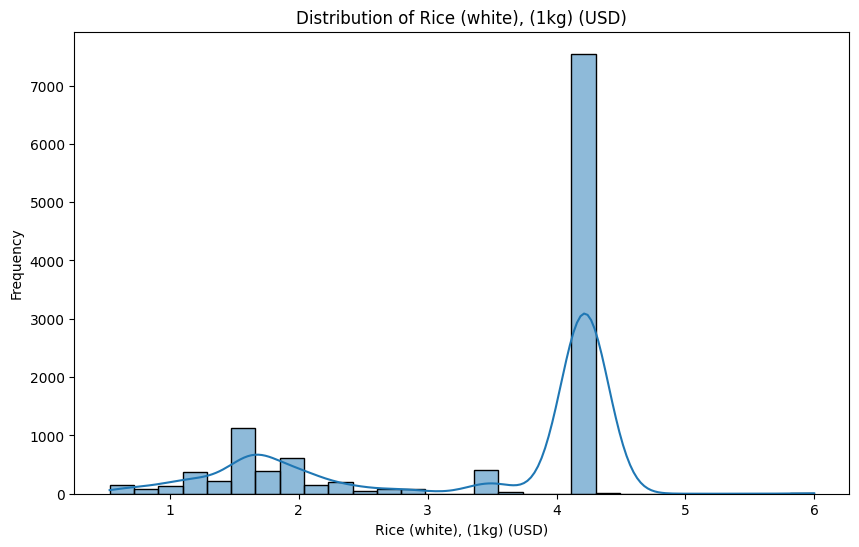

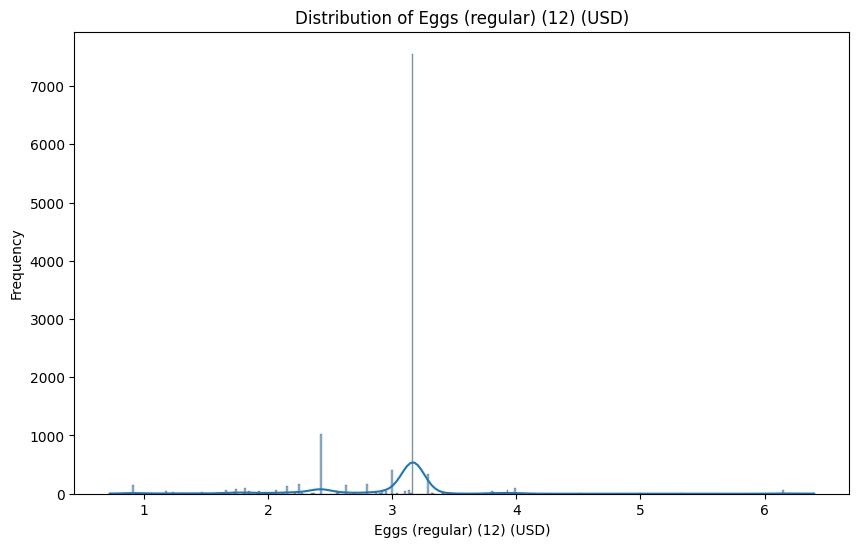

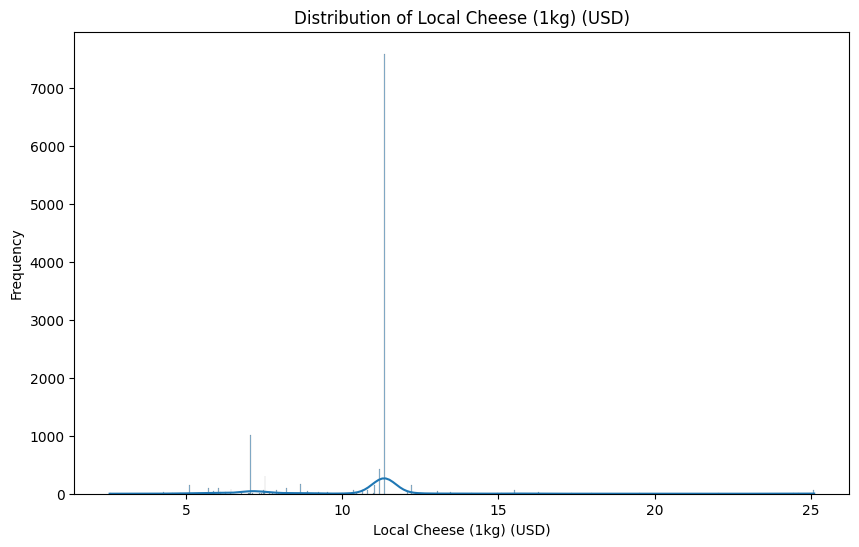

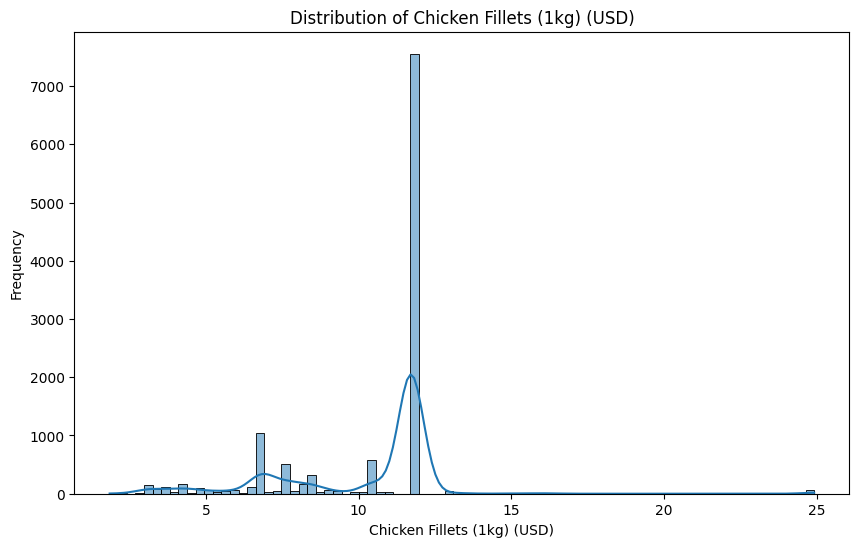

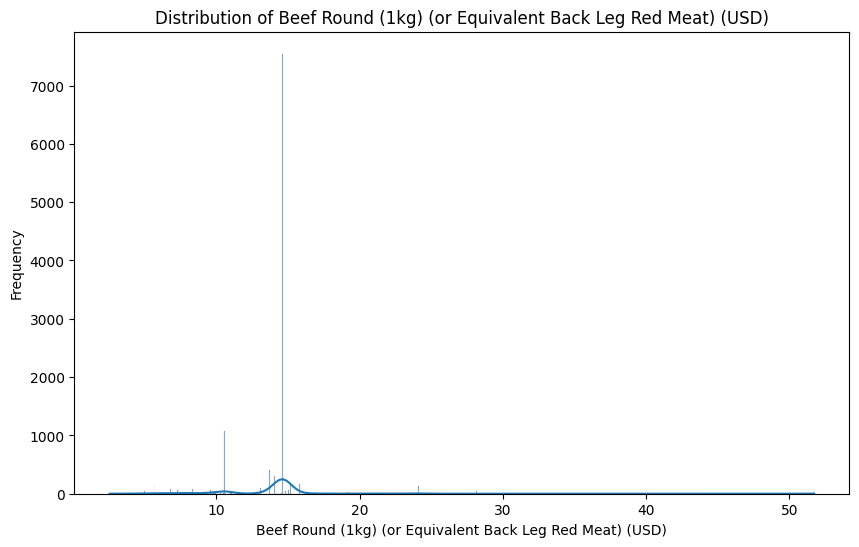

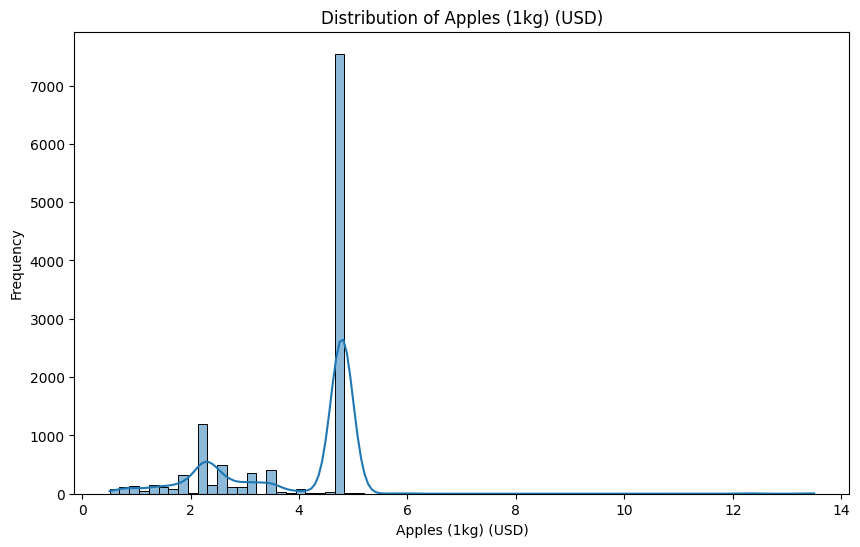

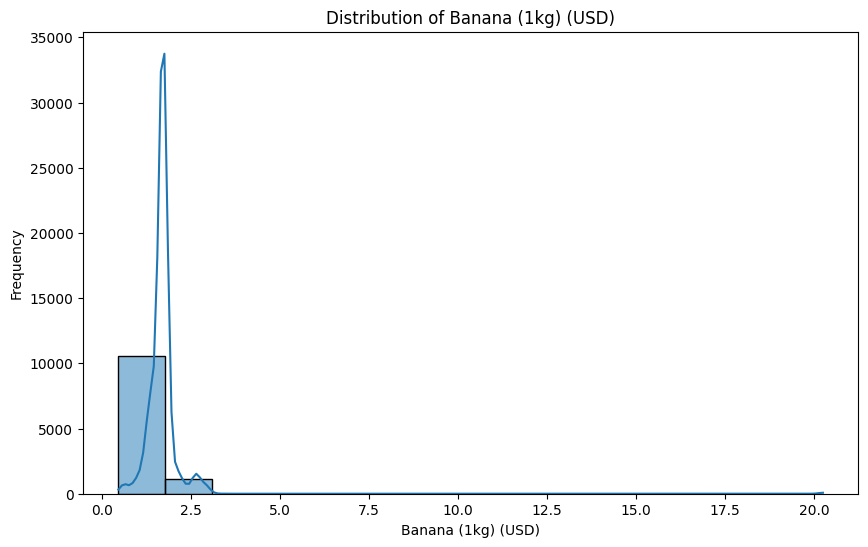

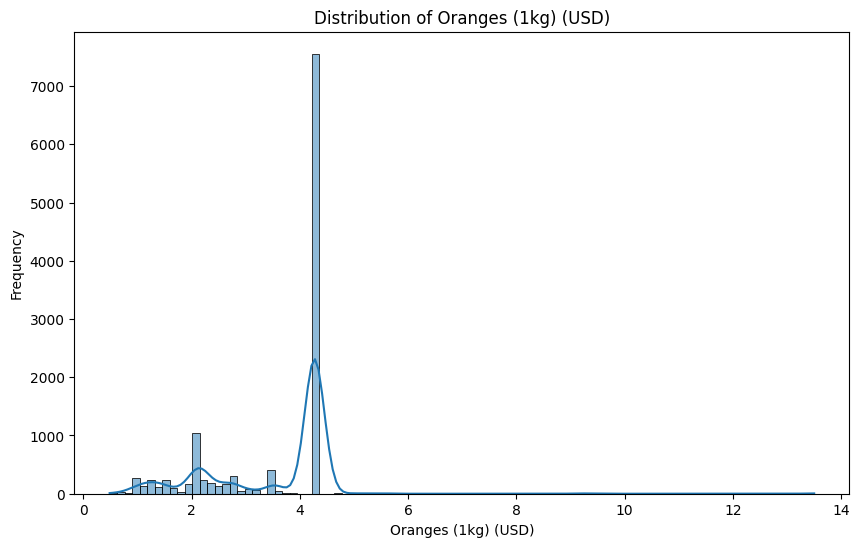

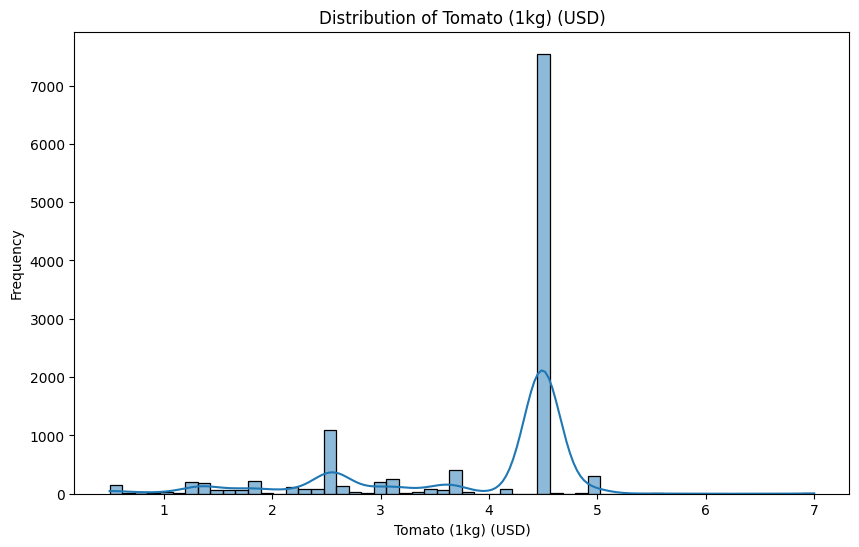

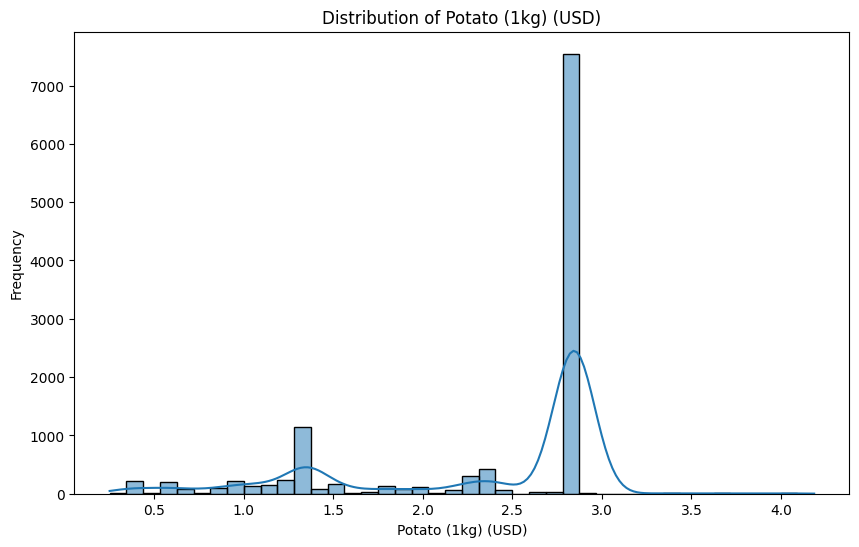

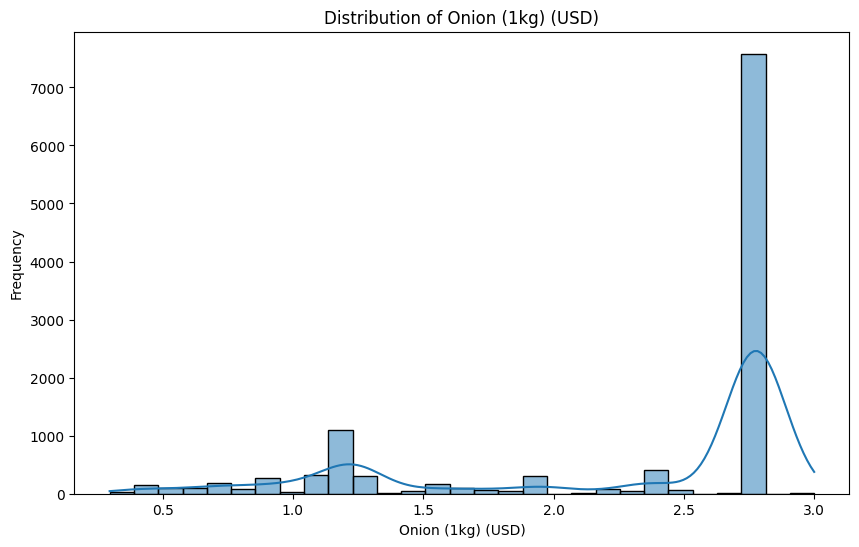

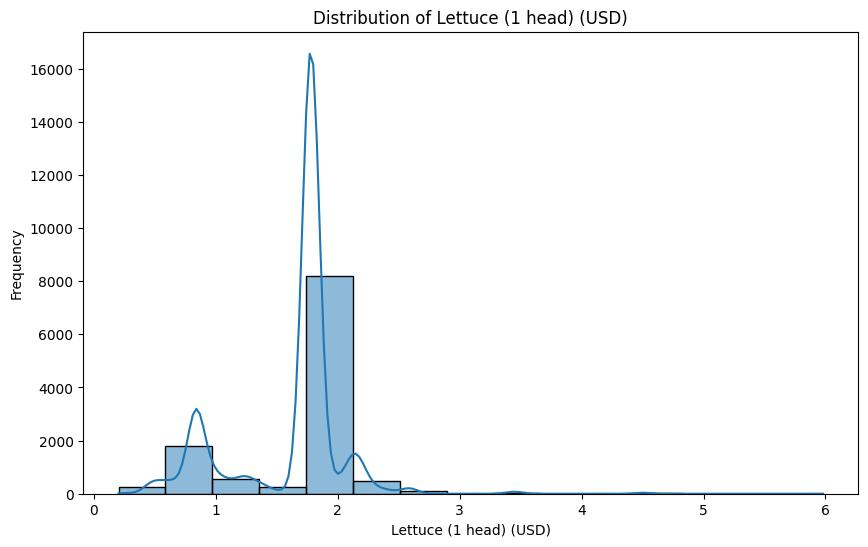

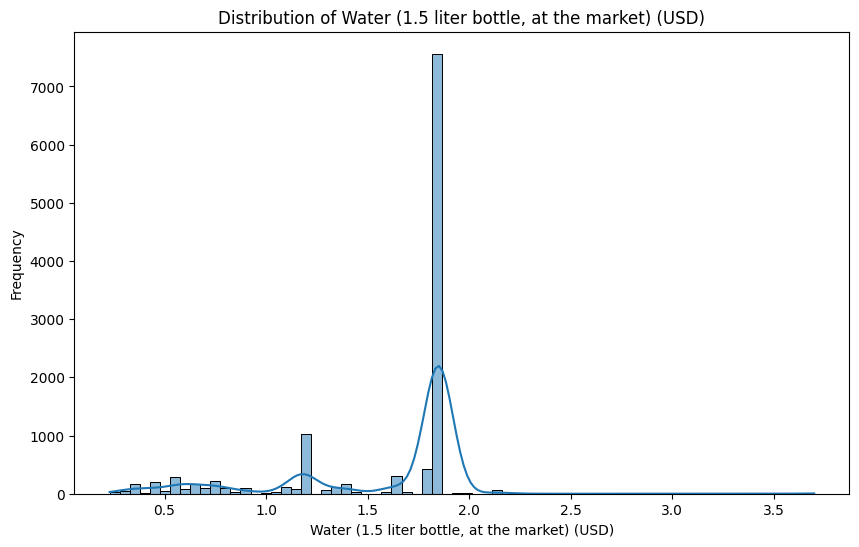

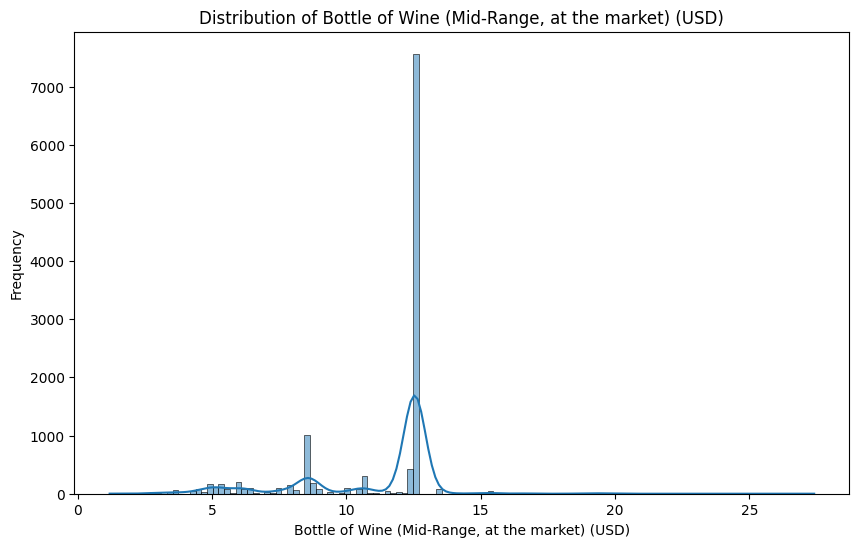

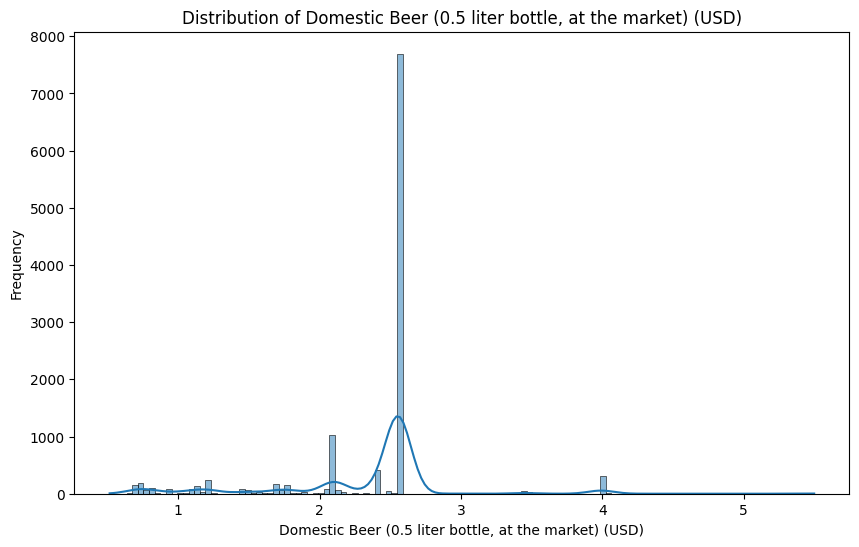

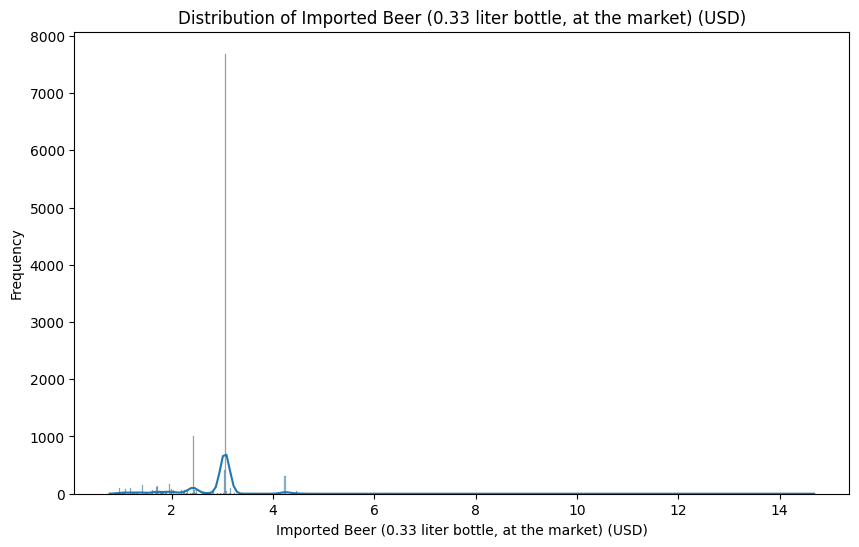

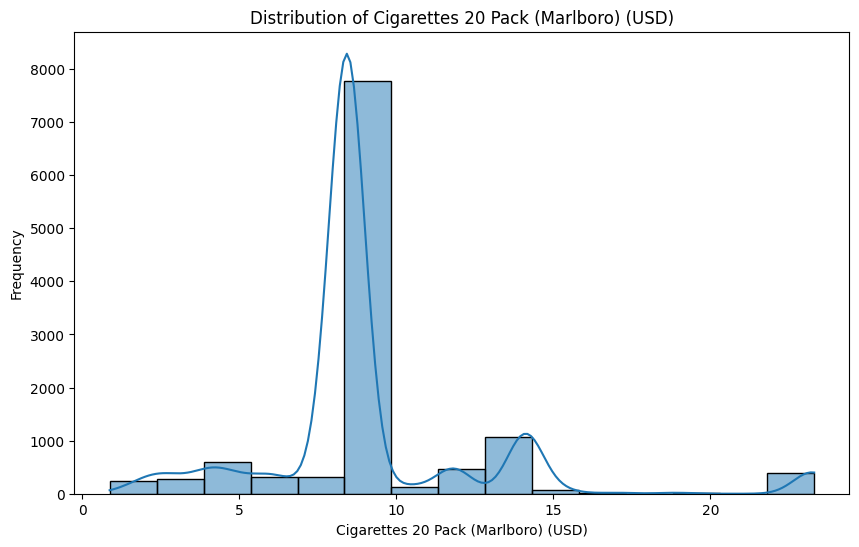

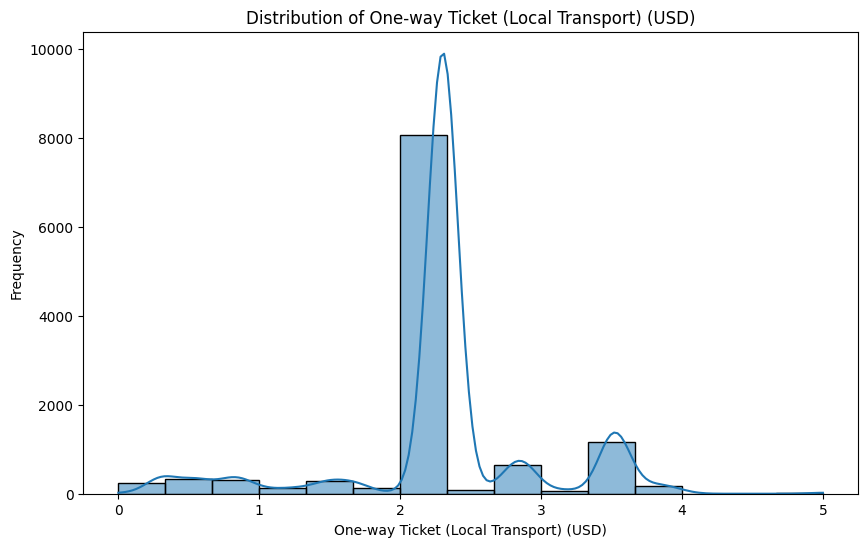

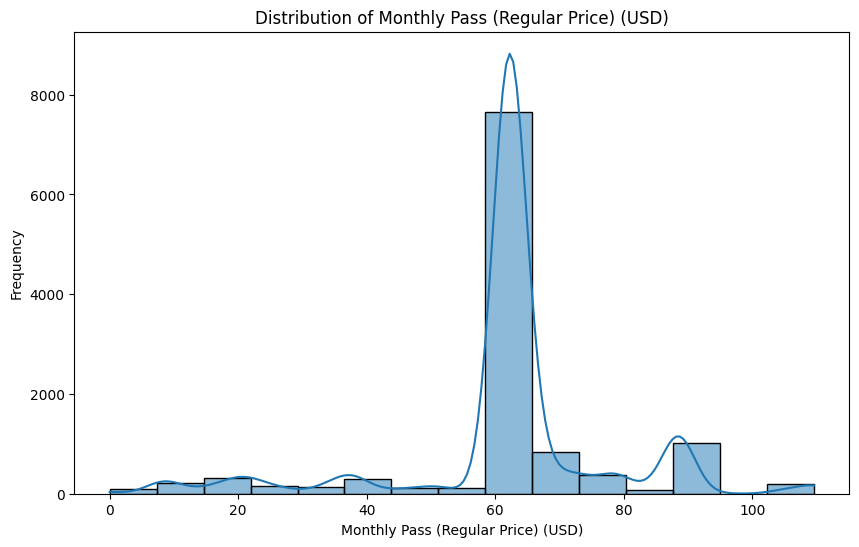

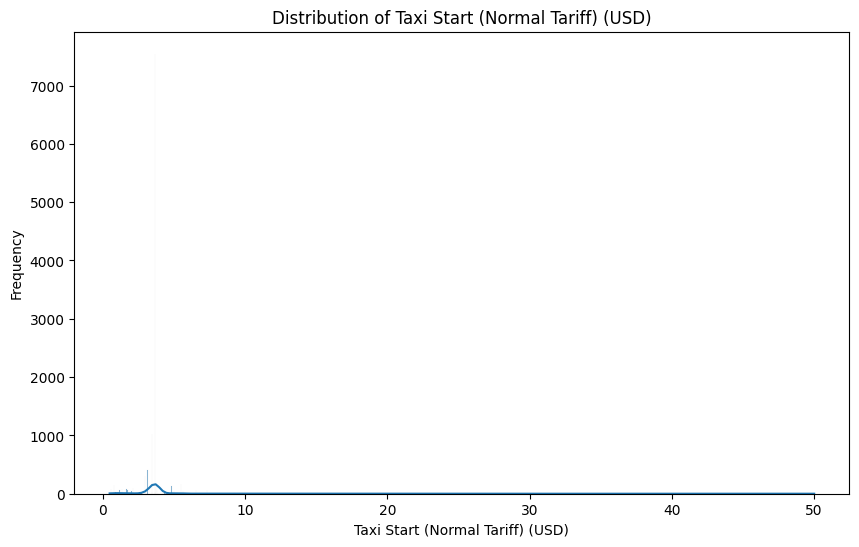

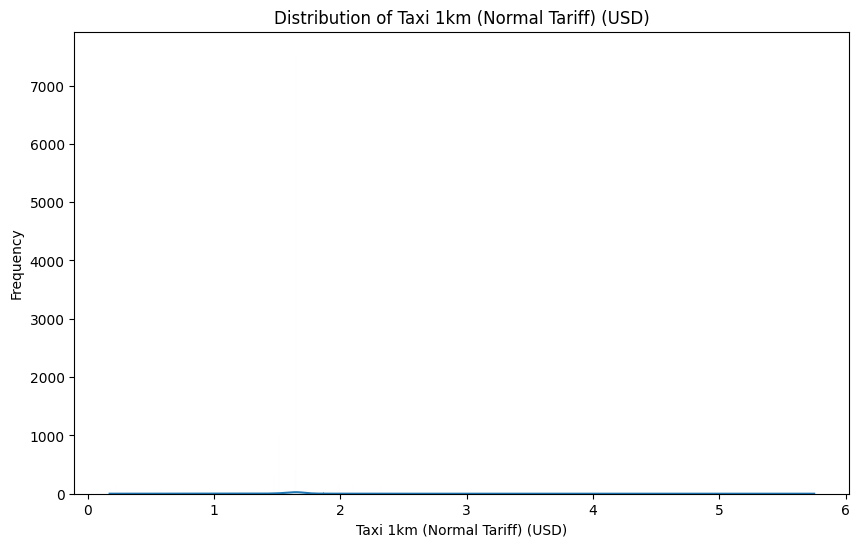

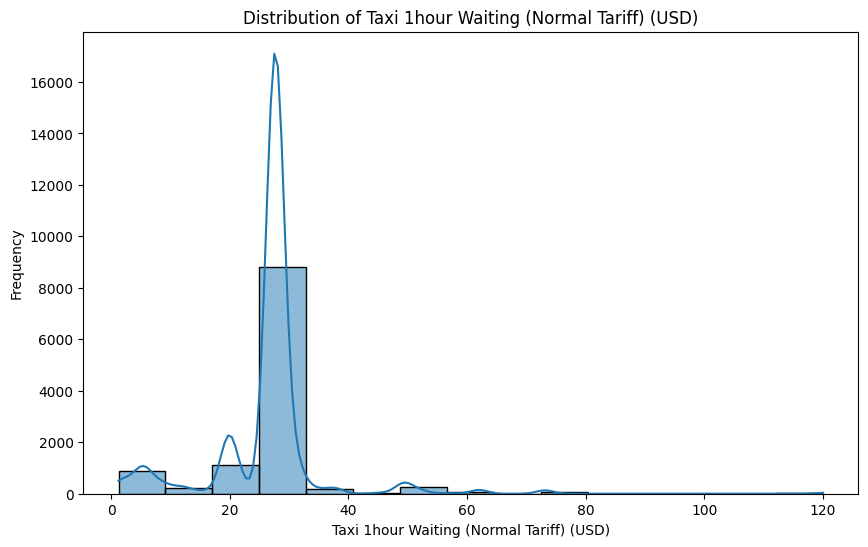

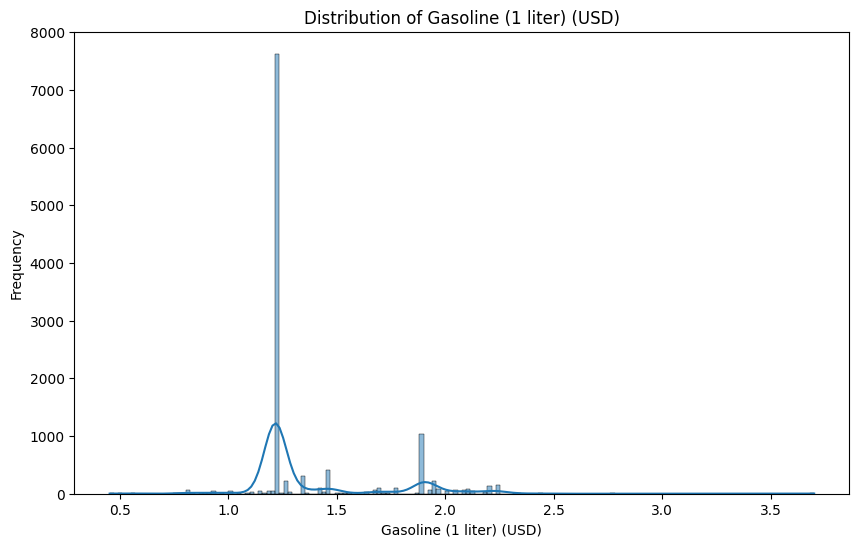

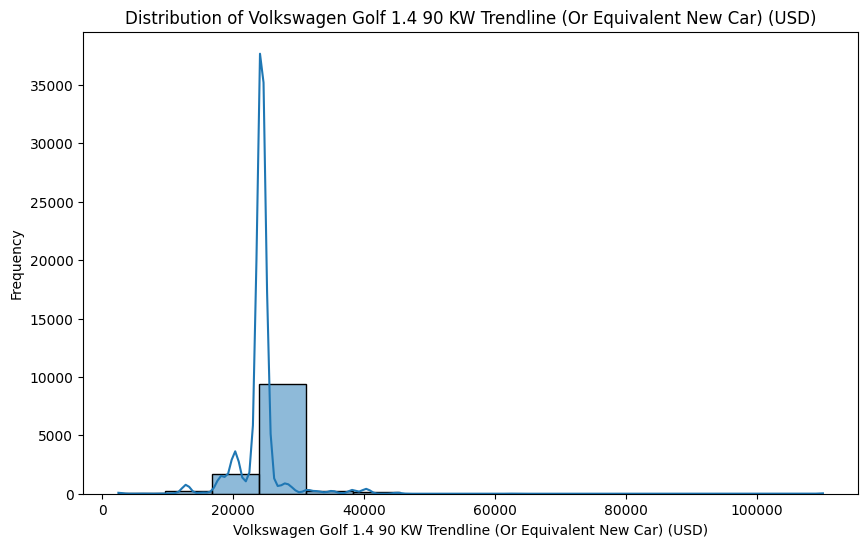

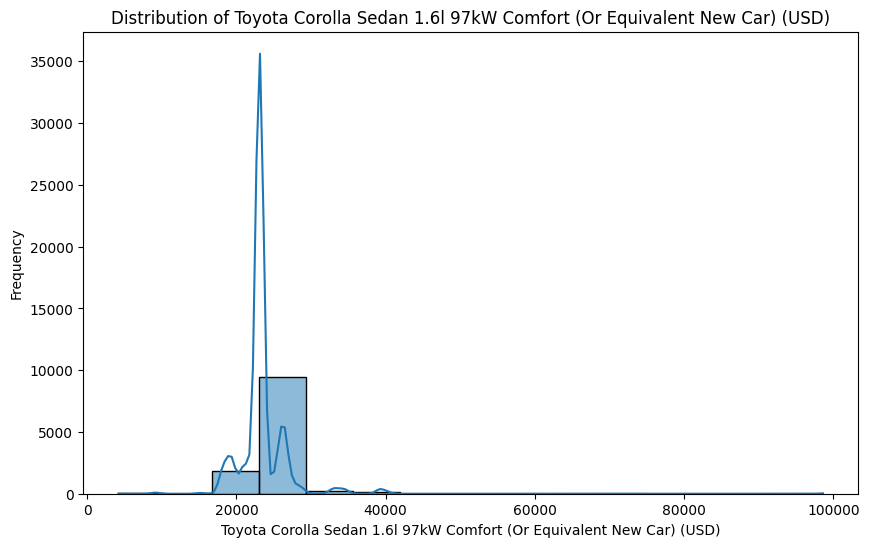

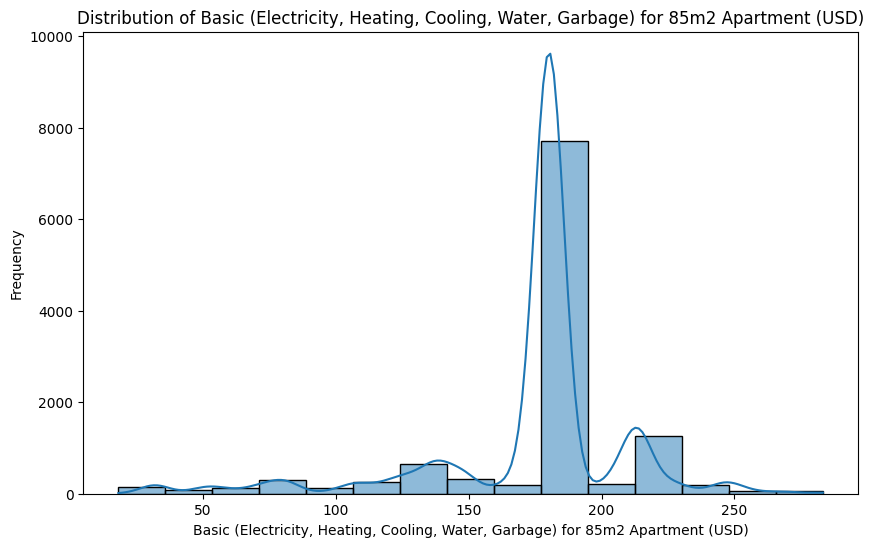

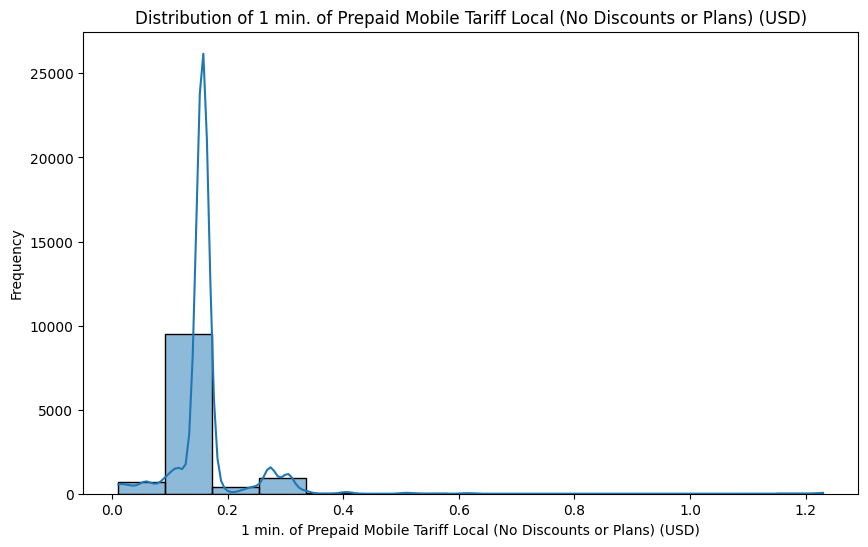

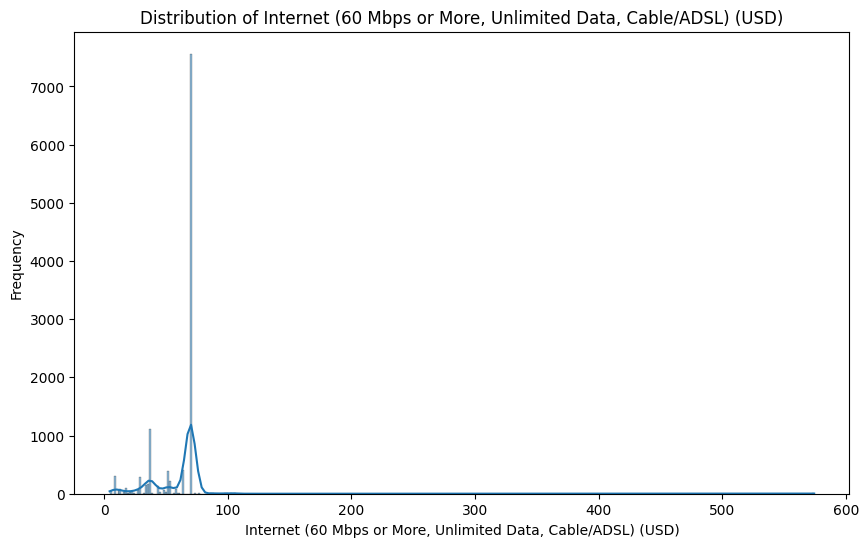

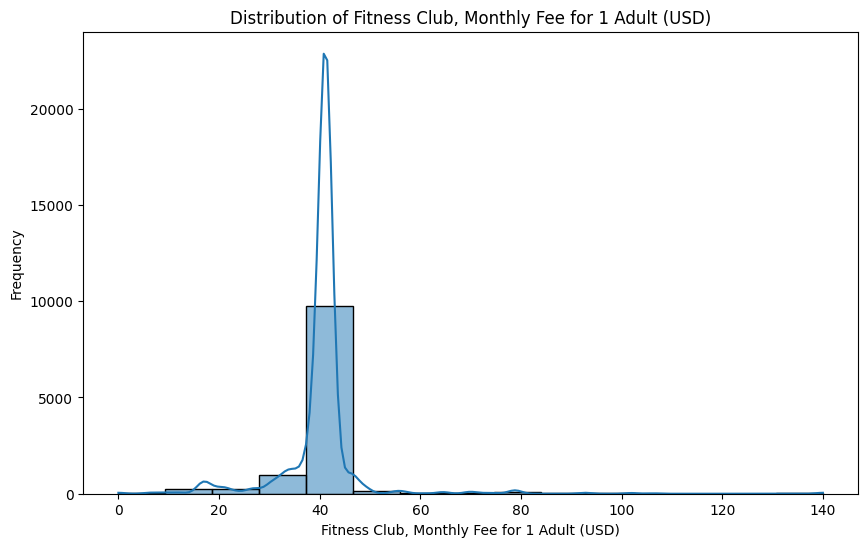

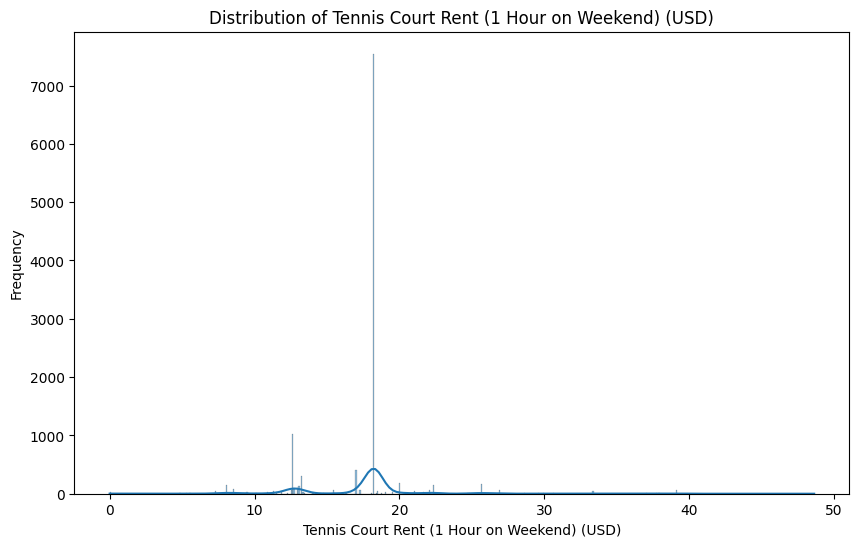

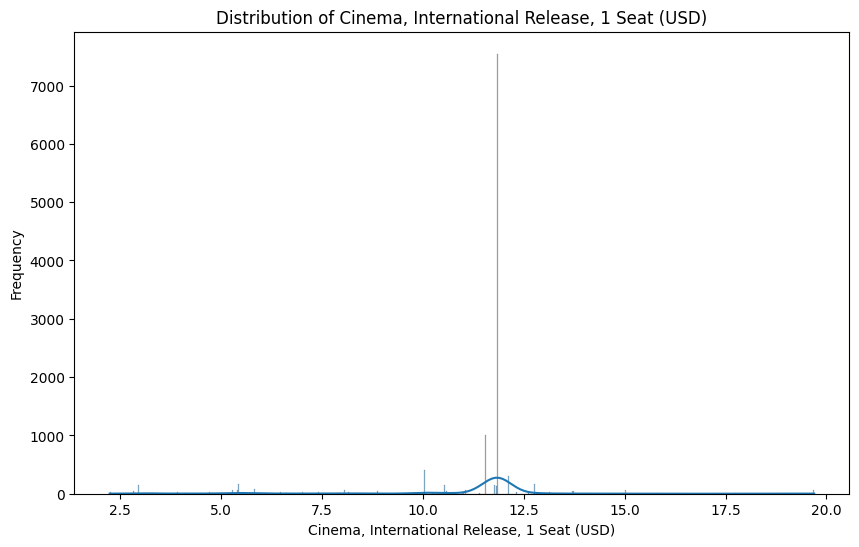

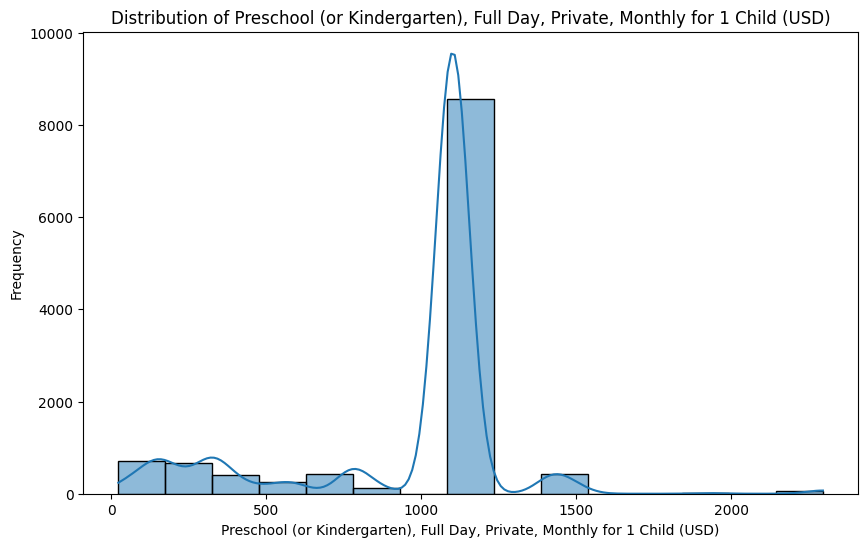

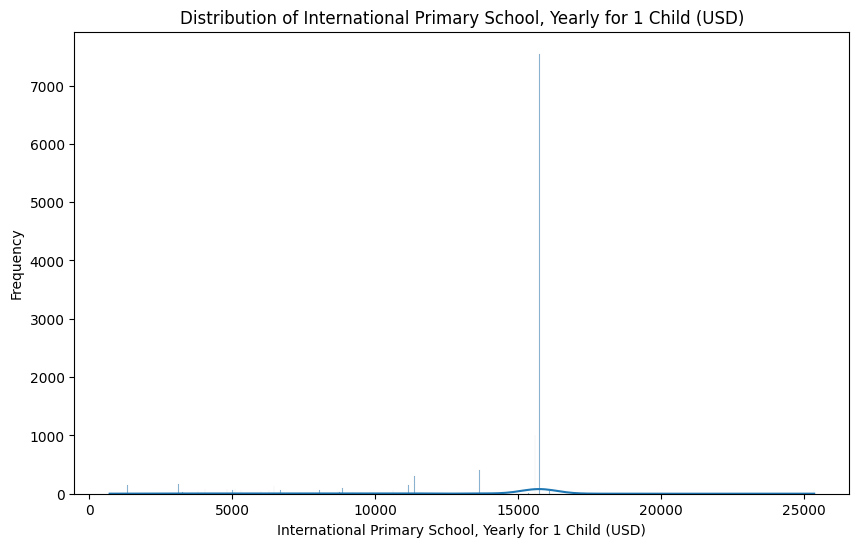

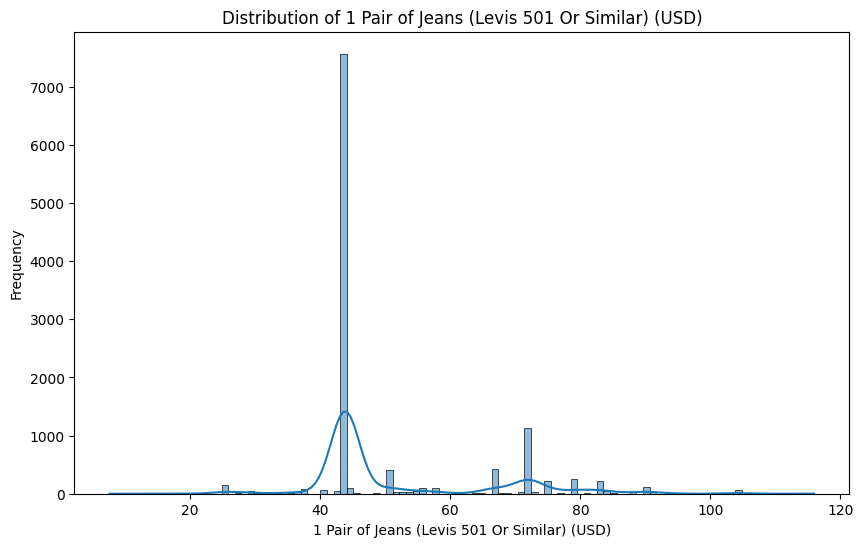

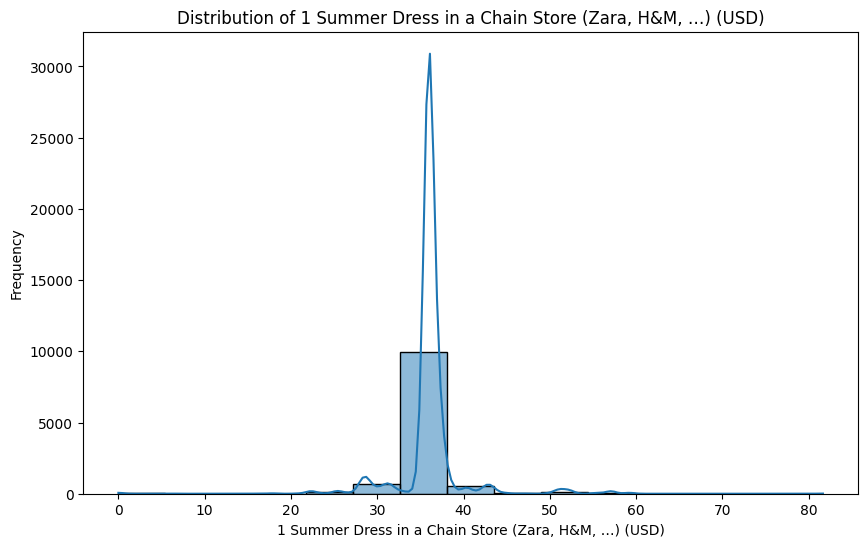

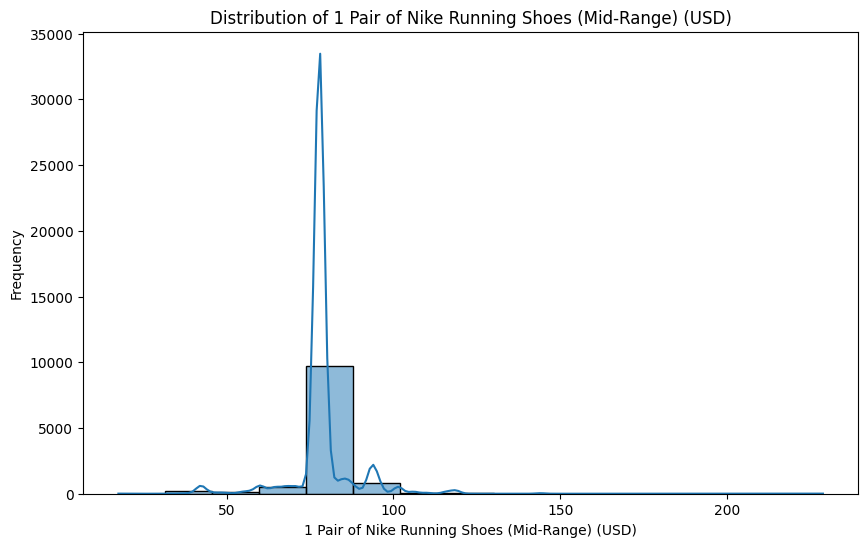

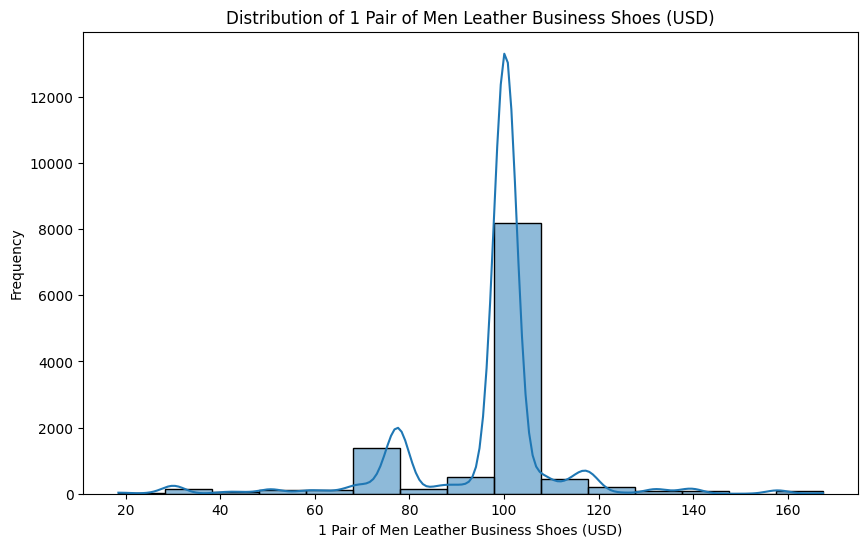

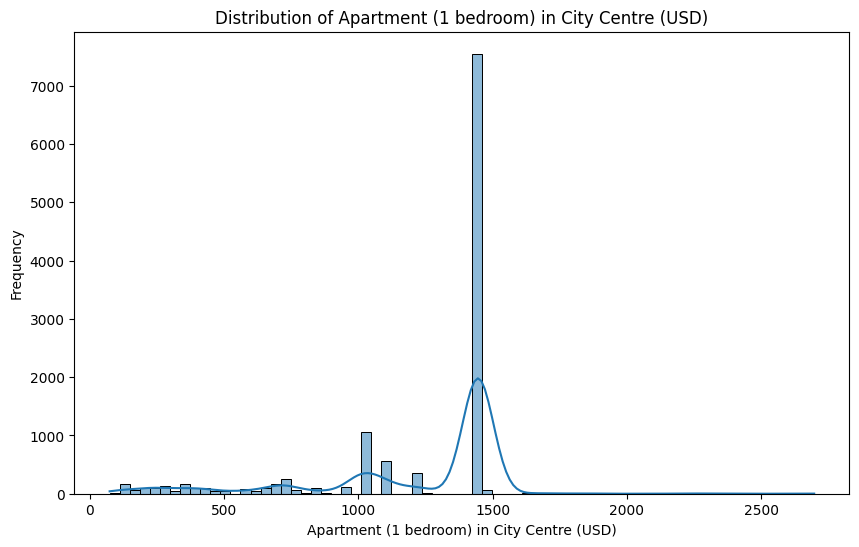

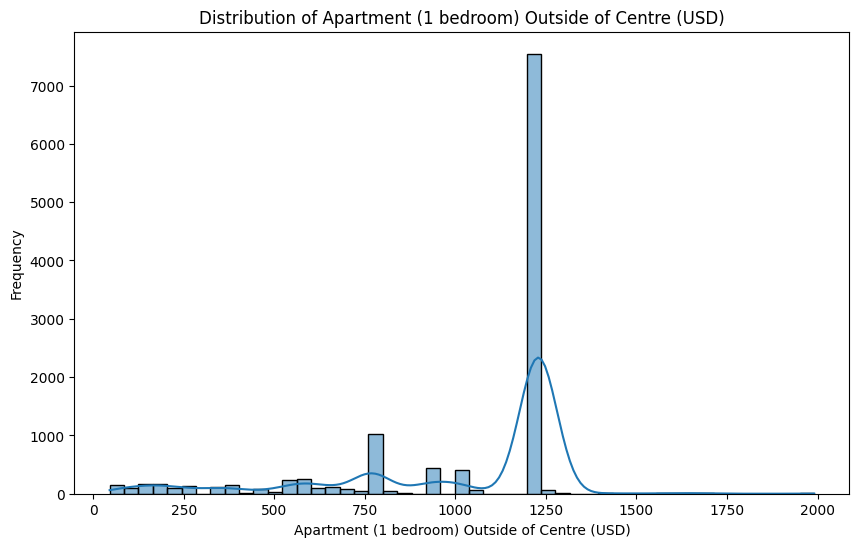

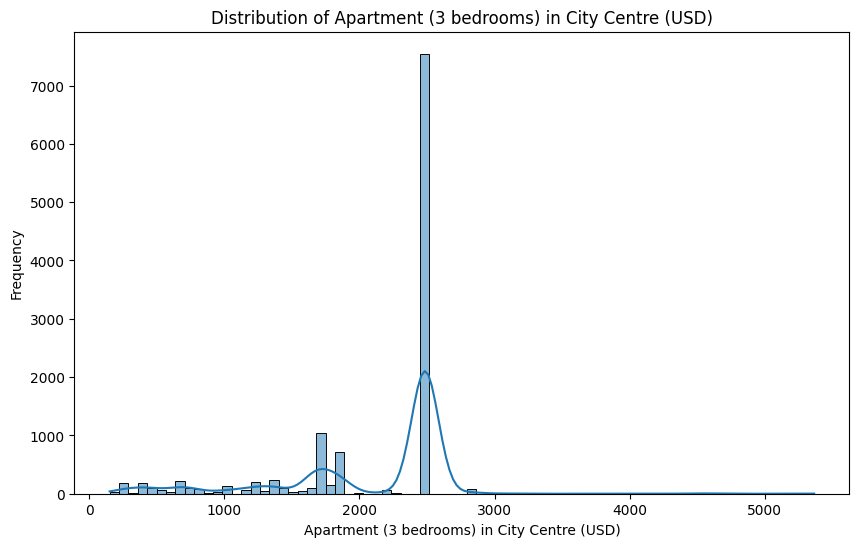

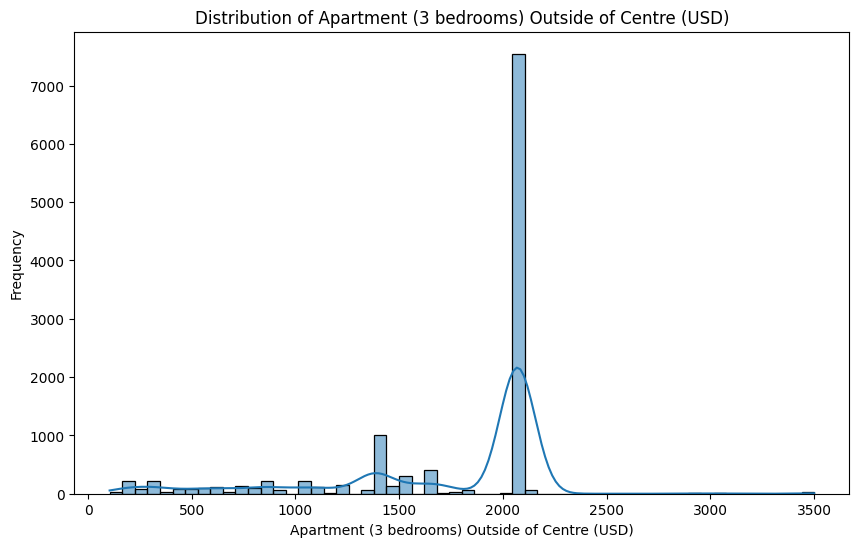

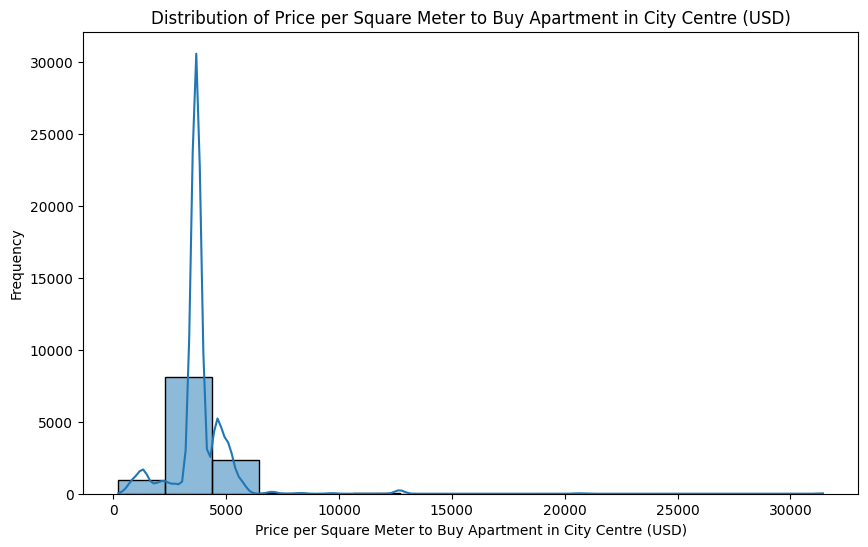

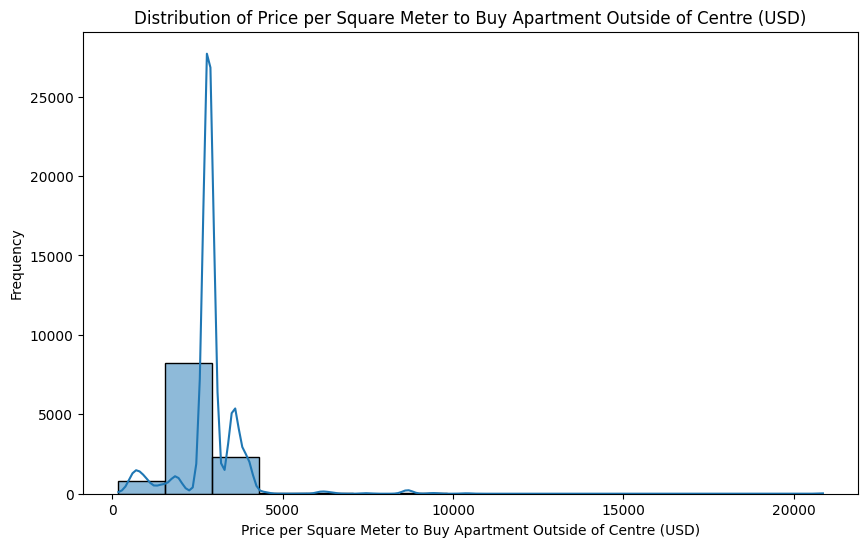

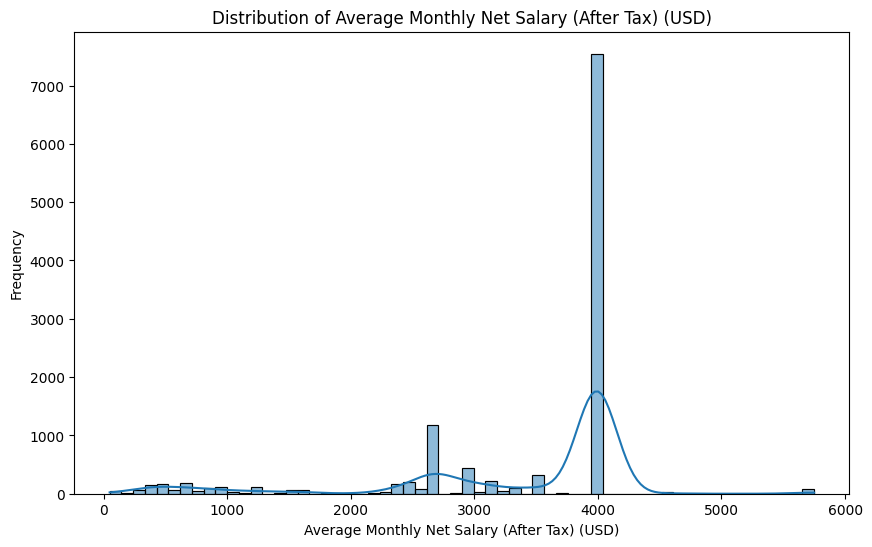

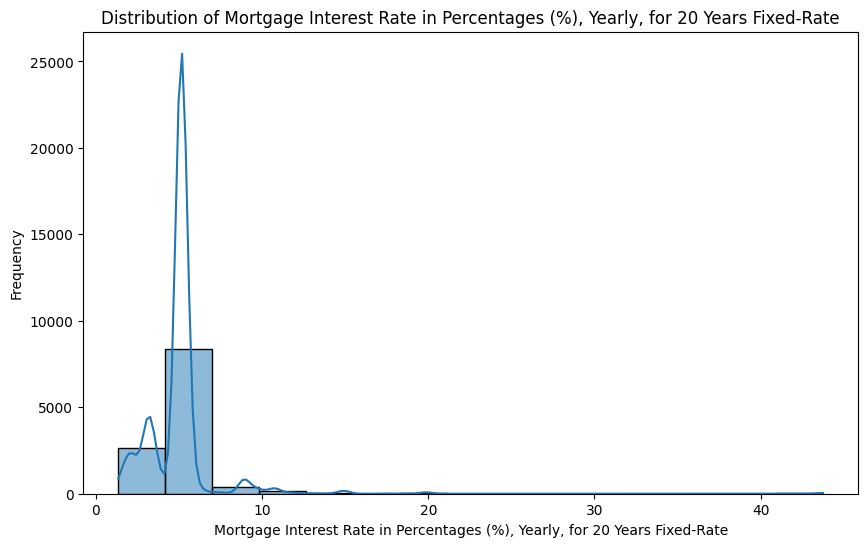

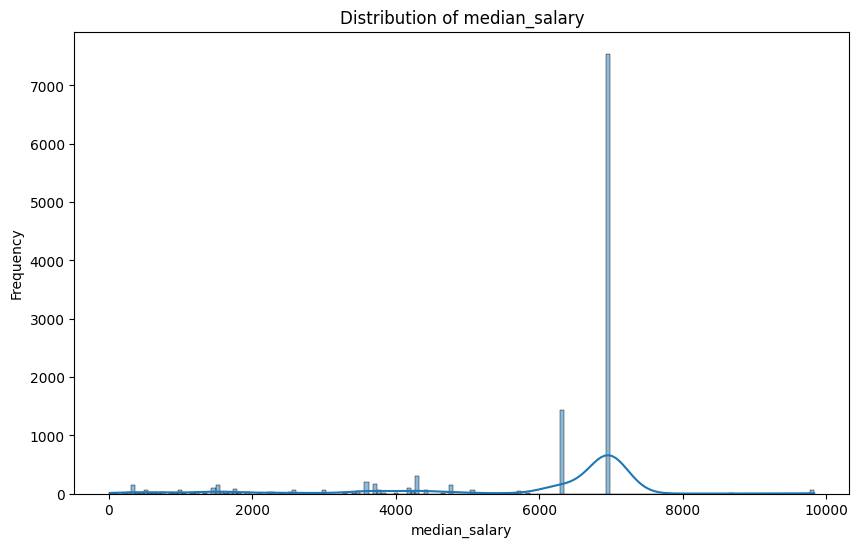

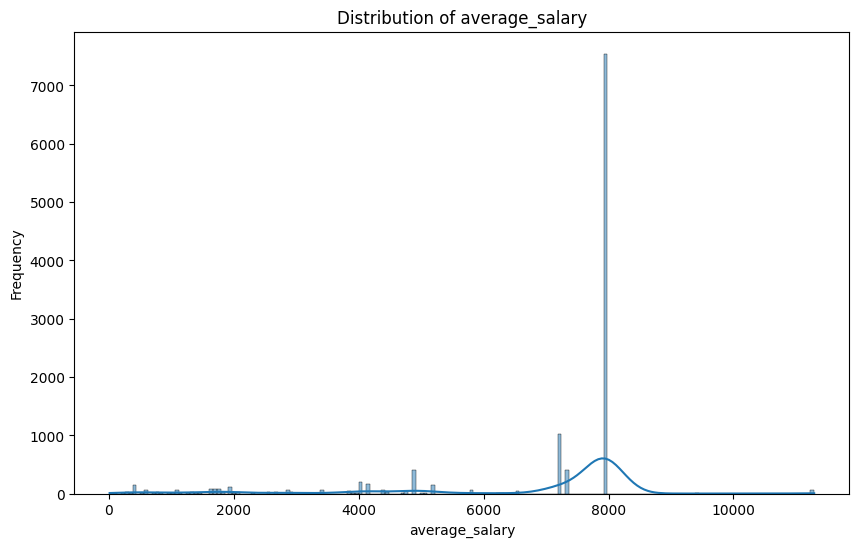

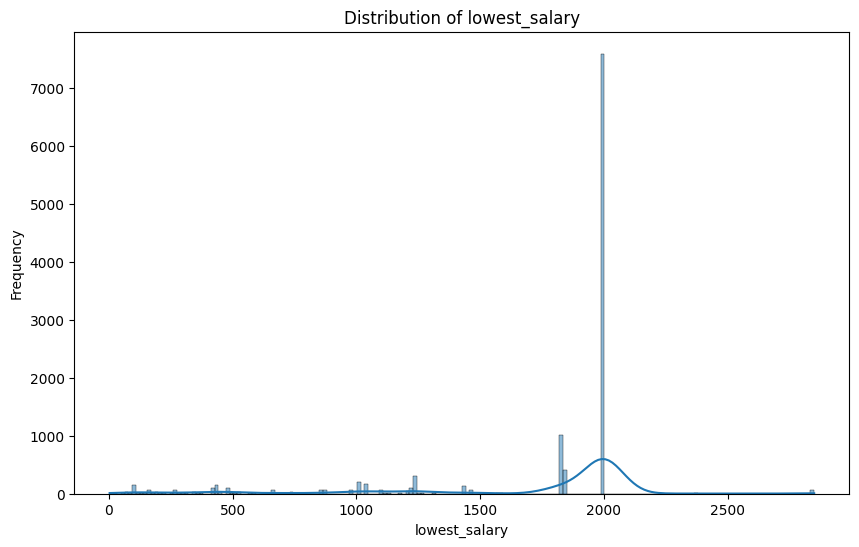

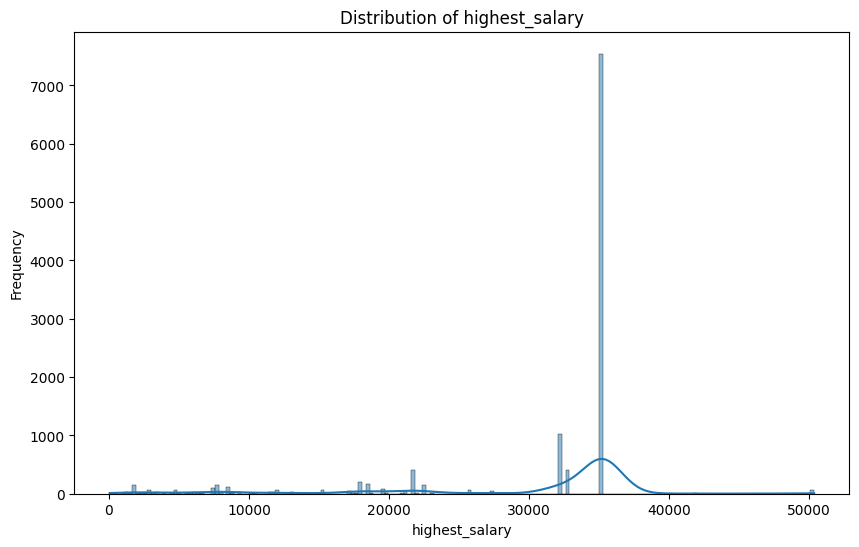

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identifying numerical columns (excluding the target variable and potential identifiers)
numerical_cols = merged_all_features_final.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols.remove('SalaryUSD')
if 'Survey Year' in numerical_cols:
    numerical_cols.remove('Survey Year')


print("Visualizing distributions of numerical features (excluding SalaryUSD and Survey Year):")

# Plotting histograms for numerical features
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=merged_all_features_final, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Visualizing distributions of categorical features:


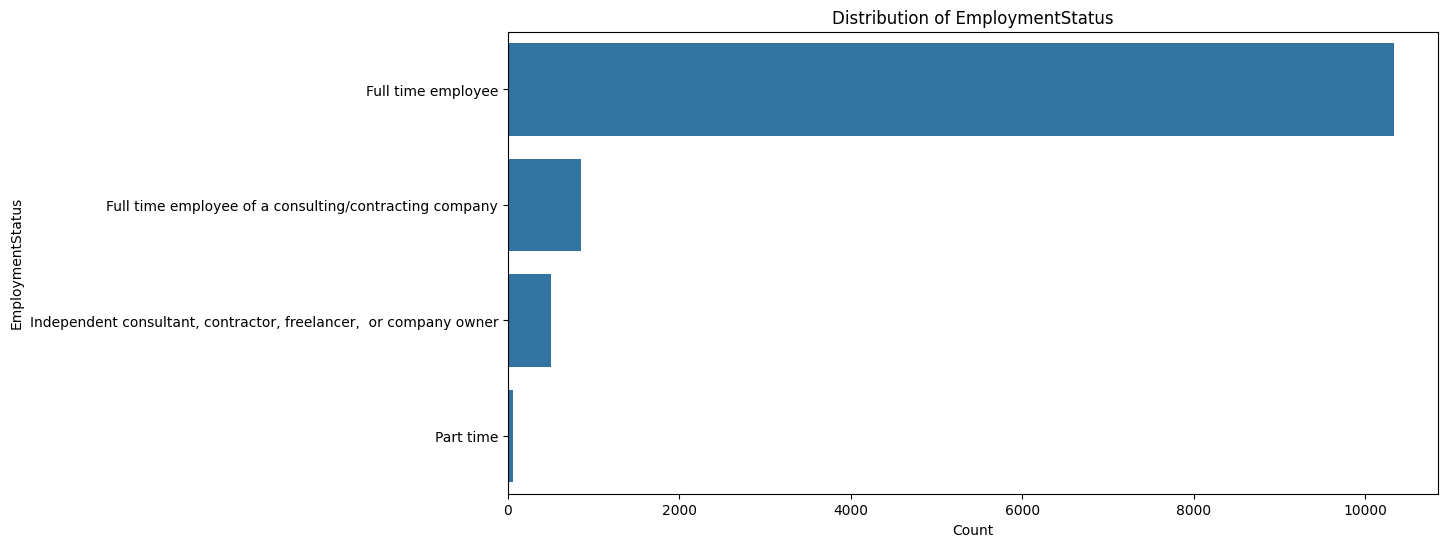

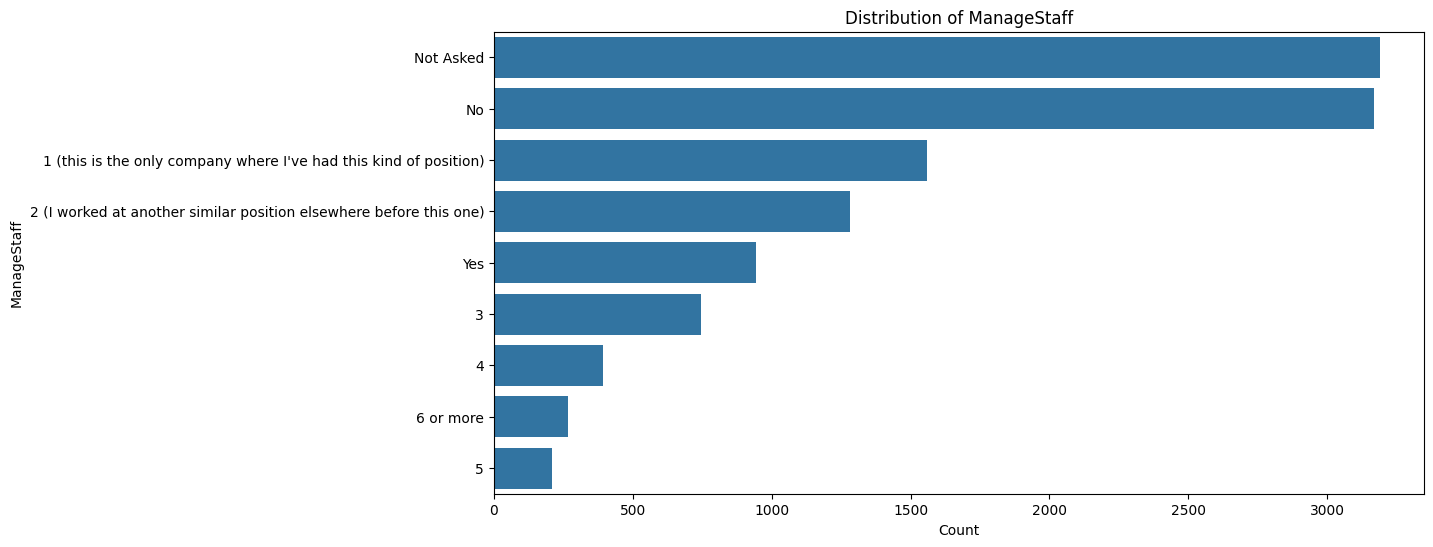

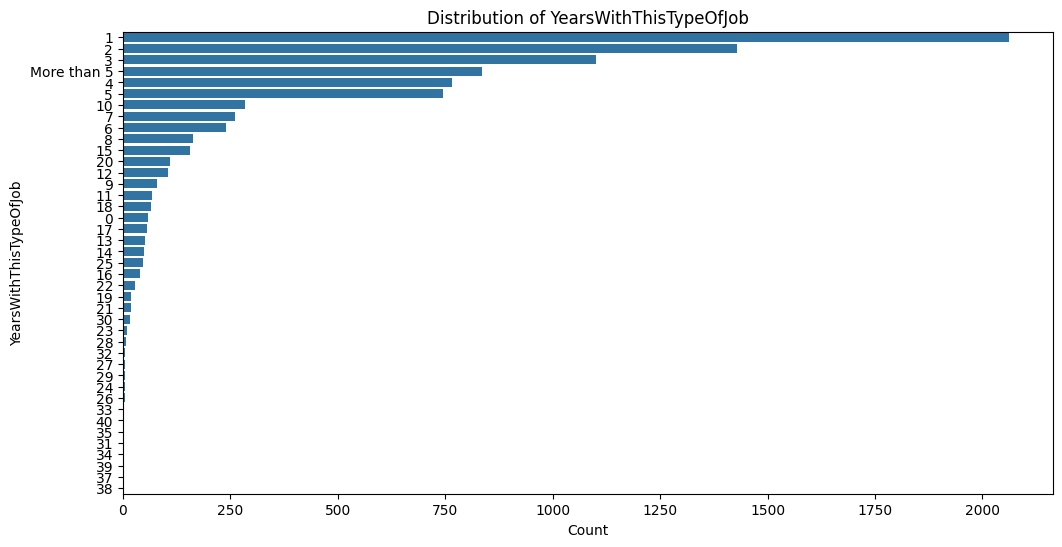

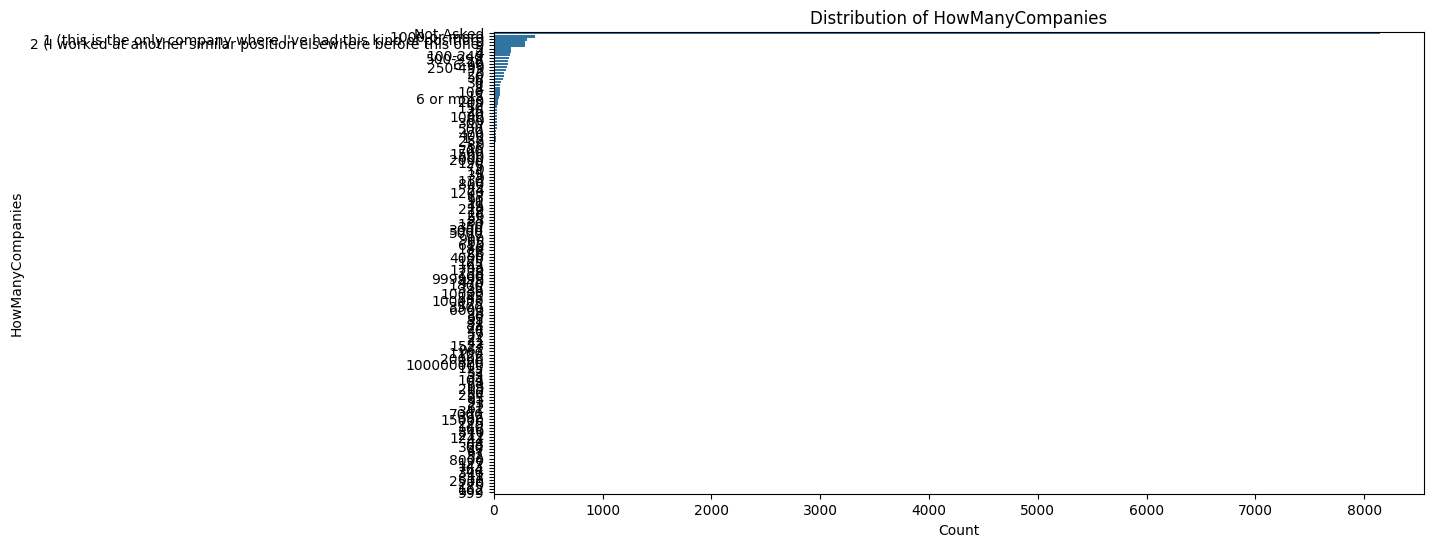

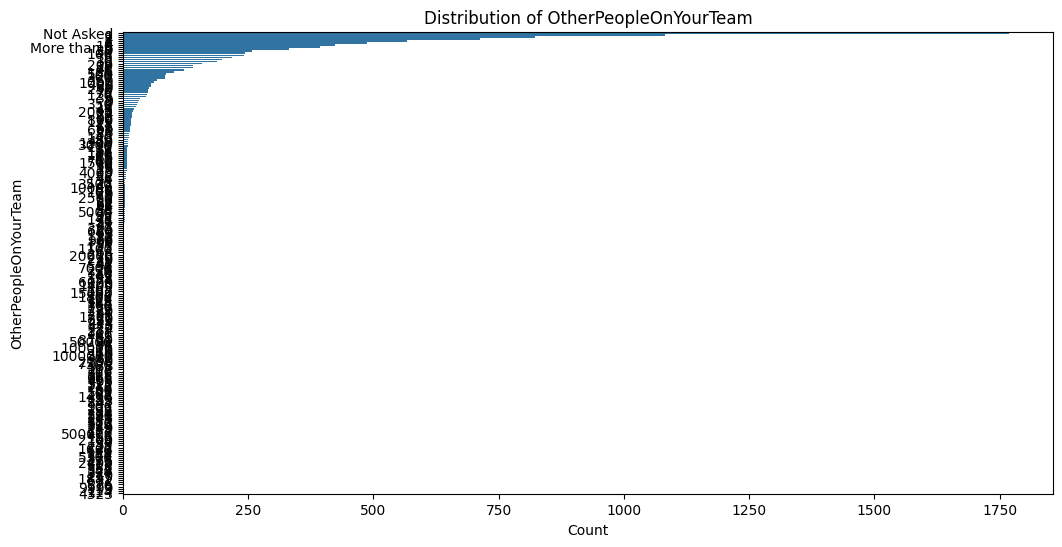

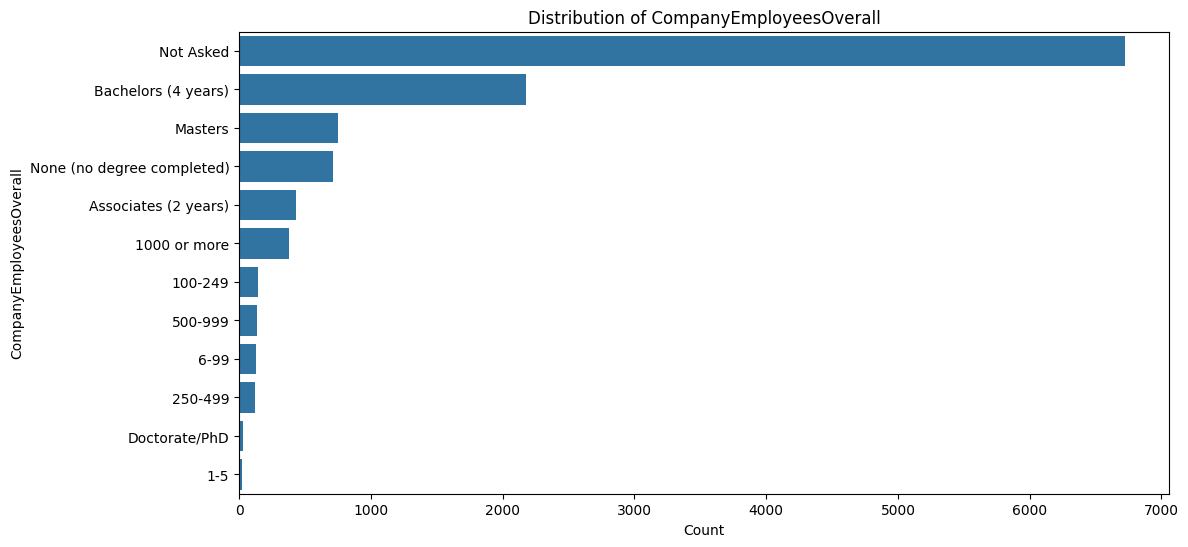

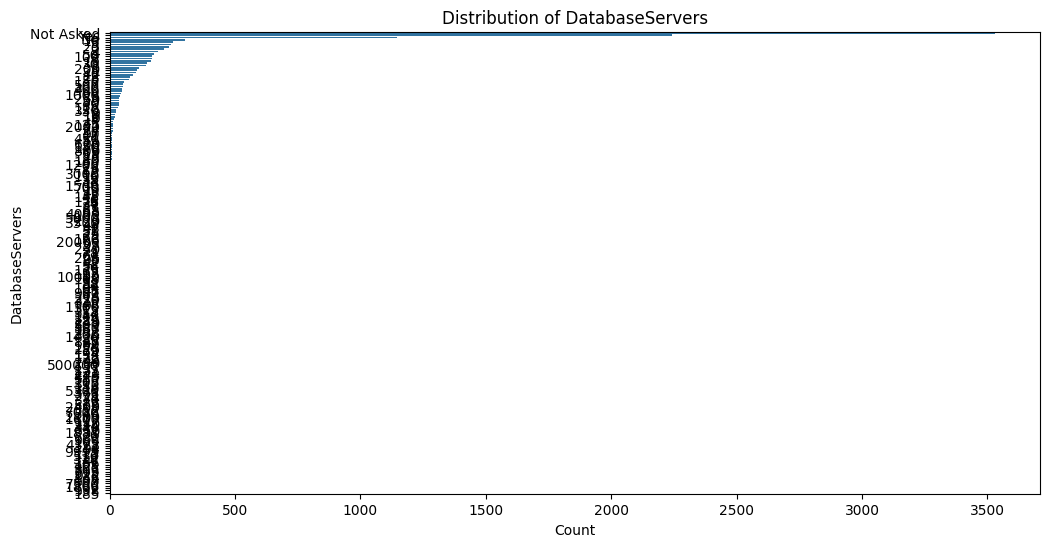

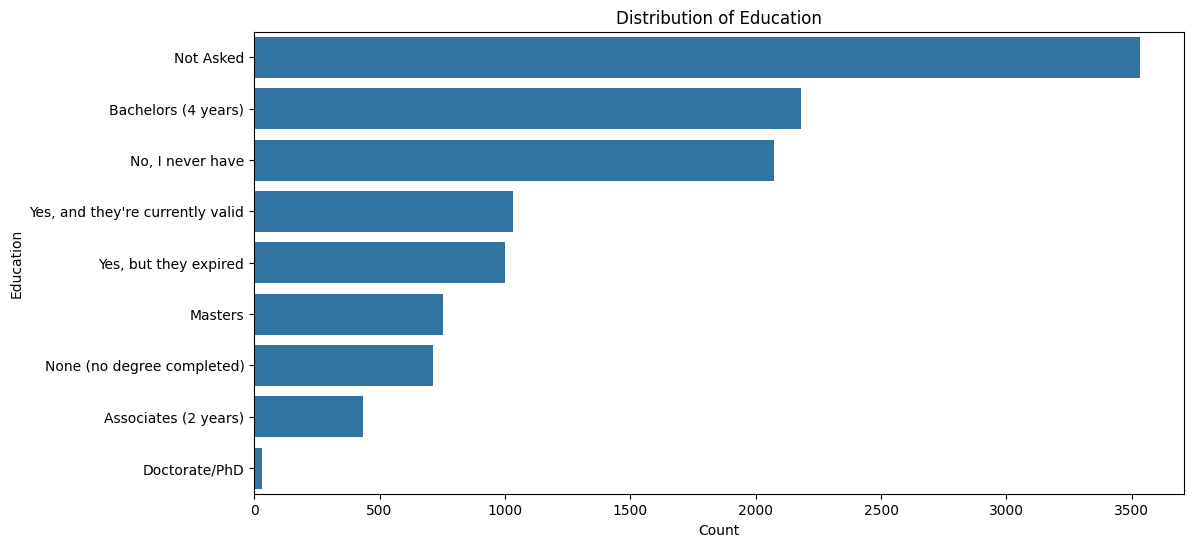

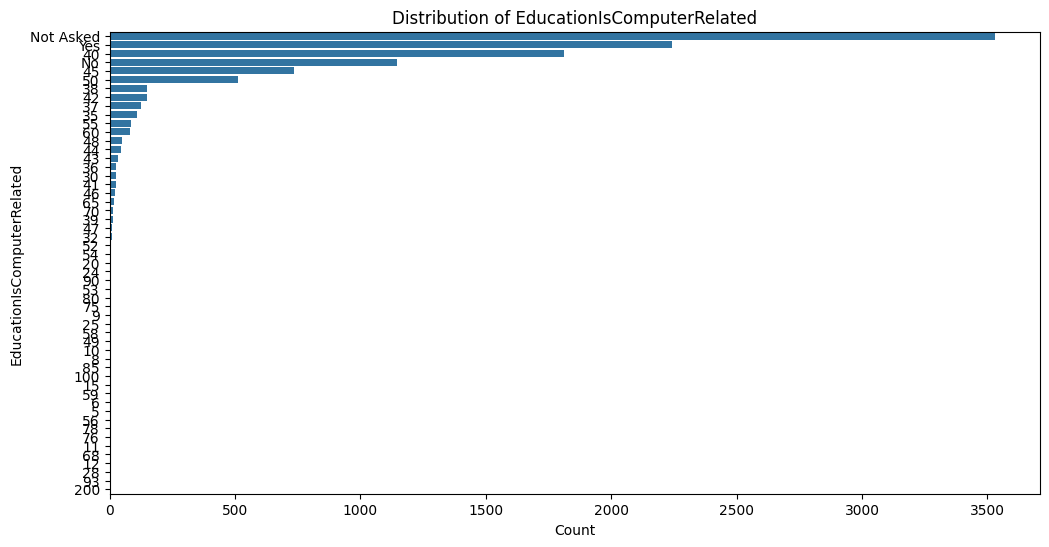

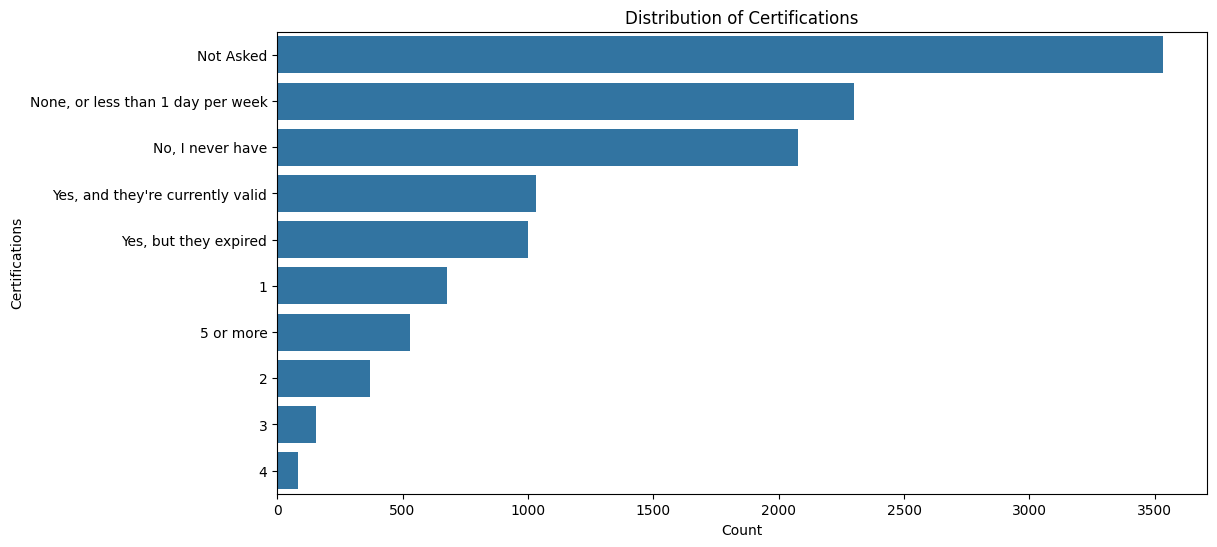

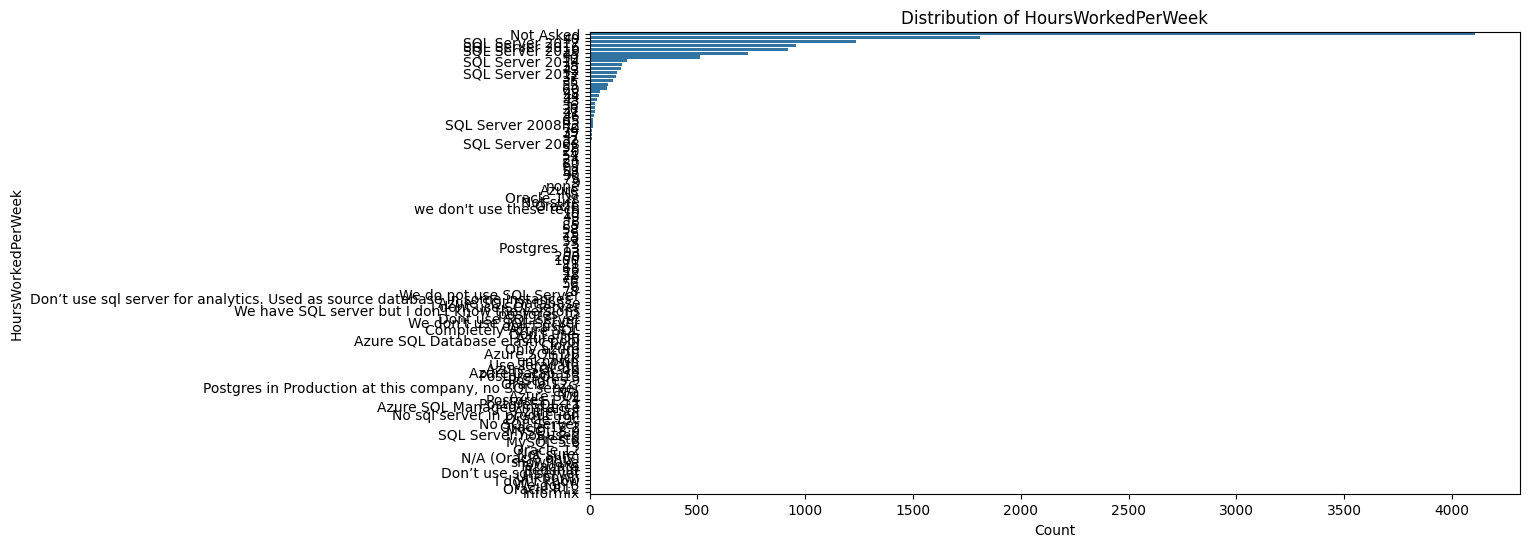

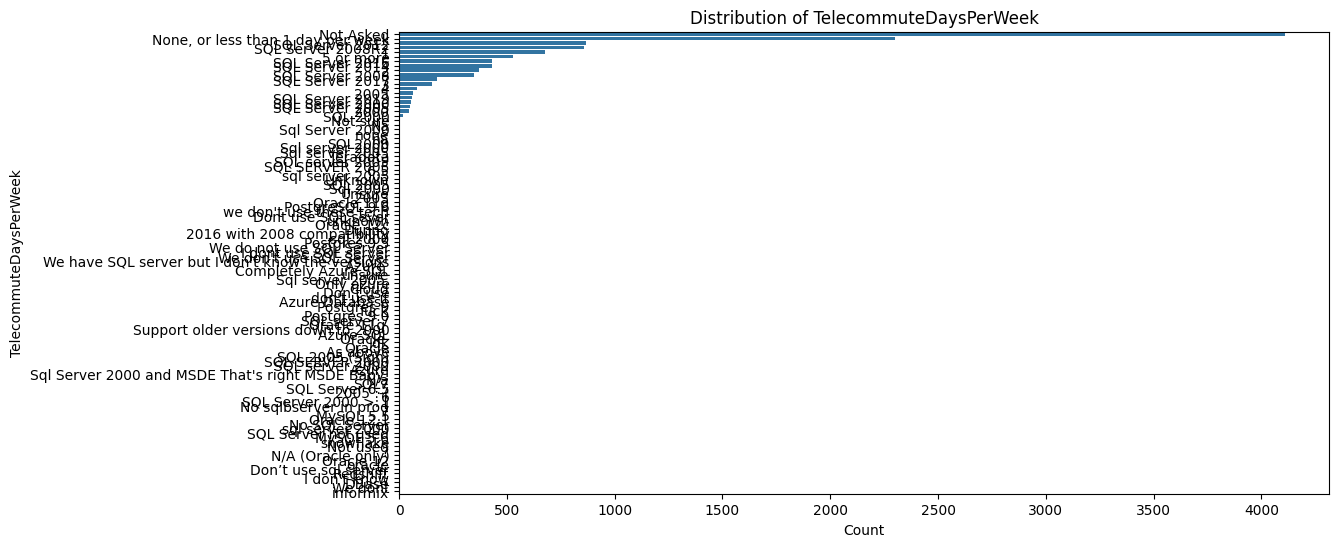

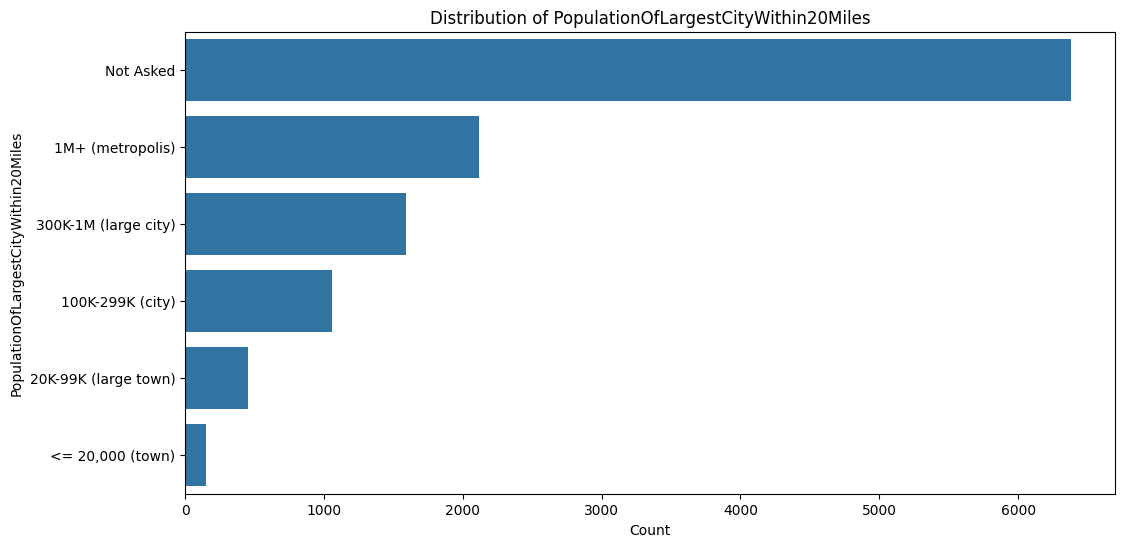

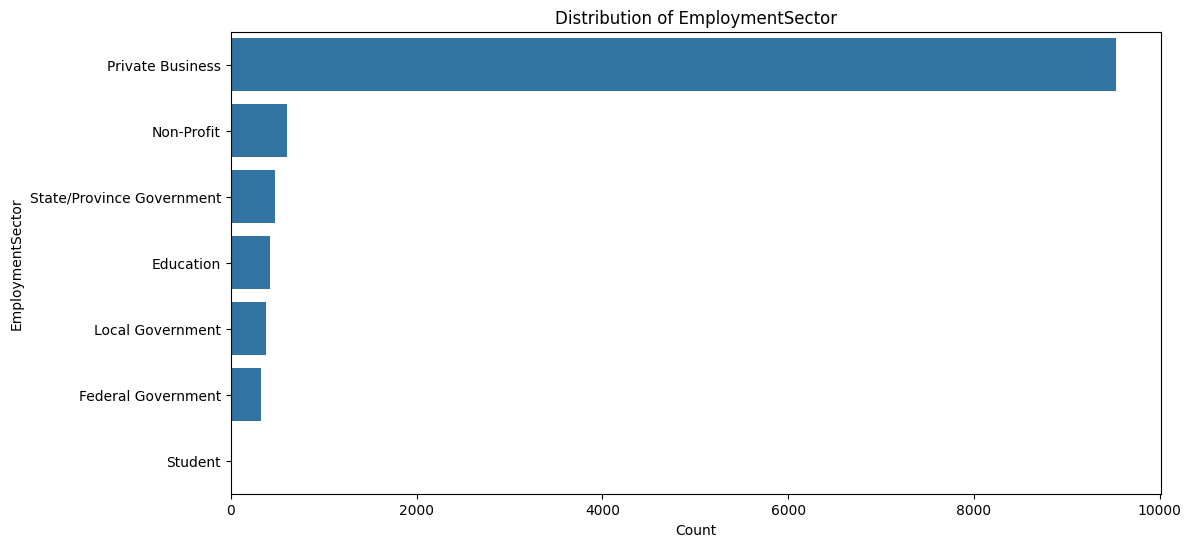

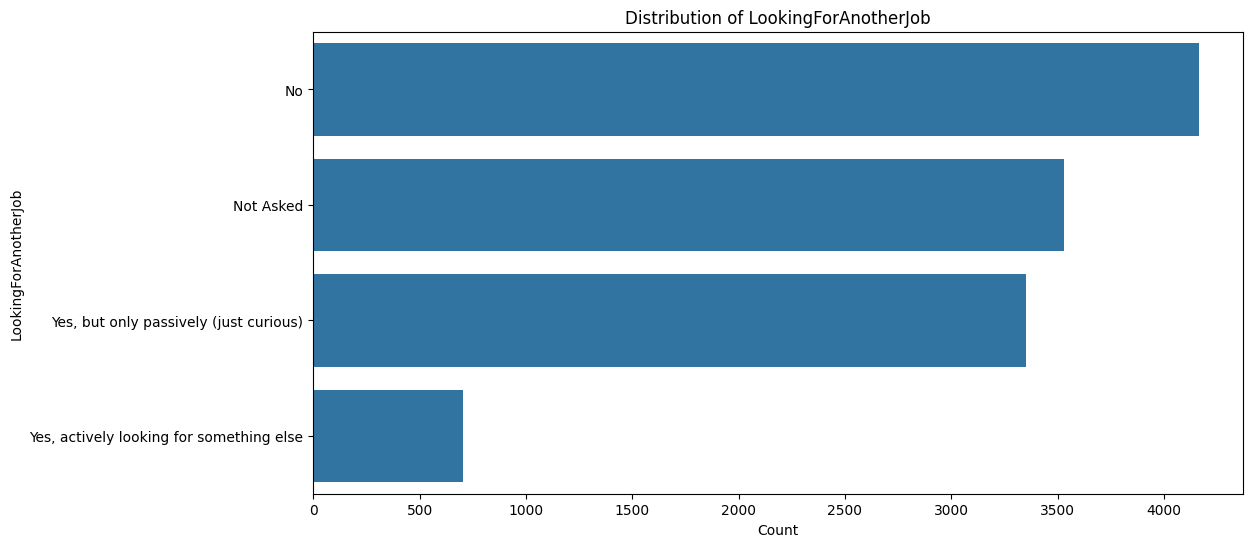

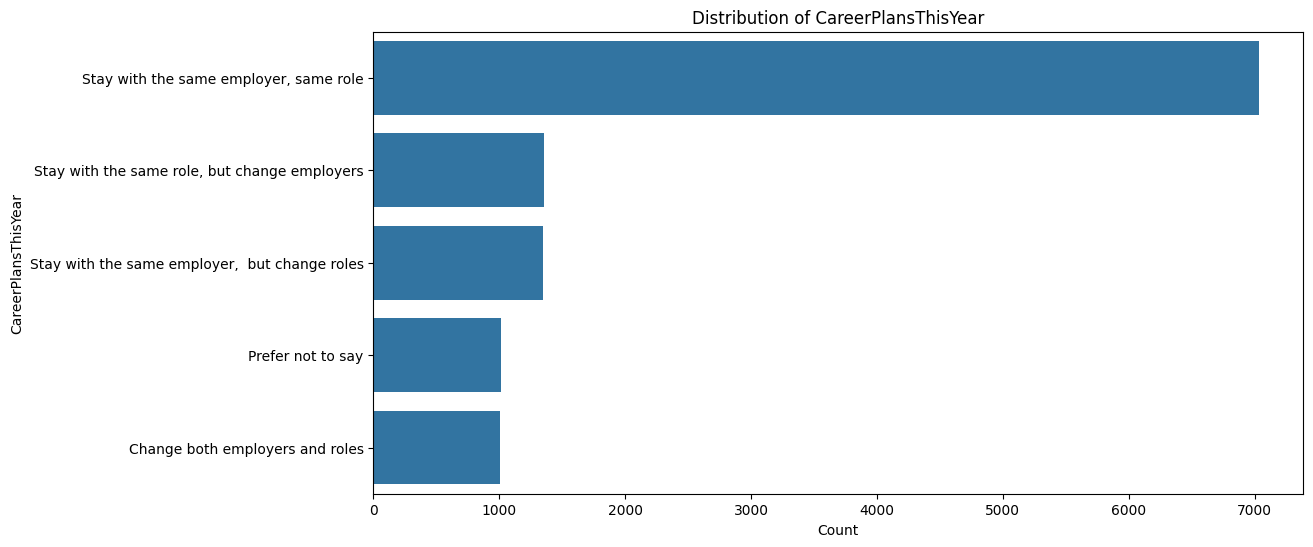

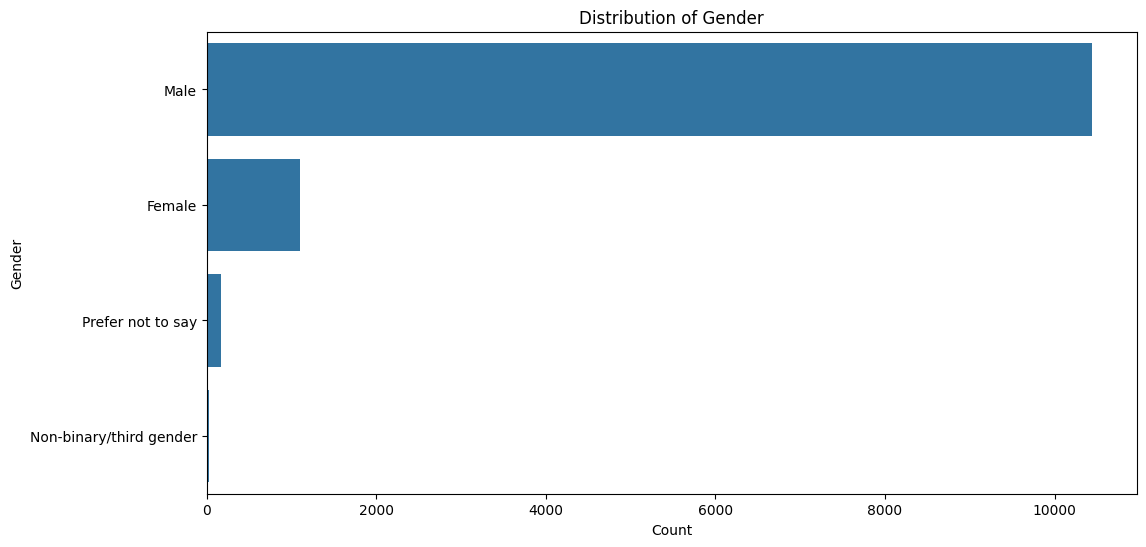

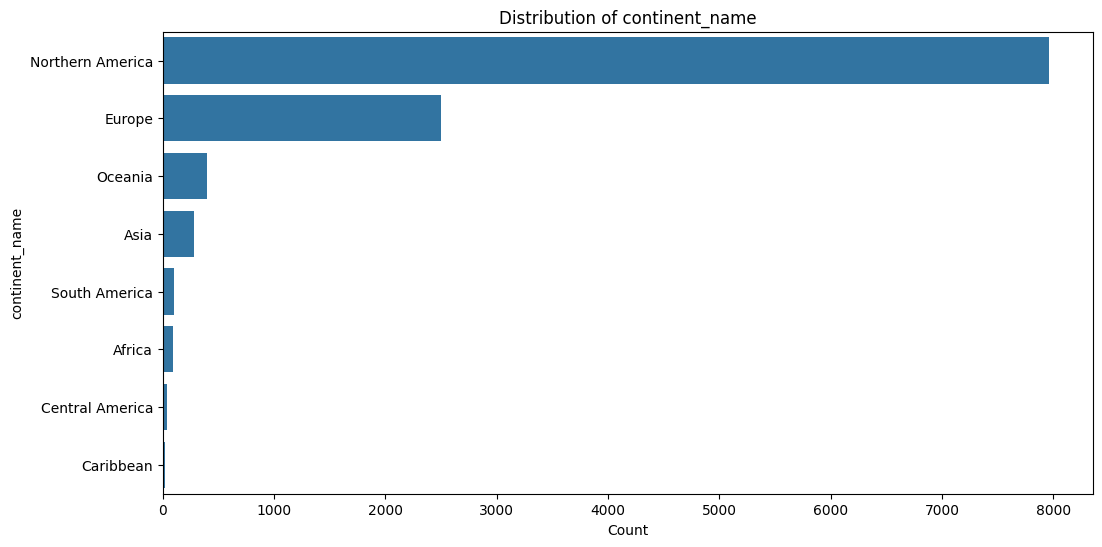

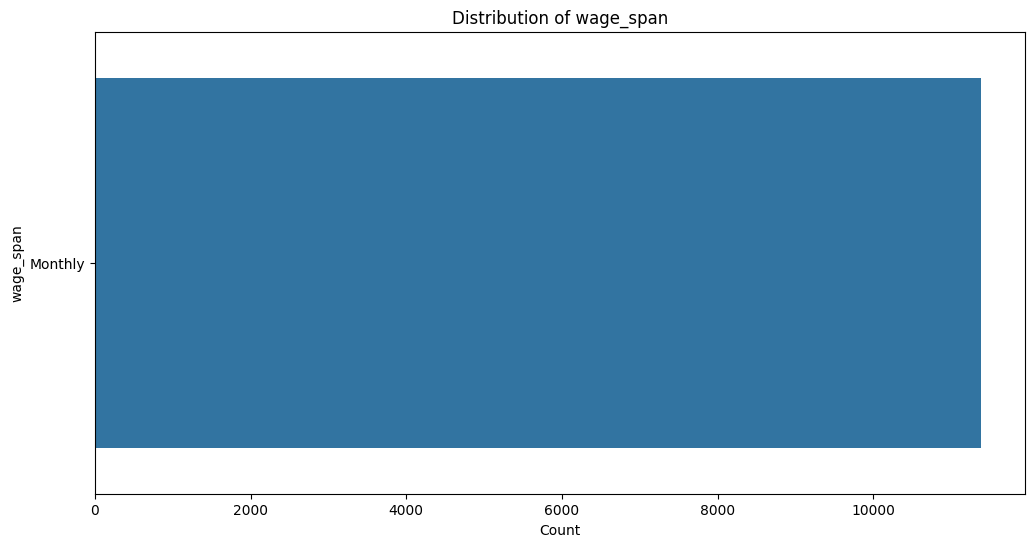

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identifying categorical columns (excluding potential identifiers like Country)
categorical_cols = merged_all_features_final.select_dtypes(include=['object']).columns.tolist()
# Excluding 'Country' and 'Country_Standardized' if they are in the list
if 'Country' in categorical_cols:
    categorical_cols.remove('Country')
if 'Country_Standardized' in categorical_cols:
    categorical_cols.remove('Country_Standardized')
# Excluding other potentially high-cardinality or non-relevant object columns
exclude_cols = ['PrimaryDatabase', 'OtherDatabases', 'JobTitle', 'OtherJobDuties', 'KindsOfTasksPerformed', 'NewestVersionInProduction', 'OldestVersionInProduction']
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

# Standardize 'EmploymentSector' values
if 'EmploymentSector' in merged_all_features_final.columns:
    employment_sector_mapping = {
        'Education (K-12, college, university)': 'Education',
        'Federal government': 'Federal Government',
        'Local government': 'Local Government',
        'Non-profit': 'Non-Profit',
        'Private business': 'Private Business',
        'State/province government': 'State/Province Government',
        'Student': 'Student'
    }
    # Applying the mapping and clean up underscores and capitalization for consistency
    merged_all_features_final['EmploymentSector'] = merged_all_features_final['EmploymentSector'].replace(employment_sector_mapping)
    merged_all_features_final['EmploymentSector'] = merged_all_features_final['EmploymentSector'].str.replace('_', ' ', regex=False).str.title().str.replace(' Of ', ' of ', regex=False)
    # Correct specific capitalizations that title() might get wrong
    merged_all_features_final['EmploymentSector'] = merged_all_features_final['EmploymentSector'].str.replace('K 12', 'K-12', regex=False)


print("Visualizing distributions of categorical features:")

# Plotting bar plots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=merged_all_features_final, y=col, order=merged_all_features_final[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

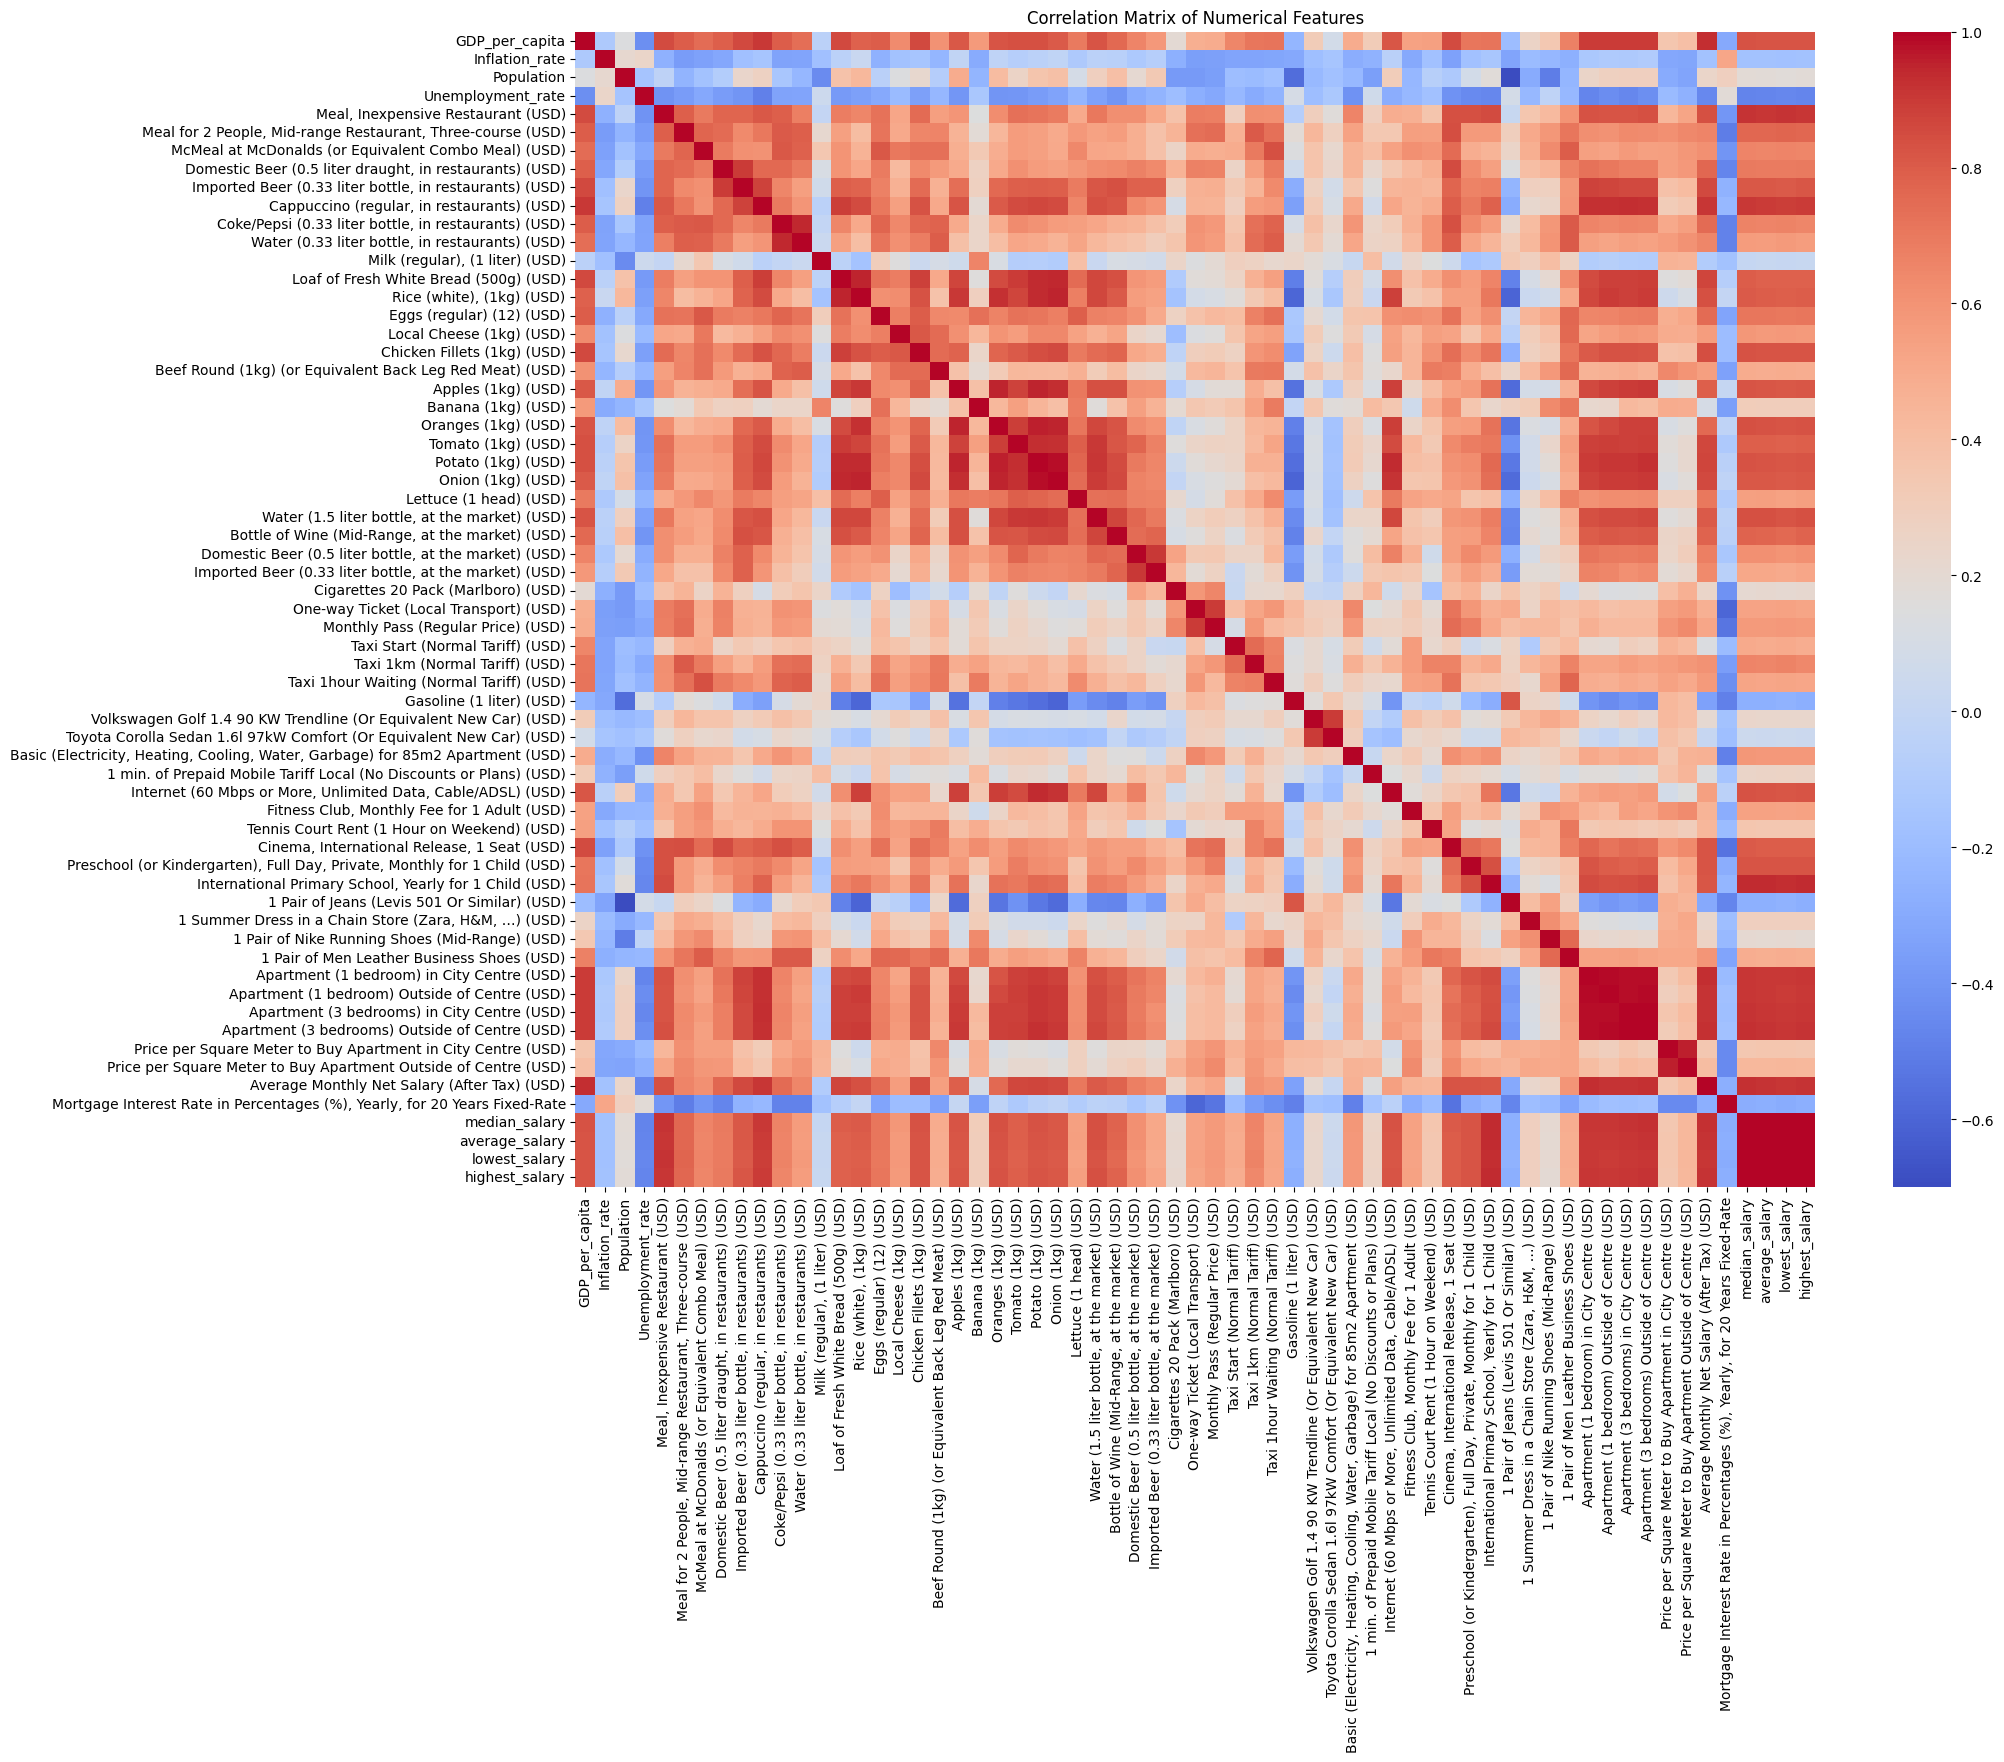

In [ ]:
# Visualizing the correlation matrix for numerical features
plt.figure(figsize=(20, 15))
sns.heatmap(merged_all_features_final[numerical_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Visualizing outliers in numerical features using box plots:


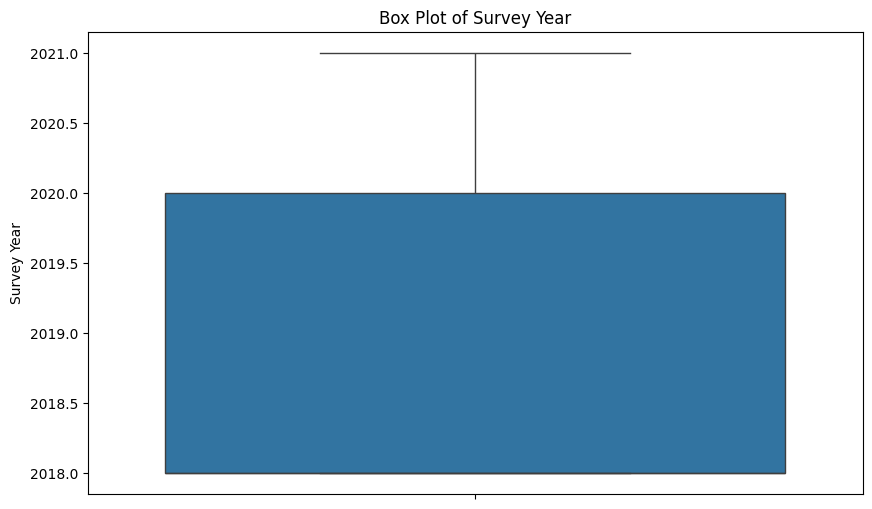

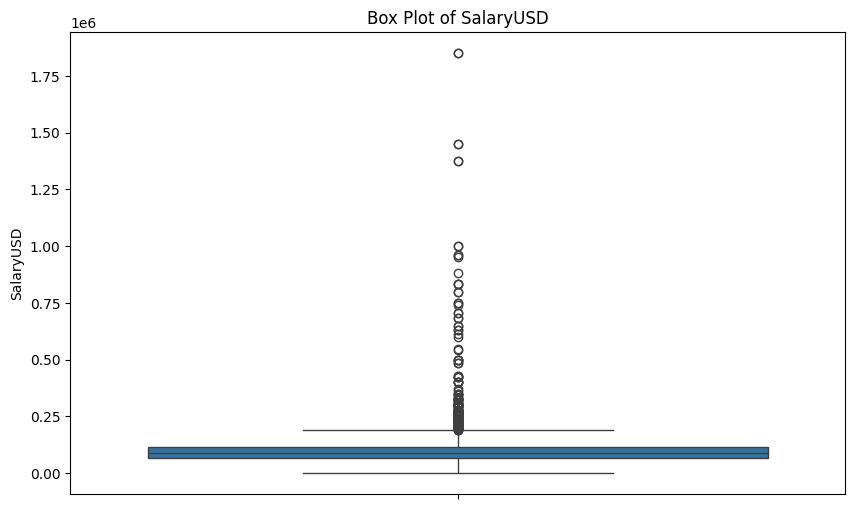

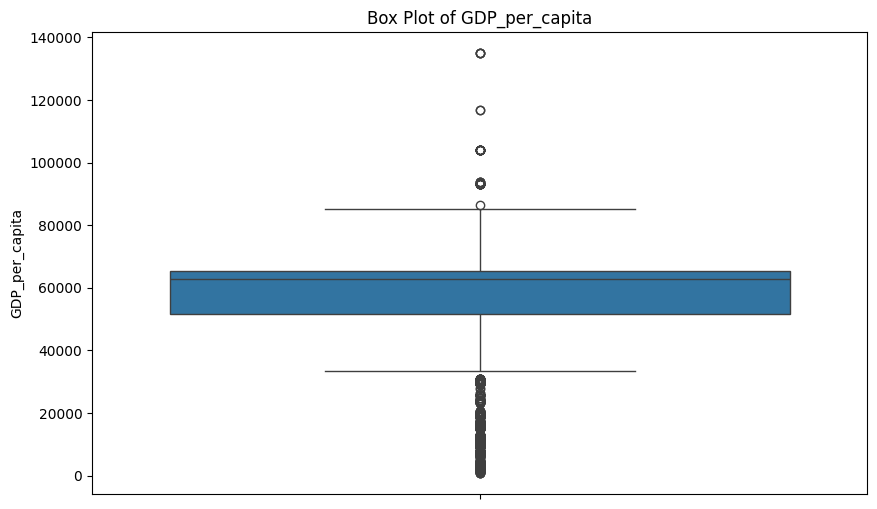

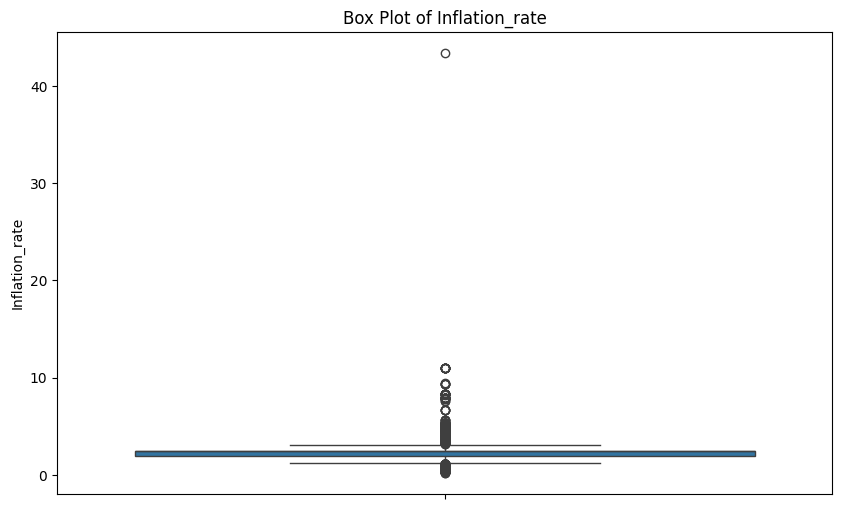

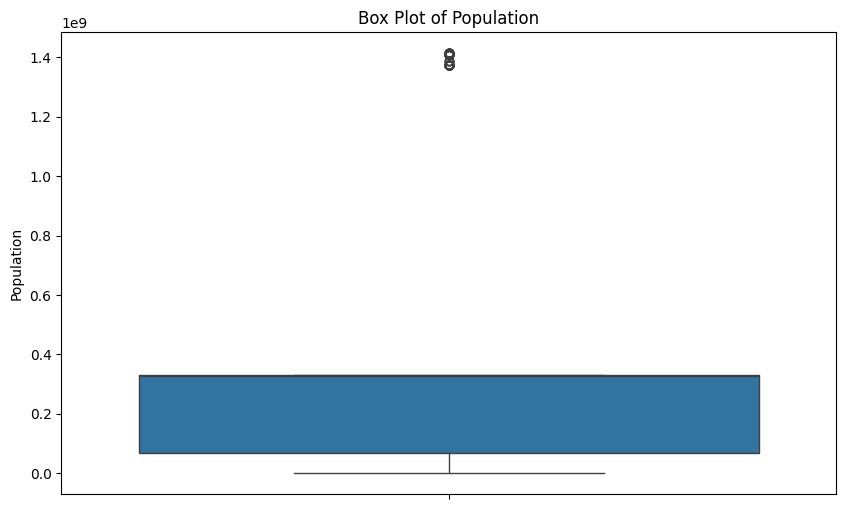

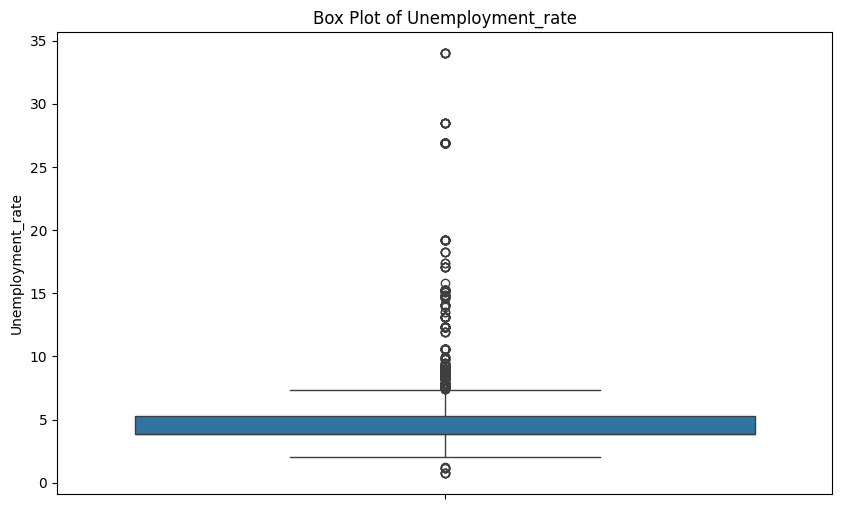

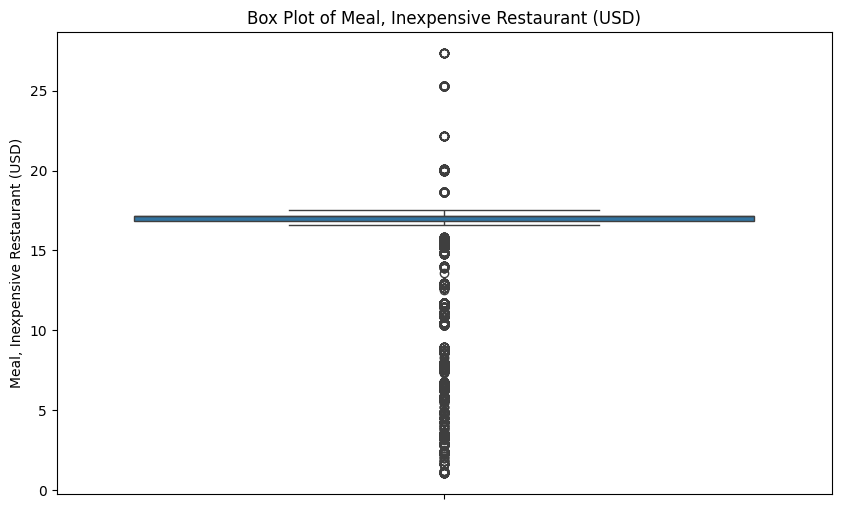

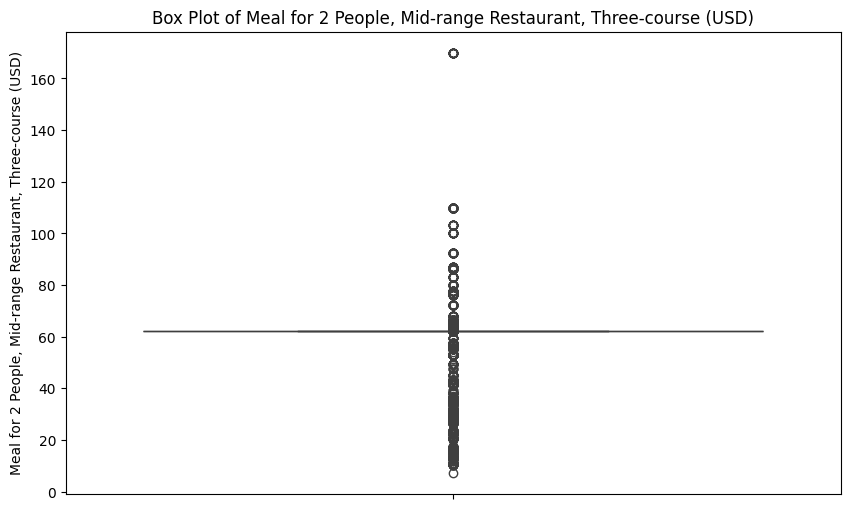

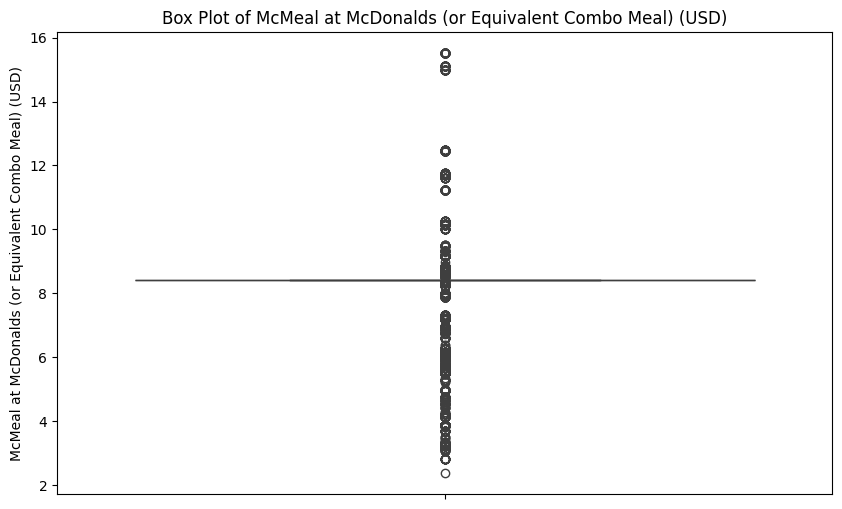

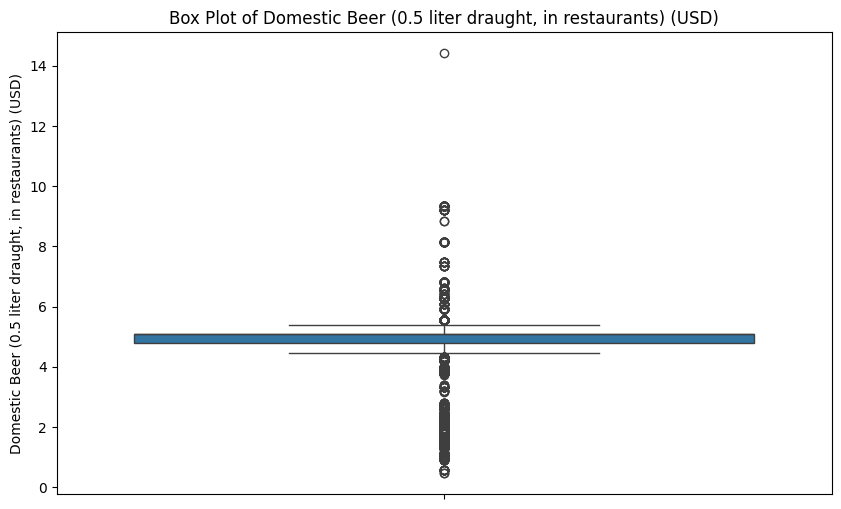

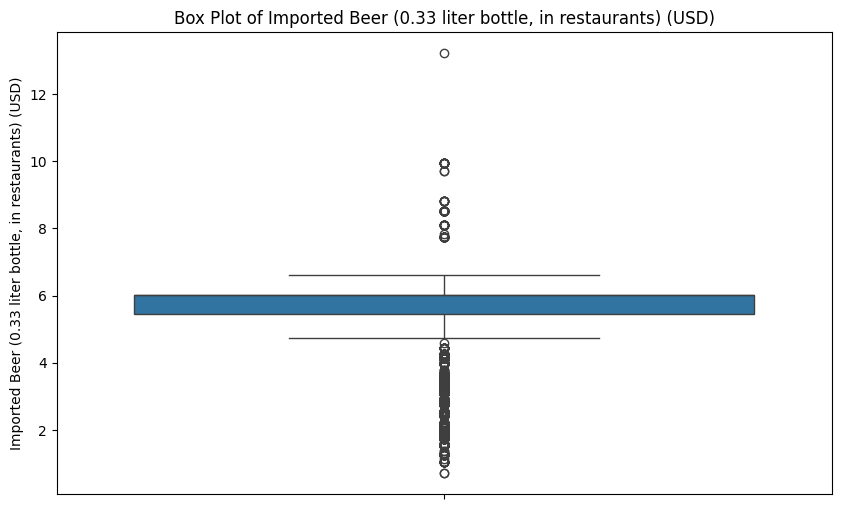

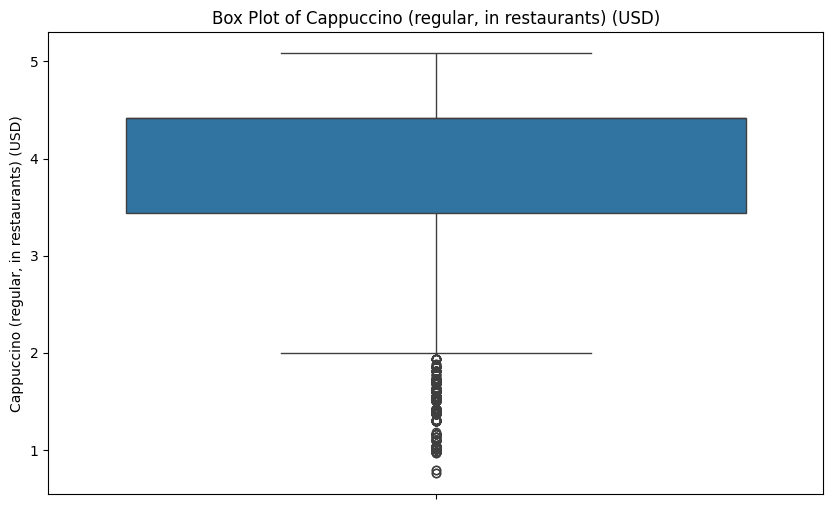

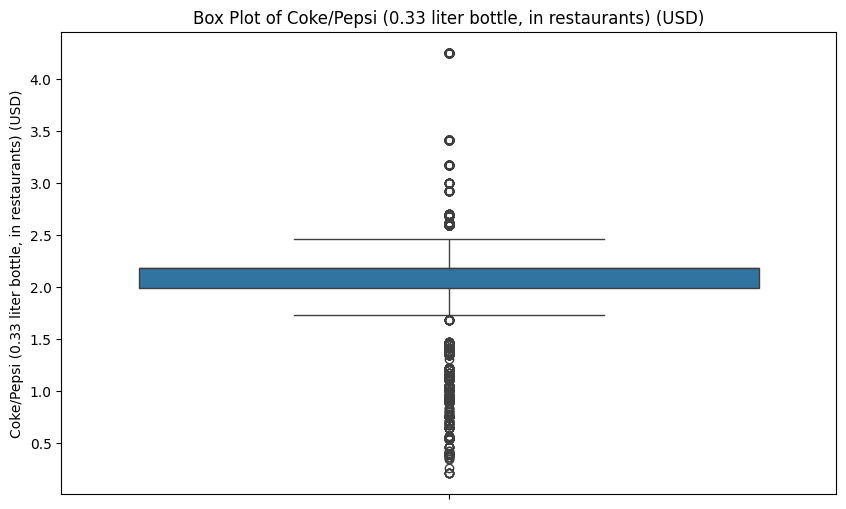

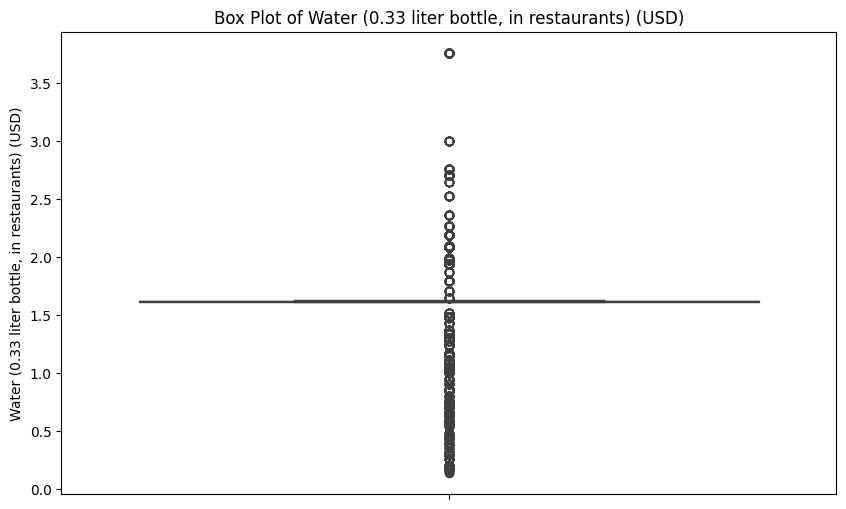

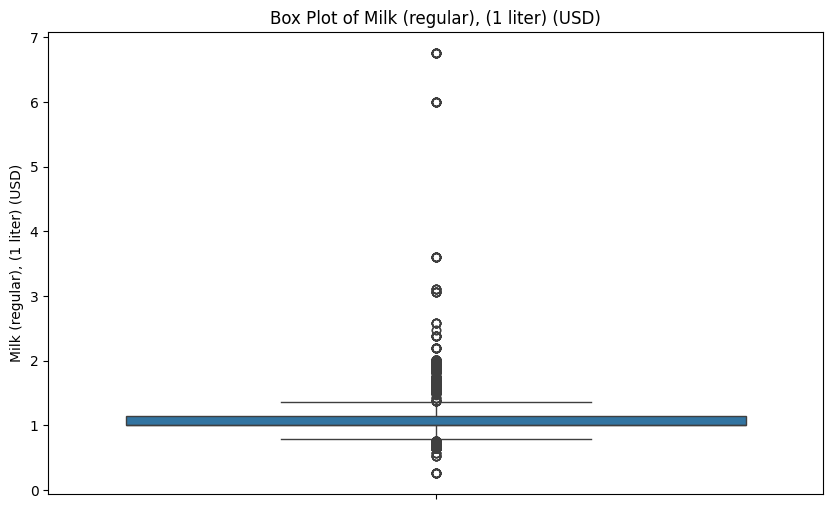

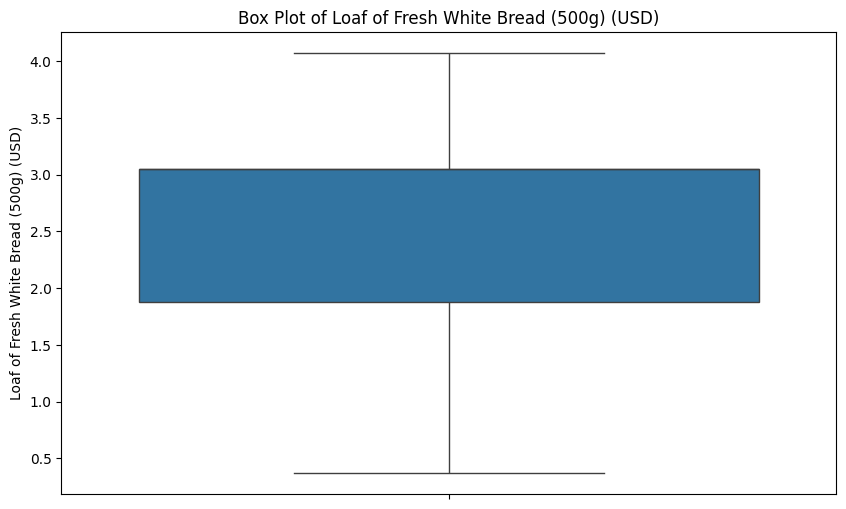

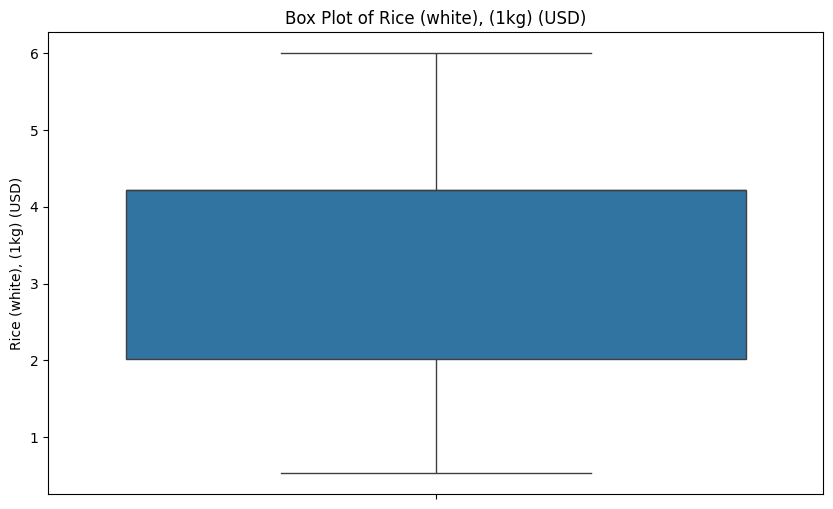

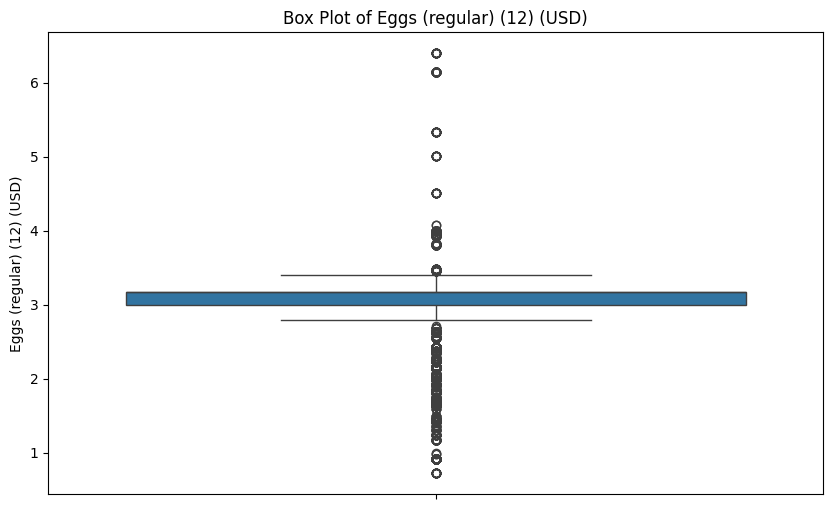

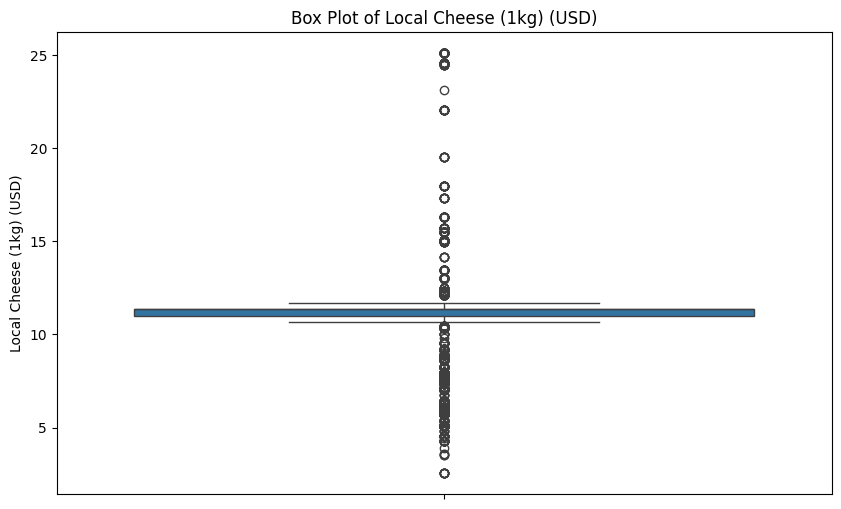

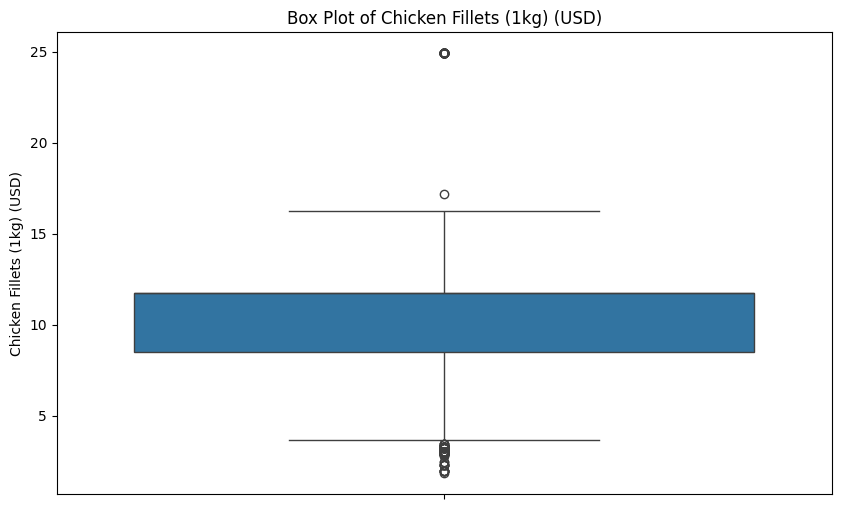

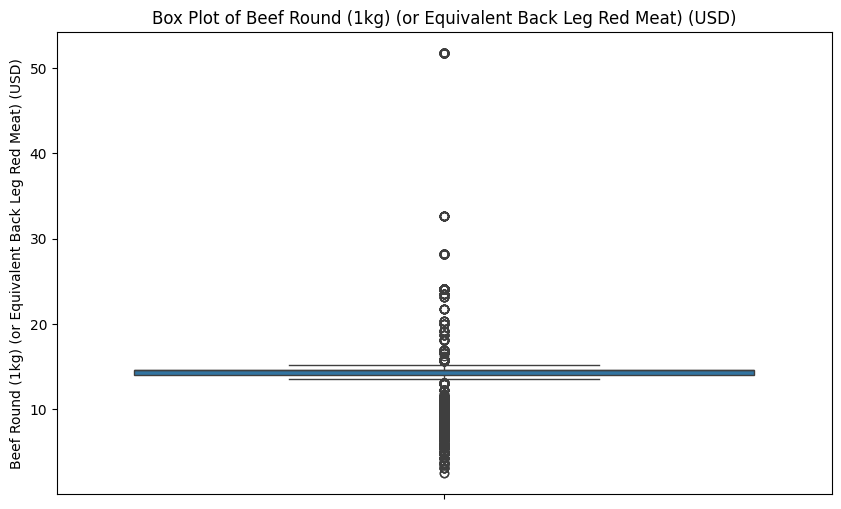

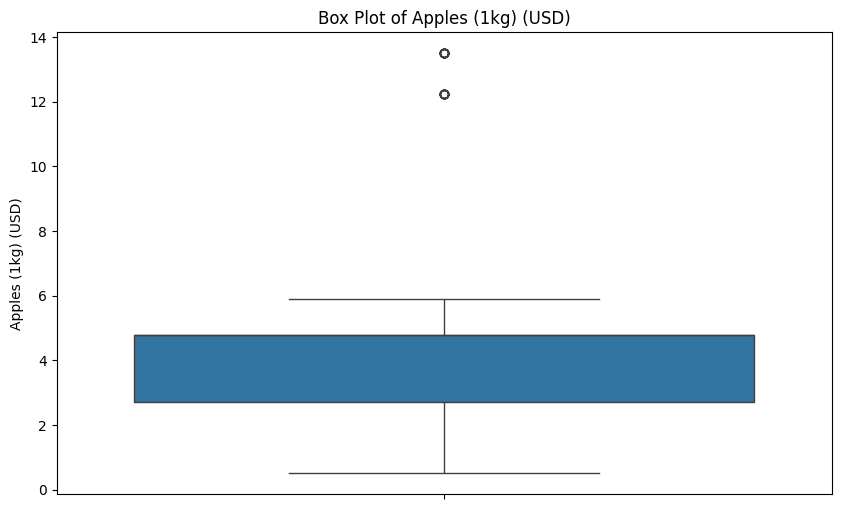

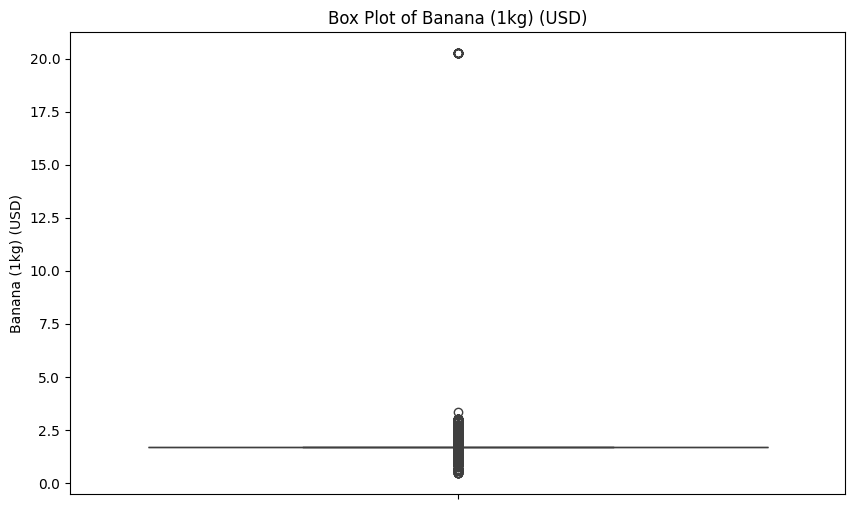

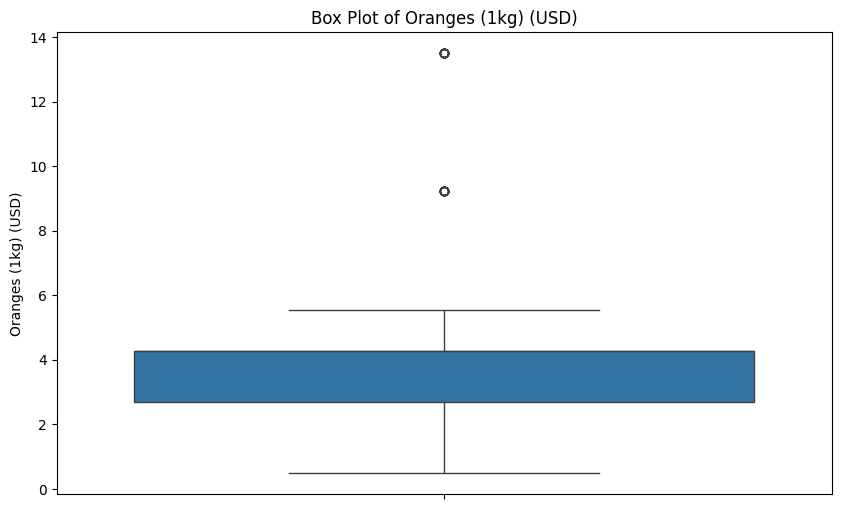

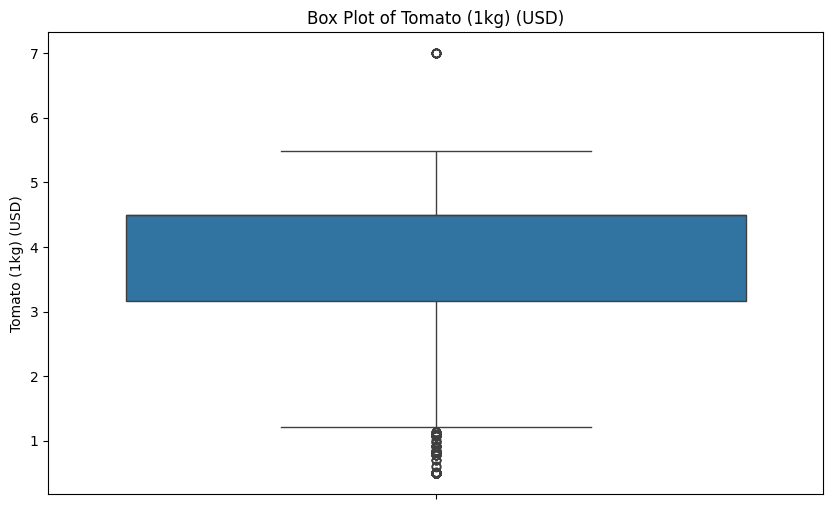

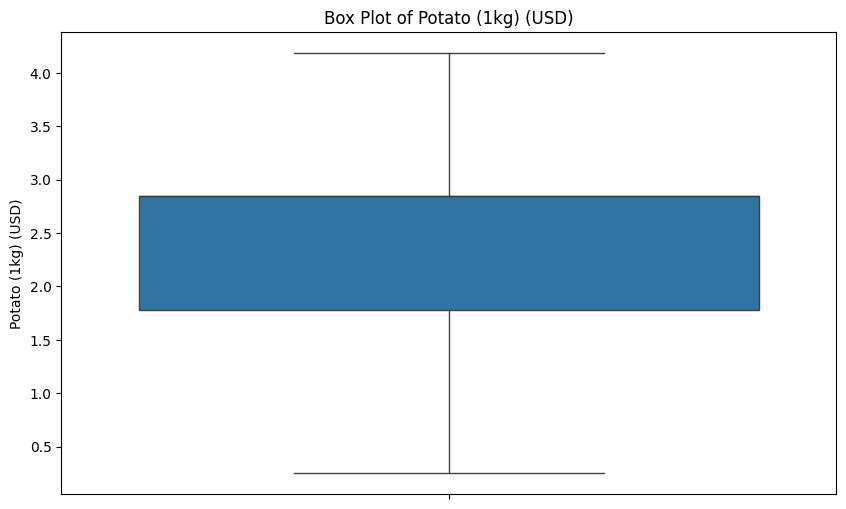

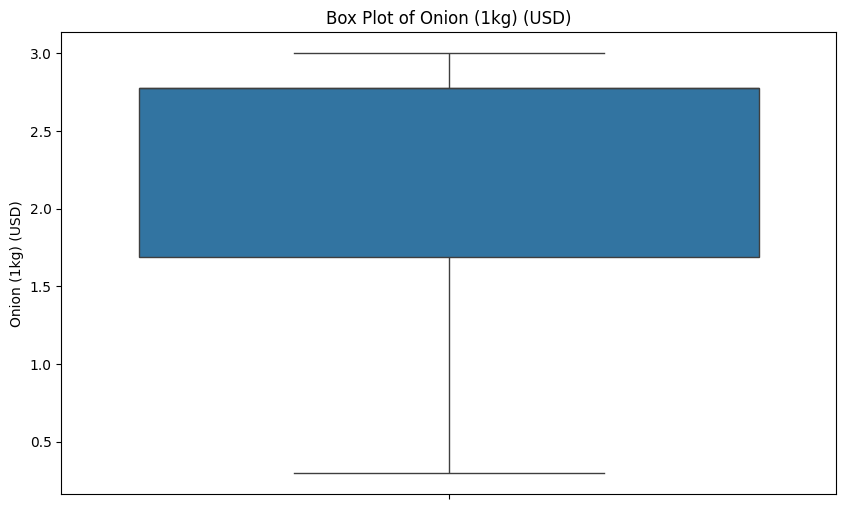

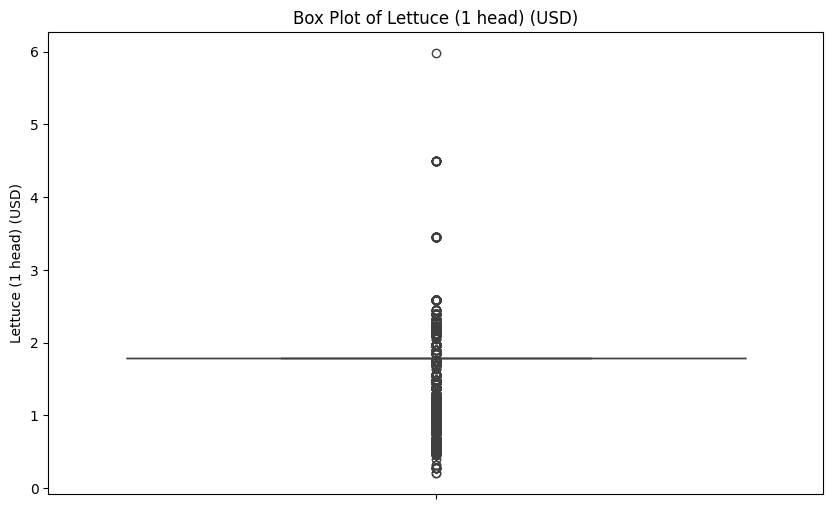

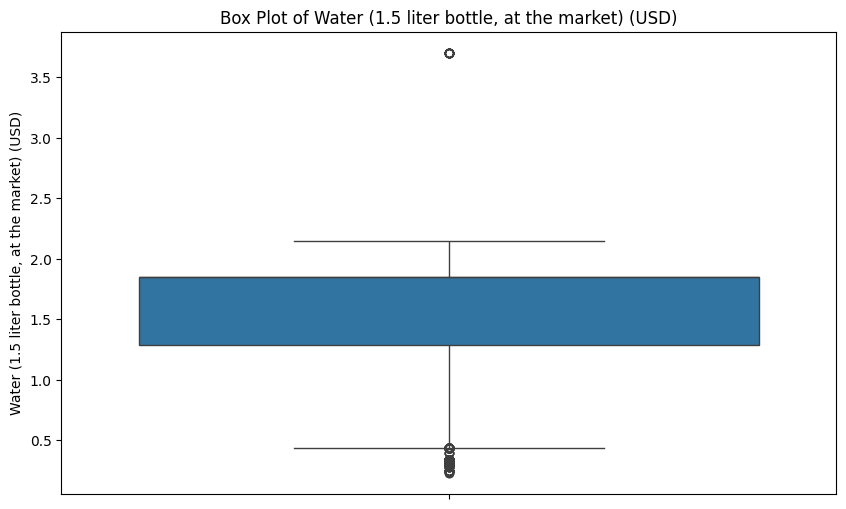

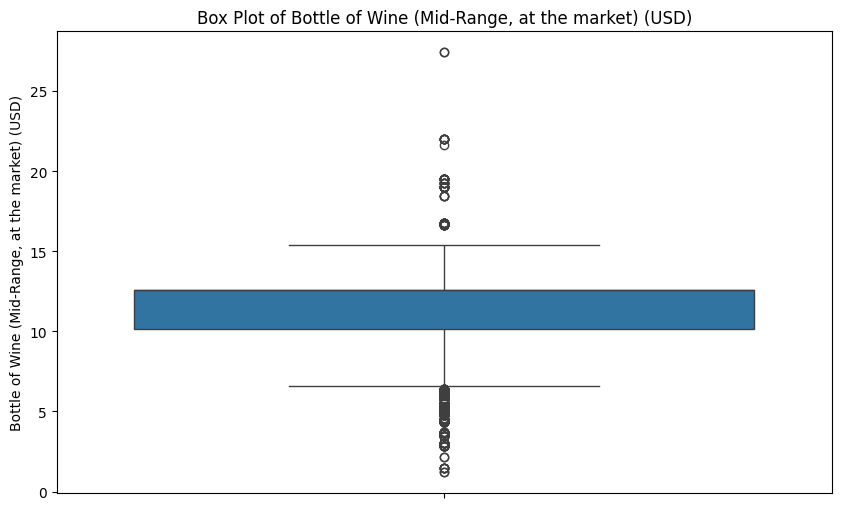

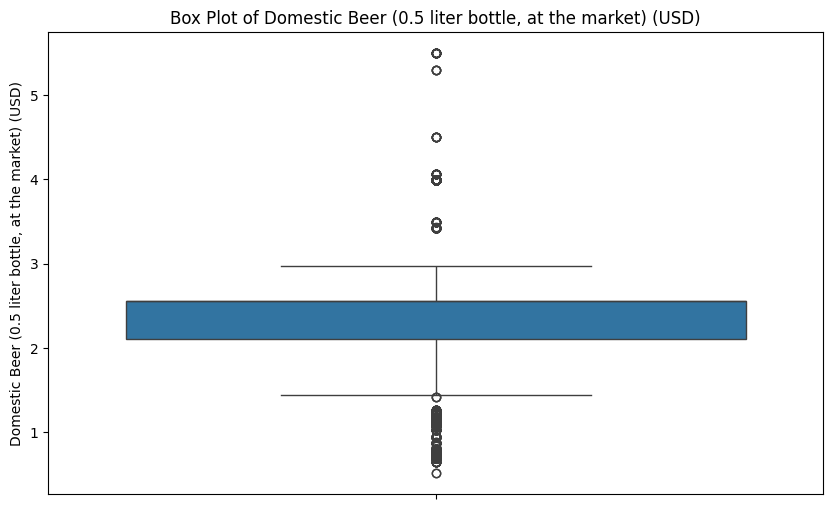

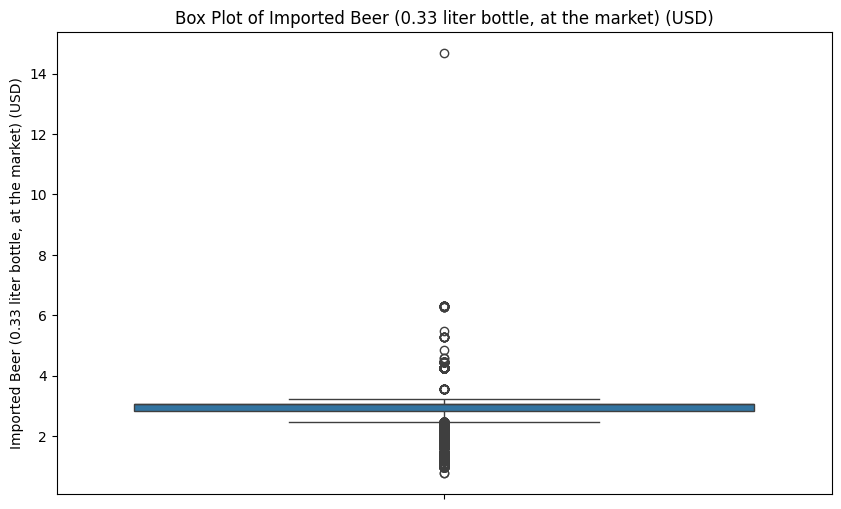

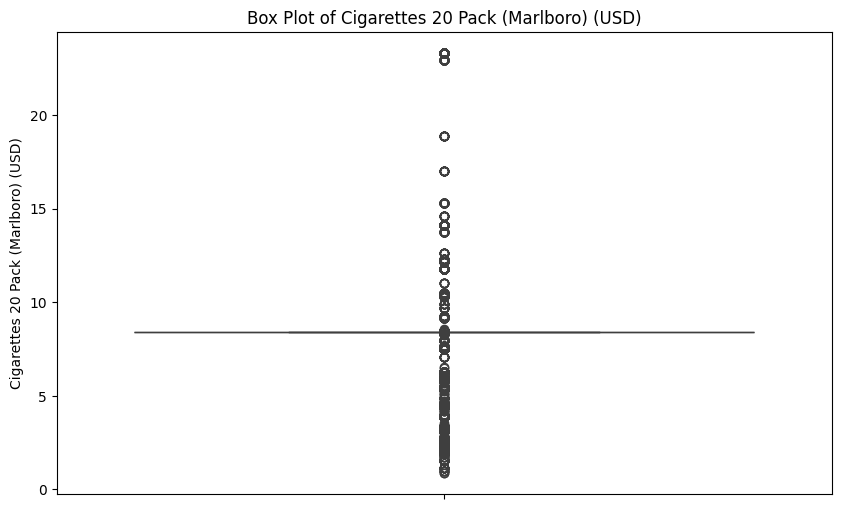

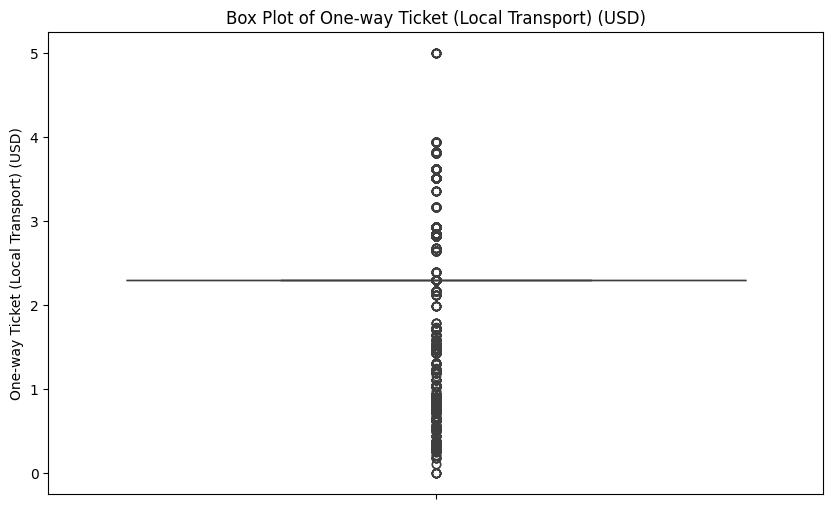

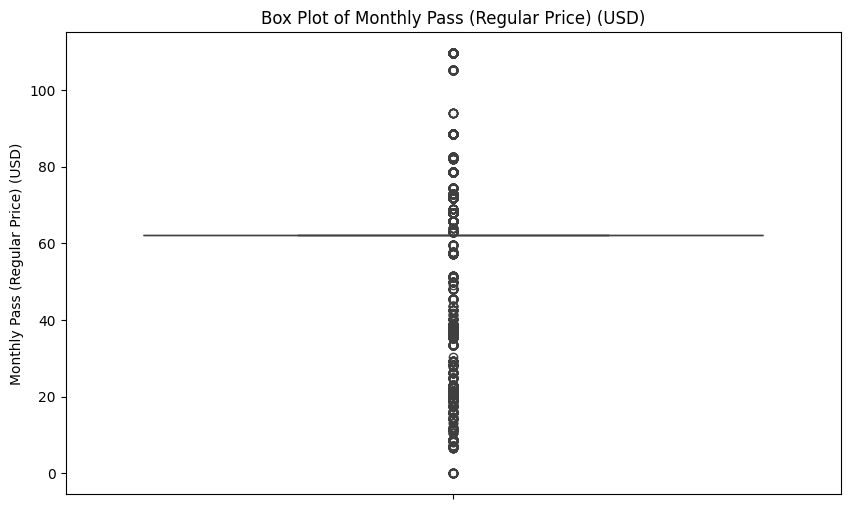

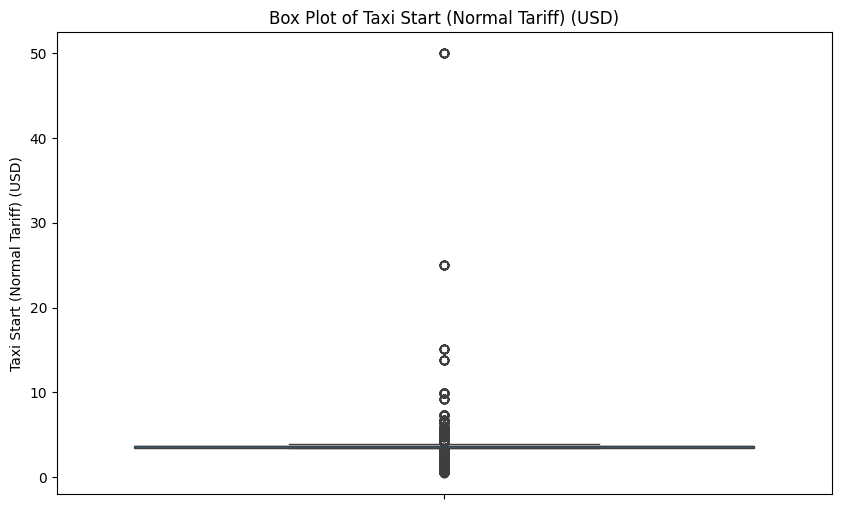

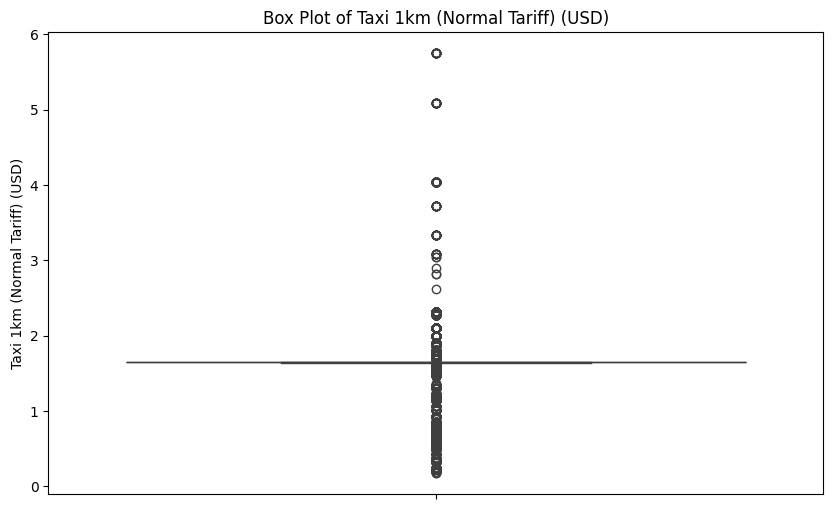

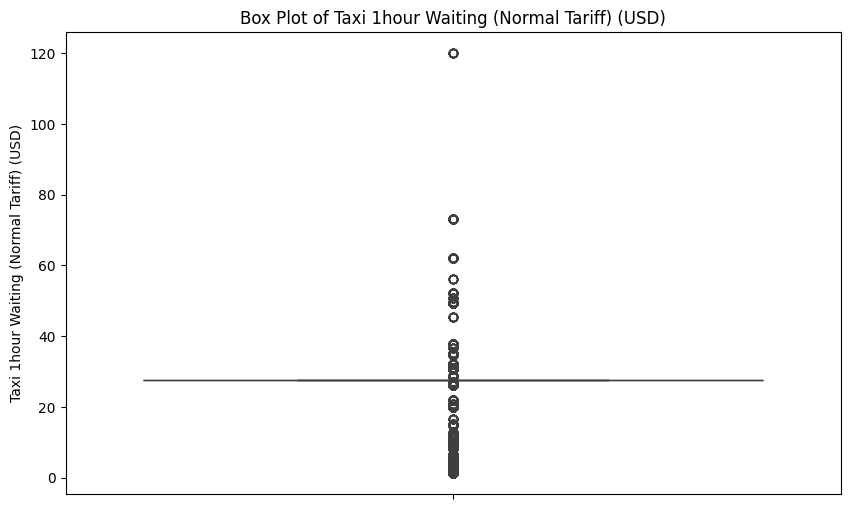

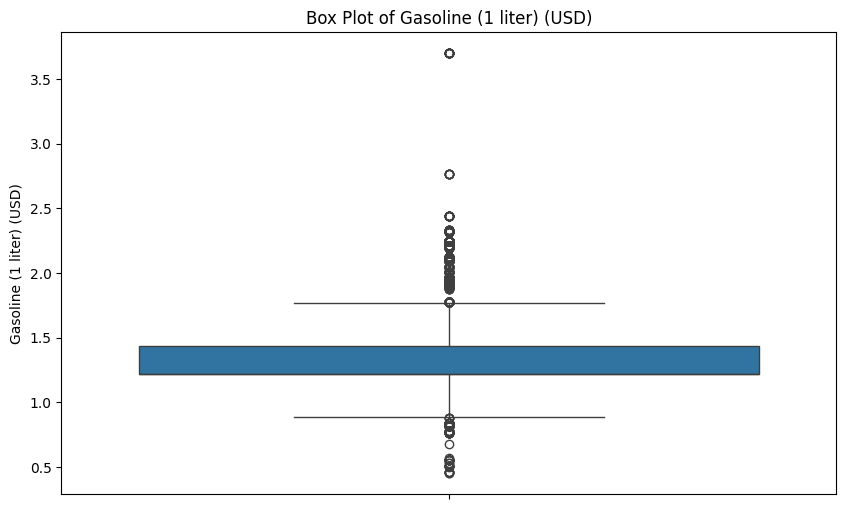

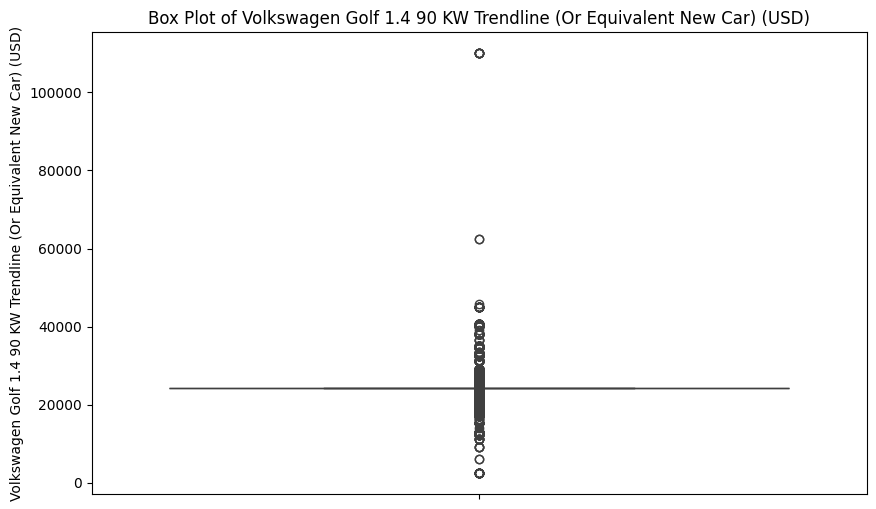

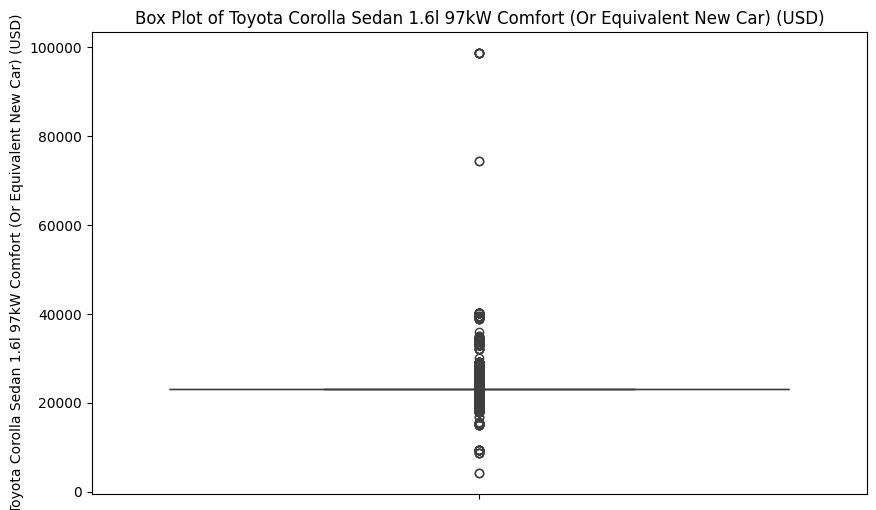

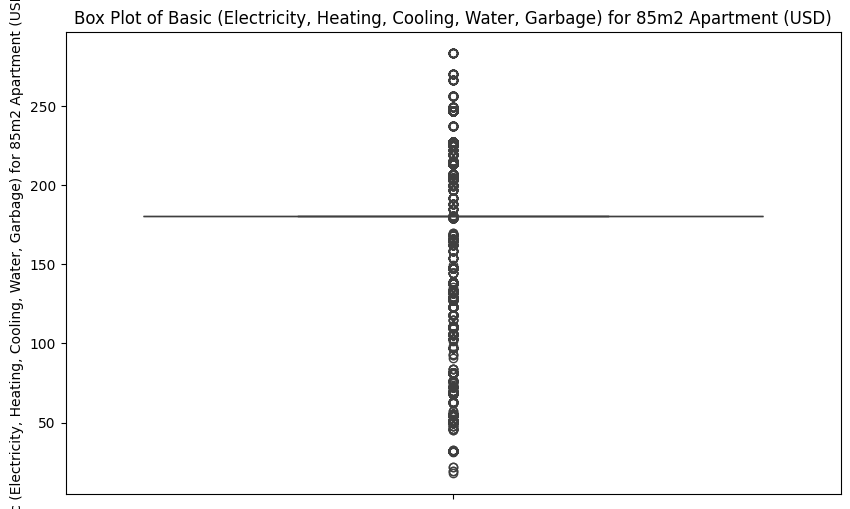

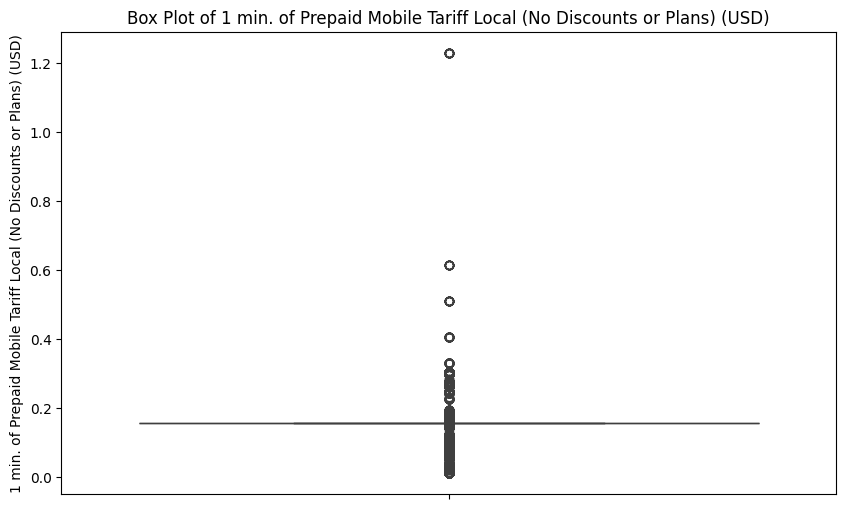

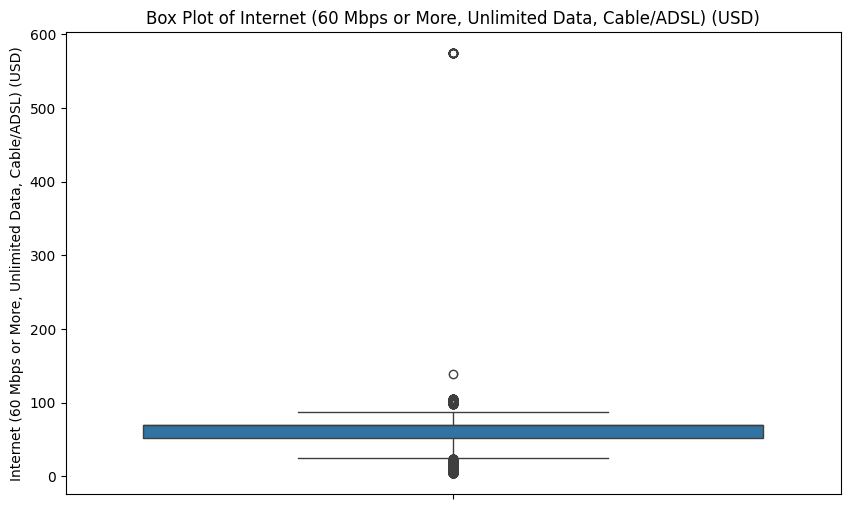

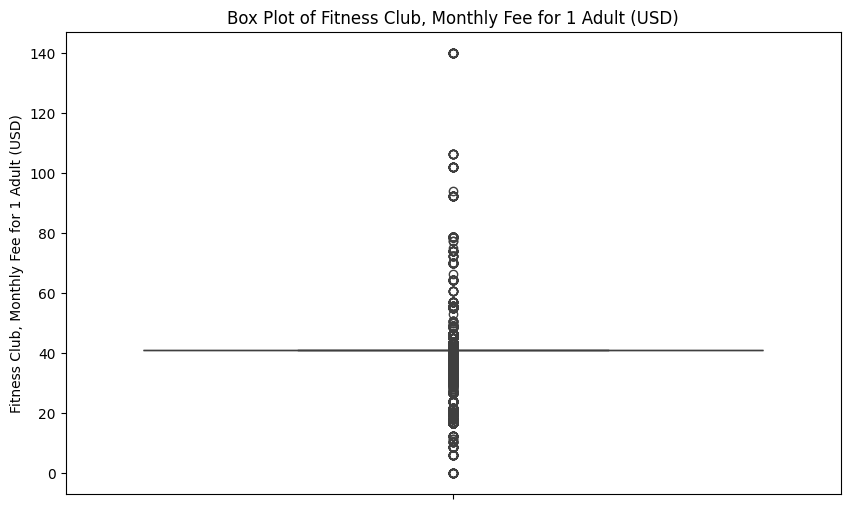

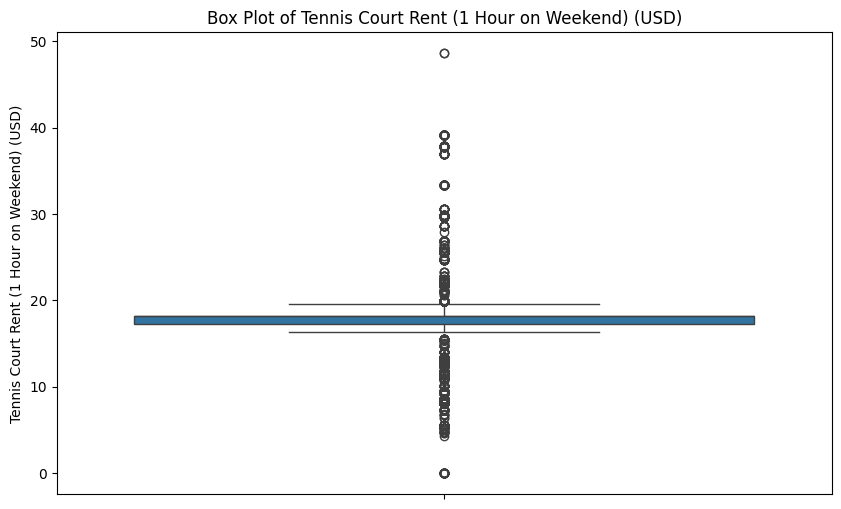

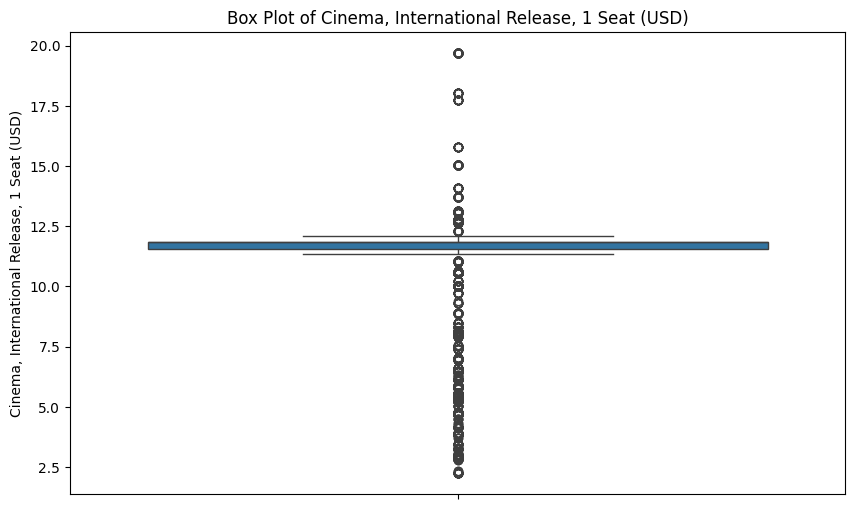

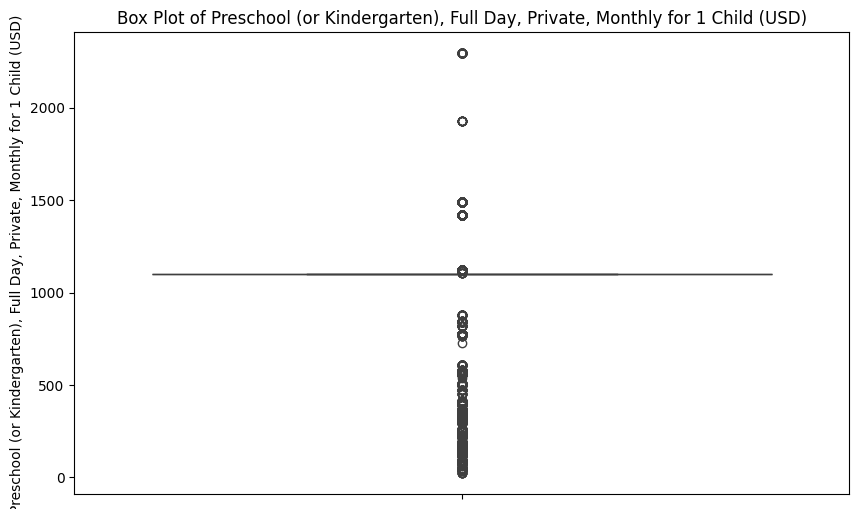

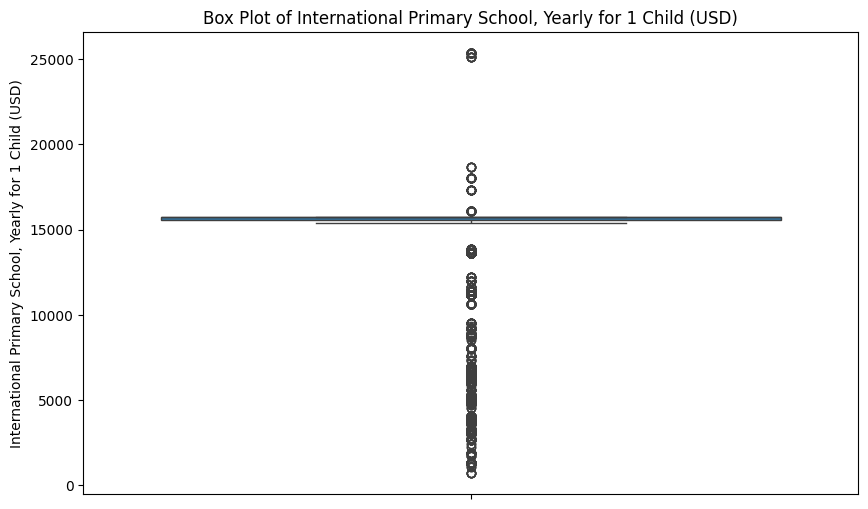

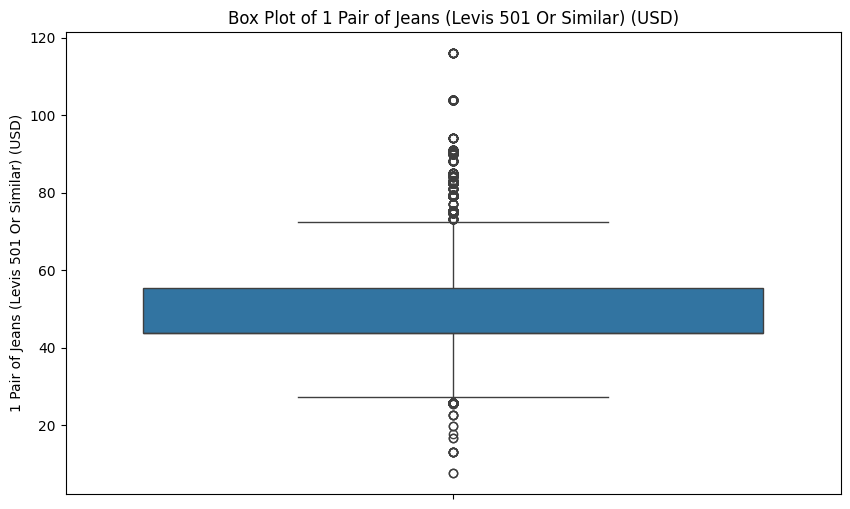

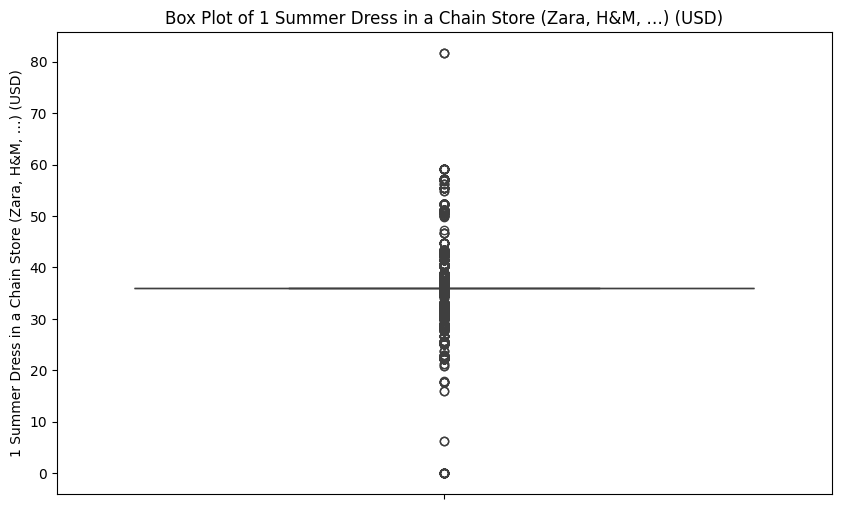

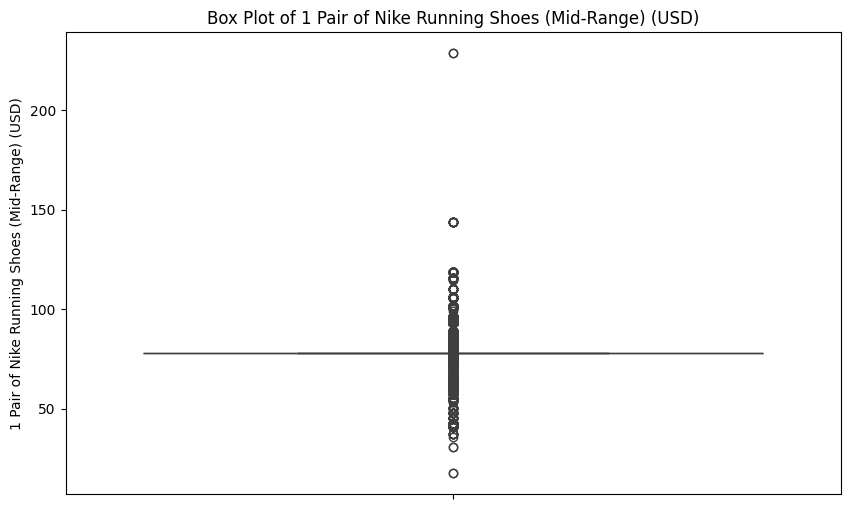

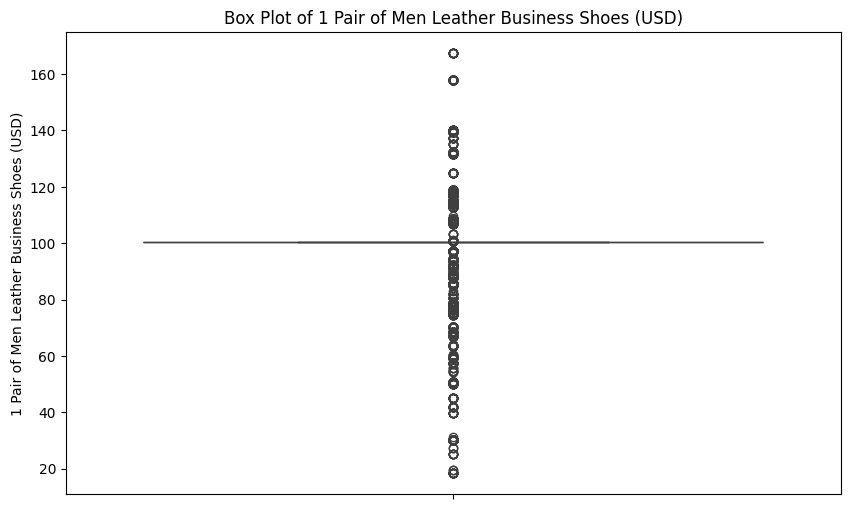

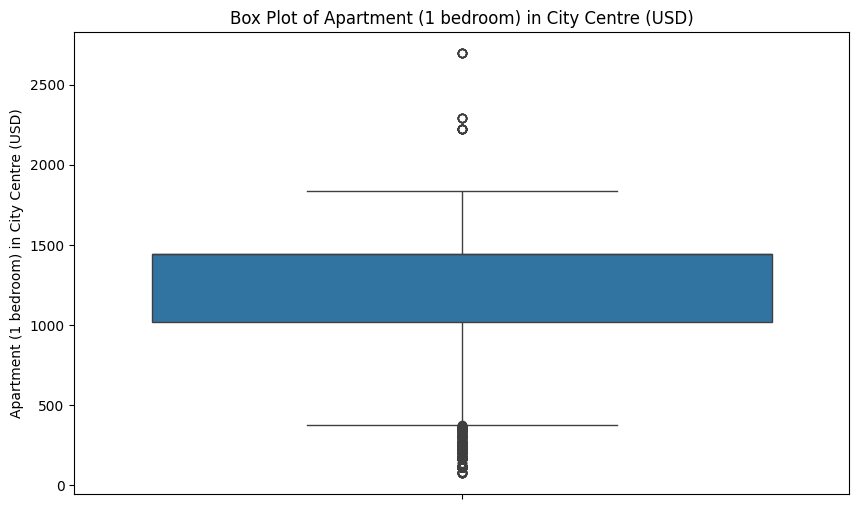

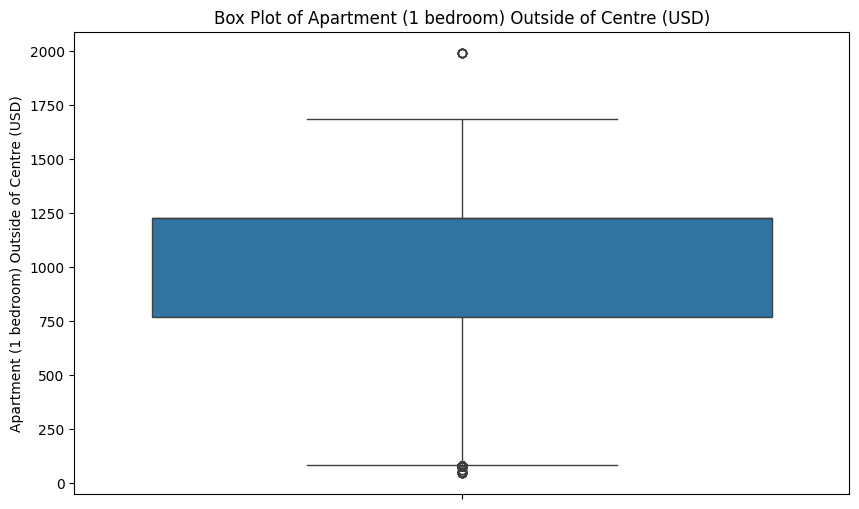

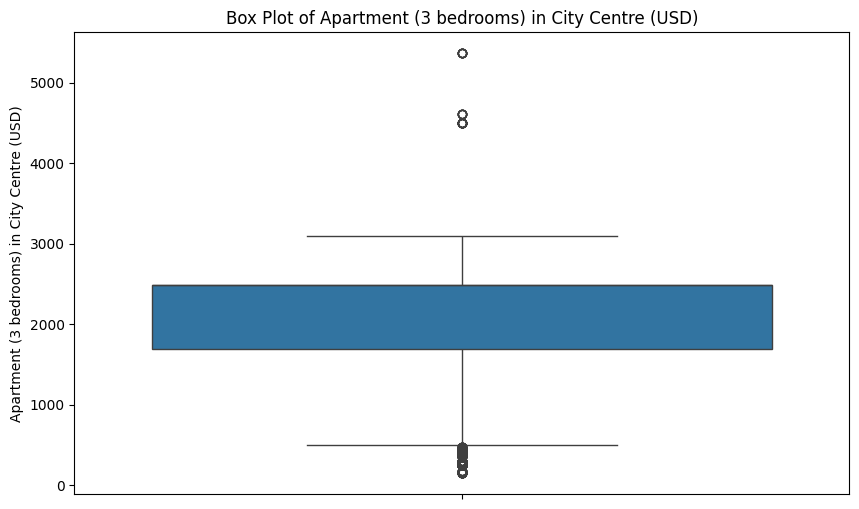

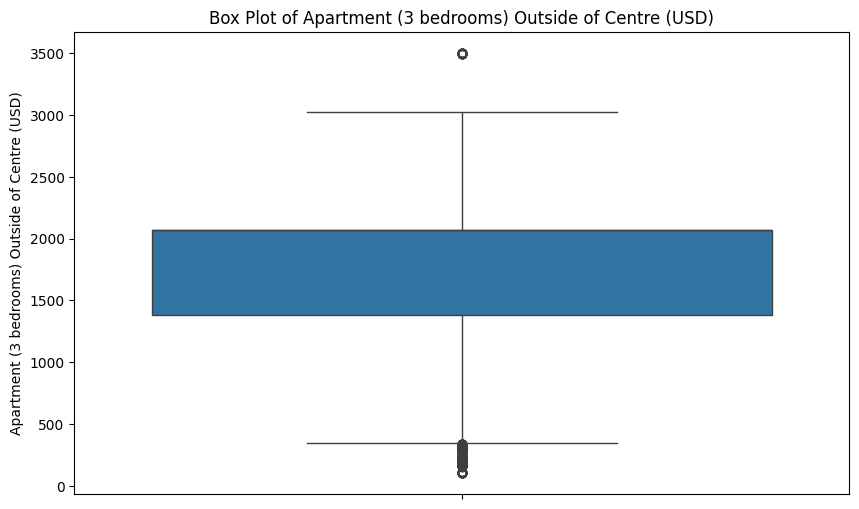

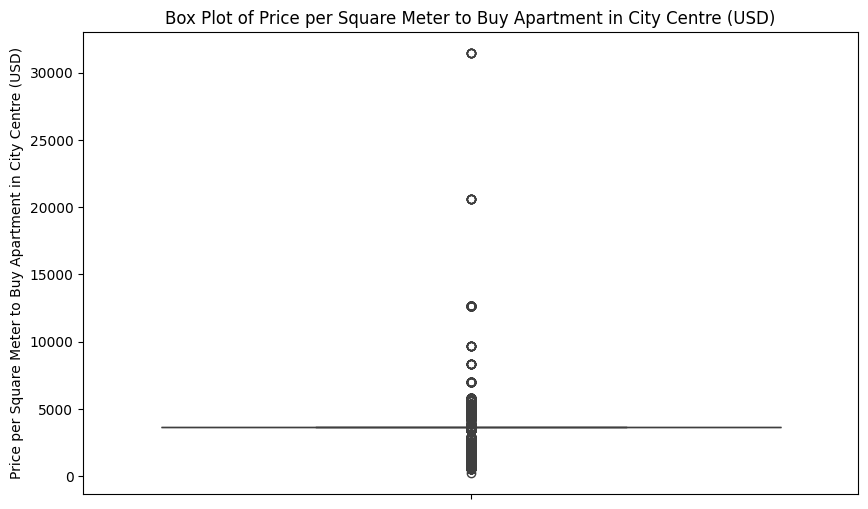

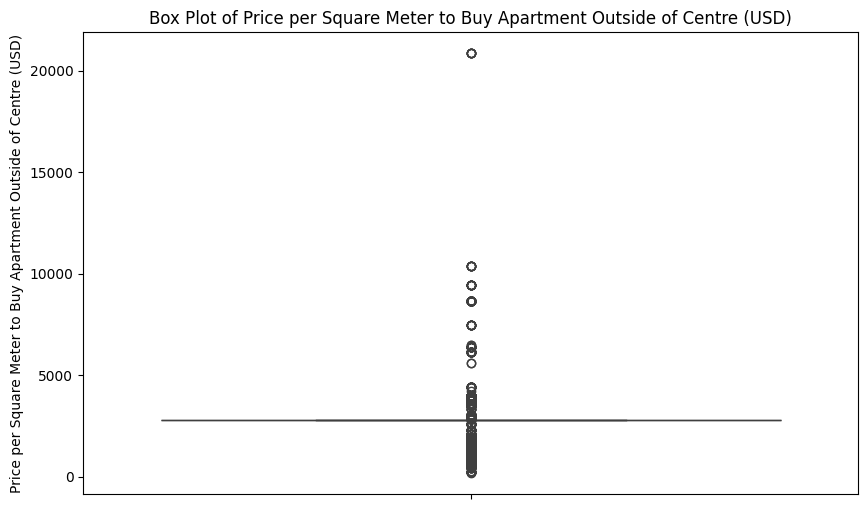

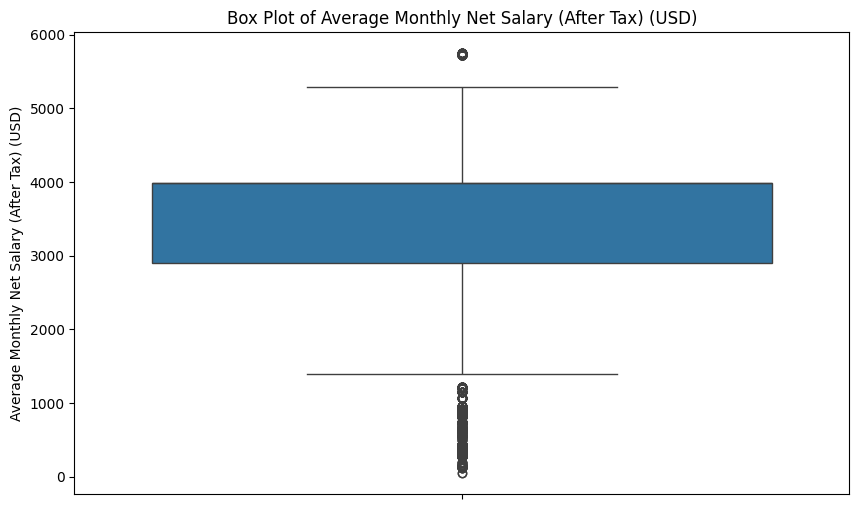

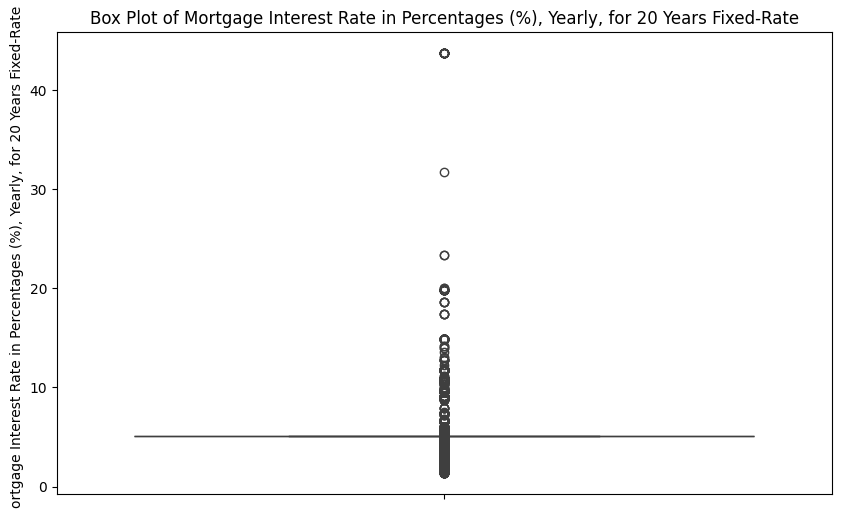

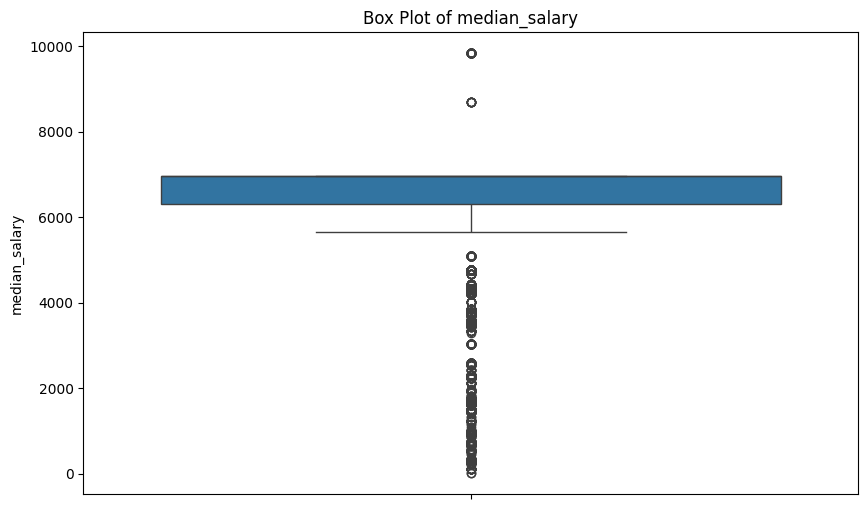

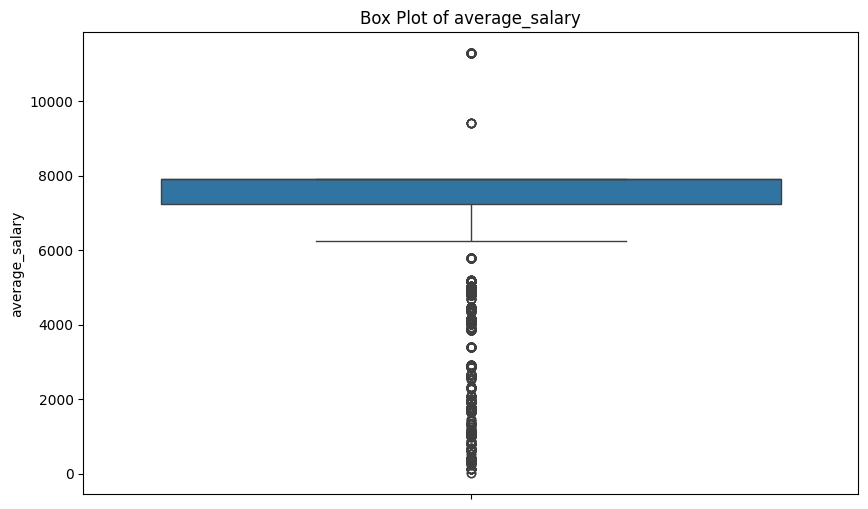

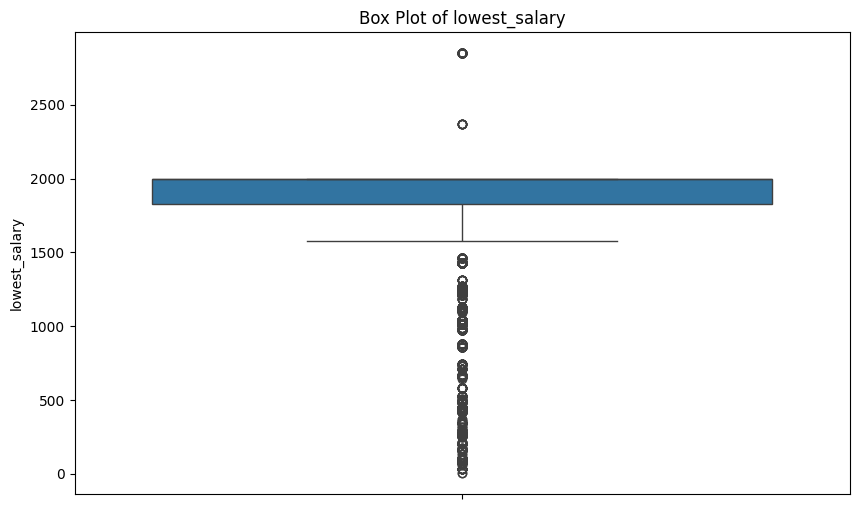

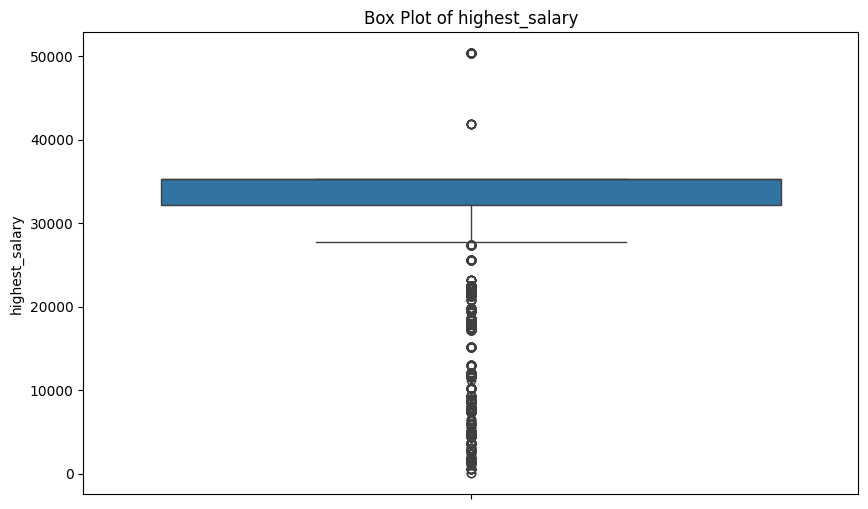

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting numerical columns from the merged dataframe
numerical_cols_merged = merged_all_features_final.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("Visualizing outliers in numerical features using box plots:")

# Plotting box plots for numerical features to visualize outliers
for col in numerical_cols_merged:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=merged_all_features_final, y=col)
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
    plt.show()